# Plotting Notebook
This notebook displays and manipulates the histograms produced by `make_plots.py`. <br>
Please use this is a guide to the type plots that you can create, as examples of the `hist`, `mplhep`, and other packages, as well as the use of the various functions that we have written in `plot_utils.py`. <br>
Use the the Table of Contents in Jupyter to view the different sections of the notebook to help navigating it.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os, sys, glob
from rich.pretty import pprint
from rich.console import Console
from rich.table import Table
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
import itertools
import warnings
import json
import scipy
%aimport plot_utils
%aimport fill_utils

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'
plt.style.use(hep.style.CMS)

In [4]:
def convert_permuon_to_perevent(h):
    h_new = Hist.new.Reg(10, 0, 10, name=h.axes[0].name, label=h.axes[0].label).Weight()
    h_new[0] = h[0]
    for i in range(1, 10):
        h_new[i] = hist.accumulators.WeightedSum(
            h[i].value / i,
            h[i].variance / (i**2)
        )
    return h_new

## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [5]:
# parameters
output_label = './output_plots/'
file_ext = '.png'

# for muon enriched samples
efficiencies = {
    '15To20': 0.0034,
    '20To30': 0.0065,
    '30To50': 0.0108,
    '50To80': 0.0221,
    '80To120': 0.0386,
    '120To170': 0.05236,
    '170To300': 0.0698,
    '300To470': 0.0903,
    '470To600': 0.1057,
    '600To800': 0.11875,
    '800To1000': 0.1194,
    '1000': 0.1289,
}
apply_eff = False

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [6]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions of plots: (sample) x (plot label)
# N.B.: lumis are applied through loader()

# input .pkl files
plotDir = './temp_output_histograms/'
infile_names = glob.glob(plotDir+'*.pkl')

# generate list of files that you want to merge histograms for
offline_files_SUEP = [
    f for f in infile_names if ("SUEP" in f) and ("histograms.pkl" in f)
]
offline_files_normalized = [
    f for f in infile_names if ("normalized.pkl" in f)
]
offline_files_other = [
    f for f in infile_names if ("pythia8" in f) and ("histograms.pkl" in f)
]
offline_files = offline_files_normalized + offline_files_other
pprint(offline_files)

data_files = [
    f for f in infile_names if ("DoubleMuon" in f) and ("histograms.pkl" in f)
]
pprint(data_files)

other_bkg_names = {
    "DYJetsToLL": "DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYLowMass_NLO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                     "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "DYLowMass_LO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8+"
                    "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM",
    "DYJetsToMuMu": "DYJetsToMuMu_M-50_massWgtFix_TuneCP5_13TeV-powhegMiNNLO-pythia8-photos",
    "TTTo2L2Nu": "TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8",
    "TTJets": "TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ttZJets": "ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8+"
               "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "WWZ_4F": "WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "WWZJetsTo4L2Nu_4F": "WWZJetsTo4L2Nu_4F_TuneCP5_13TeV-amcatnlo-pythia8",
    "ZZTo4L": "ZZTo4L_TuneCP5_13TeV_powheg_pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ZZZ": "ZZZ_TuneCP5_13TeV-amcatnlo-pythia8+"
           "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
}

# merge the histograms, apply lumis, exclude low HT bins
plots_SUEP_2018 = plot_utils.loader(offline_files_SUEP, year=2018, custom_lumi=1000)
plots_2018 = plot_utils.loader(offline_files, year=2018, custom_lumi=1000)
plots_data = plot_utils.loader(data_files, year=2018, is_data=True)

# put everything in one dictionary, apply lumi for SUEPs
plots = {}
for key in plots_SUEP_2018.keys(): 
    plots[key+"_2018"] = fill_utils.apply_normalization(
        plots_SUEP_2018[key], 
        fill_utils.getXSection(key+'+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True)
    )
for key in plots_2018.keys():
    is_binned = False
    binned_samples = [
        "QCD_Pt",
        "QCD_HT",
        "MuEnriched",
        "ZToMuMu",
        "JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8",
        "DYNJetsToLL",
        "DYJetsToLL_M-50_HT",
        "DYJetsToLL_M-4to50_HT",
        "DYJetsToLL_HT",
    ]
    for binned_sample in binned_samples:
        if binned_sample in key:
            is_binned = True
    if is_binned and ('normalized' not in key) and ('cutflow' in key):
        continue
    if is_binned or ('bkg' in key):
        plots[key+"_2018"] = plots_2018[key]
        if apply_eff and 'MuEnriched' in key:
            factor = 1
            for eff in efficiencies.keys():
                if eff in sample:
                    factor = efficiencies[eff]
                    break
            for p in plots[key+"_2018"]:
                plots[key+"_2018"][p] *= factor
    else:
        plots[key+"_2018"] = fill_utils.apply_normalization(
            plots_2018[key], 
            fill_utils.getXSection(other_bkg_names[key], '2018', SUEP=False)
        )

for key in plots_data.keys(): 
    plots[key+"_2018"] = plots_data[key]

# Combine DYNJetsToLL with DYLowMass_LO
dy_combined = {}
for plt_i in plots['DYLowMass_LO_2018'].keys():
    dy_combined[plt_i] = plots['DYLowMass_LO_2018'][plt_i] + plots['DYNJetsToLL_2018'][plt_i]
plots['DYCombined_2018'] = dy_combined

# Combine ZZZ with WWZ
vvv_combined = {}
for plt_i in plots['WWZ_4F_2018'].keys():
    vvv_combined[plt_i] = plots['WWZ_4F_2018'][plt_i] + plots['ZZZ_2018'][plt_i]
plots['VVV_2018'] = vvv_combined

[
│   './temp_output_histograms/QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_300to470_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_30to50_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_470to600_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_50to80_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_600to800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_800to1000_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_Pt_80to120_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_HT1000to1500_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_HT100to200_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_HT1500to2000_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_HT2000toInf_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_HT200to300_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_HT300to500_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_HT500to700_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './temp_output_histograms/QCD_HT50to100_TuneCP5_PSWeig

['./temp_output_histograms/DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms.pkl']

These are all the samples loaded.

In [7]:
keys = list(plots.keys())
pprint(keys)

[
│   'SUEP-m125-darkPho_2018',
│   'SUEP-m125-darkPhoHad_2018',
│   'SUEP-m400-darkPho_2018',
│   'SUEP-m400-darkPhoHad_2018',
│   'SUEP-m750-darkPho_2018',
│   'SUEP-m750-darkPhoHad_2018',
│   'SUEP-m1000-darkPho_2018',
│   'SUEP-m1000-darkPhoHad_2018',
│   'QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'bkg_2018',
│   'QCD_Pt_2018',
│   'QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_300to470_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_30to50_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_470to600_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_50to80_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_600to800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_800to1000_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_80to120_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_HT1000to1500_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_HT_2018',
│   'QCD_HT100to200_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_HT1500to2000_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_HT2000toInf_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_HT200to300_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_HT300to500_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_HT500to700_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_HT50to100_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_HT700to1000_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realis

In [8]:
for key in plots['QCD_Pt_2018'].keys():
    pprint(f"{key = }")

"key = 'muon_pt_vs_nMuon'"

"key = 'muon_METmt_vs_nMuon'"

"key = 'muon_mt_vs_nMuon'"

"key = 'muon_dz_vs_nMuon'"

"key = 'muon_ip3d_vs_nMuon'"

"key = 'muon_dxy_vs_miniPFRelIso_vs_nMuon'"

"key = 'muon_pt_vs_miniPFRelIso_vs_nMuon'"

"key = 'nTrack_vs_nMuon'"

"key = 'nTrack_log_vs_nMuon'"

## Section with histograms for fitting

Will plot:
  - dxy
  - pt
  - PFIso
  - nTrack
  - nMuon
  
both as stacked & non-stacked plots.

In [9]:
for key in plots['DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms_2018'].keys():
    pprint(f"{key = }")

"key = 'muon_pt_vs_nMuon'"

"key = 'muon_METmt_vs_nMuon'"

"key = 'muon_mt_vs_nMuon'"

"key = 'muon_dz_vs_nMuon'"

"key = 'muon_ip3d_vs_nMuon'"

"key = 'muon_dxy_vs_miniPFRelIso_vs_nMuon'"

"key = 'muon_pt_vs_miniPFRelIso_vs_nMuon'"

"key = 'nTrack_vs_nMuon'"

"key = 'nTrack_log_vs_nMuon'"

[0.00013183 0.00017378 0.00022909 0.000302   0.00039811 0.00052481
 0.00069183 0.00091201 0.00120226 0.00158489 0.0020893  0.00275423
 0.00363078 0.0047863  0.00630957 0.00831764 0.01096478 0.0144544
 0.01905461]
[  1287.98287156   2312.52830864   2484.67728798   1445.52676867
   2793.99075995   5995.0575953    5141.10822316   4565.83172474
 135721.19233319  11952.08864454  73400.61531354  91117.27175409
  97417.81181888  21151.84439455  29417.26861685  27920.23932893
  95372.86799571  17728.83239037  10098.93951087]
[  805.60157505  1139.59406354  1139.68975717   147.10588629
   834.00246962  1805.76041618  1414.80490249  1167.95993561
 88176.46610085  5574.26244318 62276.00388775 62966.42370032
 63196.74125446  7844.59006946  9617.56618142  8206.07579412
 63181.6507206   5923.2584609   2310.48331477]


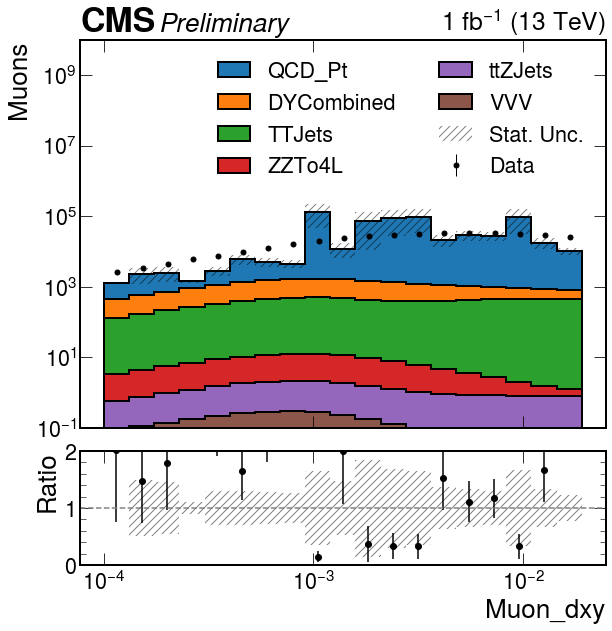

In [33]:
plot_label = ('muon_dxy_vs_miniPFRelIso_vs_nMuon', 'Muon_dxy')
year = '2018'

bkgs = [
    'VVV_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'QCD_Pt_2018',
]
slc = slice(0, 0.02j, 2j)
ylim = (1e-1, 1e10)

plot_utils.plot_ratio_stack(
    plots=plots, 
    bkg_list=bkgs, 
    label=plot_label, 
    slc=slc, 
    ylim=ylim, 
    xlog=True, 
    ylog=True,
    per_muon=True,
)

[  3.4673685    4.5708819    6.02559586   7.94328235  10.47128548
  13.80384265  18.19700859  23.98832919  31.6227766   41.68693835
  54.95408739  72.44359601  95.4992586  125.89254118 165.95869074
 218.77616239 288.40315031 380.18939632 501.18723363 660.69344801
 870.96358996]
[1.09312330e+04 1.00954885e+05 2.64463676e+05 1.82177847e+05
 2.02601953e+04 2.53023552e+04 1.00370641e+04 1.04100213e+04
 8.01567546e+03 3.93494129e+03 3.59553880e+03 1.76465318e+03
 1.01597877e+03 4.89416909e+02 2.08232885e+02 8.83790658e+01
 2.97572790e+01 9.15675616e+00 2.59675885e+00 9.51135379e-01
 1.14896265e-01]
[5.57584296e+03 6.32124225e+04 1.09152270e+05 8.89074042e+04
 3.26851282e+03 6.29698622e+03 2.01680469e+03 2.29933342e+03
 1.83042825e+03 8.30814585e+02 8.23458463e+02 4.96401047e+01
 3.76254375e+01 2.13293653e+01 6.42774220e+00 5.12867142e+00
 7.97996803e-01 3.68839658e-01 1.76336675e-01 2.41120638e-01
 3.49675026e-02]


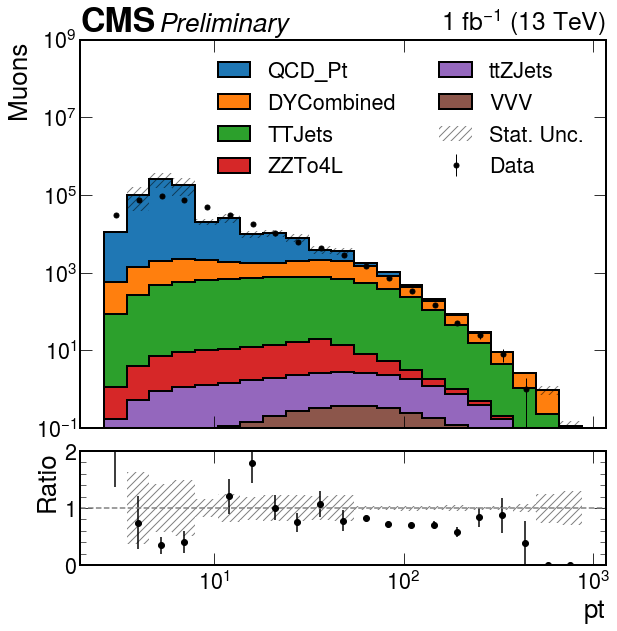

In [34]:
plot_label = ('muon_pt_vs_miniPFRelIso_vs_nMuon', 'pt')
year = '2018'

bkgs = [
    'VVV_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'QCD_Pt_2018',
]
slc = slice(3j, 1000j, 2j)
ylim = (1e-1, 1e9)

plot_utils.plot_ratio_stack(
    plots=plots, 
    bkg_list=bkgs, 
    label=plot_label, 
    slc=slc, 
    ylim=ylim, 
    xlog=True, 
    ylog=True,
    per_muon=True,
)

[1.73780083e-03 3.01995172e-03 5.24807460e-03 9.12010839e-03
 1.58489319e-02 2.75422870e-02 4.78630092e-02 8.31763771e-02
 1.44543977e-01 2.51188643e-01 4.36515832e-01 7.58577575e-01
 1.31825674e+00 2.29086765e+00 3.98107171e+00 6.91830971e+00
 1.20226443e+01 2.08929613e+01 3.63078055e+01 6.30957344e+01
 1.09647820e+02 1.90546072e+02]
[1.12111251e+02 8.24008159e+01 2.55629880e+02 4.66904056e+02
 7.03400765e+02 2.85066649e+03 1.97416708e+03 3.97976880e+03
 2.52752908e+03 7.14541050e+04 1.76691917e+04 4.52386196e+04
 9.87049168e+04 9.93412158e+04 1.80027610e+04 8.81270413e+04
 7.89595252e+03 1.64376895e+03 5.39443438e+02 8.85361469e+01
 1.68029419e+01 9.30322761e-01]
[7.90303990e+01 3.97589981e+00 1.48095591e+01 5.56592558e+00
 1.63232530e+01 1.15022371e+03 8.13256913e+02 1.40483495e+03
 3.29234326e+02 6.24666732e+04 5.97240350e+03 1.23767023e+04
 6.28089926e+04 6.30082266e+04 3.15631962e+03 6.29366055e+04
 1.84771440e+03 2.49617673e+02 9.60105284e+01 1.36349368e+01
 5.00614333e+00 8.782

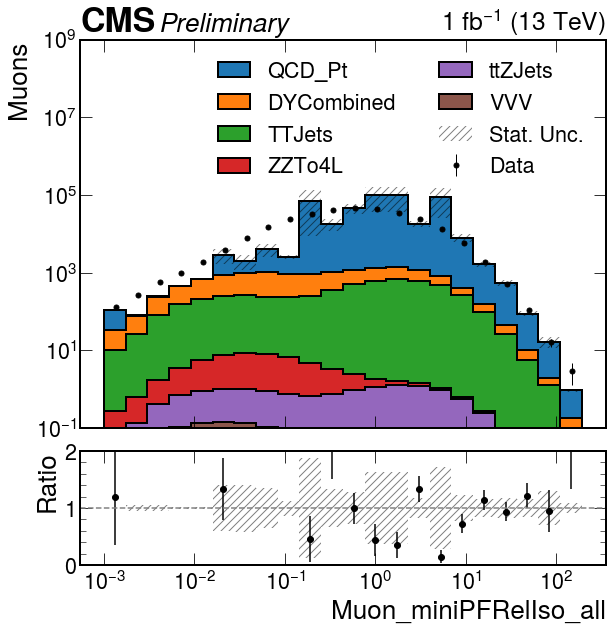

In [35]:
plot_label = ('muon_pt_vs_miniPFRelIso_vs_nMuon', 'Muon_miniPFRelIso_all')
year = '2018'

bkgs = [
    'VVV_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'QCD_Pt_2018',
]
slc = slice(1e-3j, 300j, 2j)
ylim = (1e-1, 1e9)

plot_utils.plot_ratio_stack(
    plots=plots, 
    bkg_list=bkgs, 
    label=plot_label, 
    slc=slc, 
    ylim=ylim, 
    xlog=True, 
    ylog=True,
    per_muon=True,
)

[  3.4673685    4.5708819    6.02559586   7.94328235  10.47128548
  13.80384265  18.19700859  23.98832919  31.6227766   41.68693835
  54.95408739  72.44359601  95.4992586  125.89254118 165.95869074
 218.77616239 288.40315031]
[4.72273290e-01 3.08904219e+00 2.04917907e+01 1.89207823e+01
 1.13323043e+02 2.30198561e+02 6.10080580e+02 7.85929276e+03
 7.38310015e+04 9.56377782e+04 9.00694629e+03 2.15200063e+04
 4.53230780e+03 1.15381427e+03 2.60415559e+01 4.56608811e-01
 8.38641791e-03]
[2.39226494e-01 6.23227623e-01 1.59795949e+00 1.46256304e+00
 3.51571370e+00 2.09299053e+01 8.30367366e+01 5.45034909e+03
 6.24822183e+04 6.31863475e+04 1.85609719e+03 6.13646635e+03
 1.41629202e+03 8.10086265e+02 7.04807083e+00 1.30737360e-01
 3.49027131e-03]


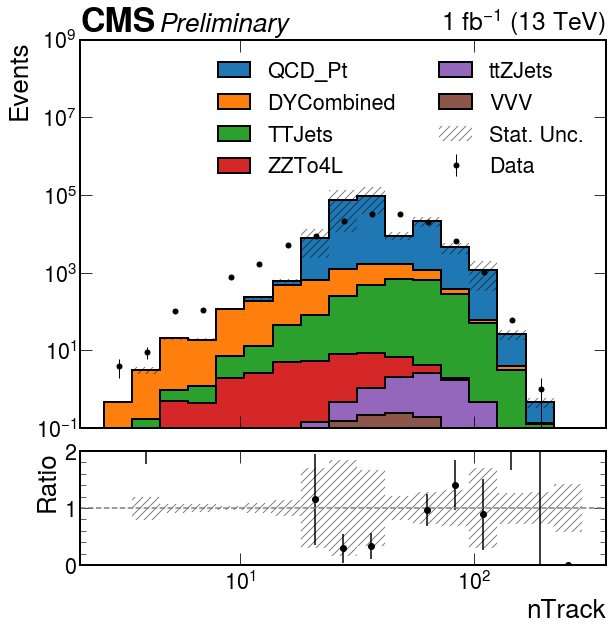

In [36]:
plot_label = ('nTrack_log_vs_nMuon', 'nTrack')
year = '2018'

bkgs = [
    'VVV_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'QCD_Pt_2018',
]
slc = slice(3j, 300j, 2j)
ylim = (1e-1, 1e9)

plot_utils.plot_ratio_stack(
    plots=plots, 
    bkg_list=bkgs, 
    label=plot_label, 
    slc=slc, 
    ylim=ylim, 
    xlog=True, 
    ylog=True,
)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[     0.              0.              0.         214564.22978333
      0.              0.              0.              0.
      0.              0.        ]
[    0.             0.             0.         89274.96436181
     0.             0.             0.             0.
     0.             0.        ]


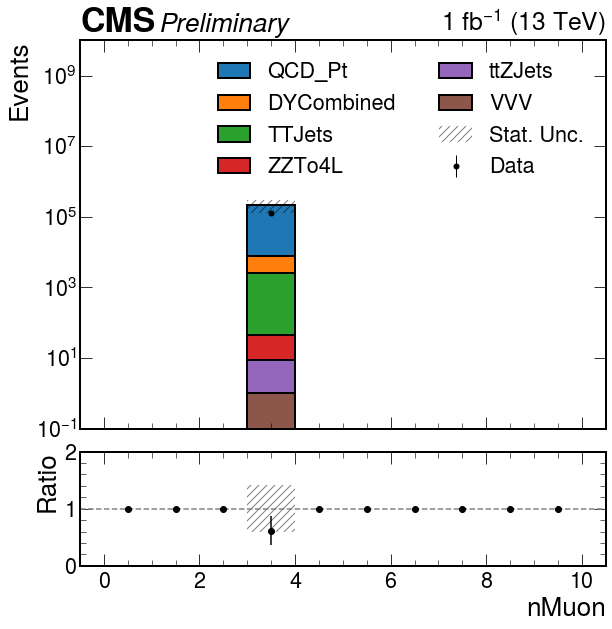

In [37]:
plot_label = ('nTrack_log_vs_nMuon', 'nMuon')
year = '2018'

bkgs = [
    'VVV_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'QCD_Pt_2018',
]
slc = slice(0j, 10j, 1j)
ylim = (1e-1, 1e10)

plot_utils.plot_ratio_stack(
    plots=plots, 
    bkg_list=bkgs, 
    label=plot_label, 
    slc=slc, 
    ylim=ylim, 
    xlog=False, 
    ylog=True,
)

In [32]:
plots["bkg_2018"]['muon_dxy_vs_miniPFRelIso_vs_nMuon'][:0.02j:3j, ::sum, ::sum]

Hist(Regular(12, 0.0001, 0.0144544, transform=log, name='Muon_dxy', label='Muon_dxy'), storage=Weight()) # Sum: WeightedSum(value=614382, variance=2.3902e+10) (WeightedSum(value=629441, variance=2.39101e+10) with flow)

In [70]:
plots["bkg_2018"]['muon_dxy_vs_miniPFRelIso_vs_nMuon'].project("Muon_dxy")[:0.02j:3j]

Hist(Regular(12, 0.0001, 0.0144544, transform=log, name='Muon_dxy', label='Muon_dxy'), storage=Weight()) # Sum: WeightedSum(value=614382, variance=2.3902e+10) (WeightedSum(value=629441, variance=2.39101e+10) with flow)

In [45]:
hist_data = plots["bkg_2018"]['muon_dxy_vs_miniPFRelIso_vs_nMuon'][:0.02j:3j, ::sum, ::sum]

In [27]:
print(hist_data.values())
print(len(hist_data.values()))

[  2833.60662111   2338.42304878   1756.53357545   6642.22190872
   5212.82031509 137350.72210769  16256.37014906 157287.96234692
 100933.20910952  44720.99582483  43190.19706846  95858.92866993]
12


In [28]:
print(np.sqrt(hist_data.variances()))
print(len(np.sqrt(hist_data.variances())))

[ 1395.21724692  1140.11094655   233.38368064  1980.74350943
  1426.27832136 88184.01467421  5862.12021651 88542.52554902
 63212.92098265 12328.40996401 11261.69195772 62988.25146204]
12


In [29]:
axis = hist_data.axes[0]

In [30]:
print(axis.edges[:-1])
print(len(axis.edges[:-1]))

[0.0001     0.00015136 0.00022909 0.00034674 0.00052481 0.00079433
 0.00120226 0.0018197  0.00275423 0.00416869 0.00630957 0.00954993]
12


In [ ]:
def plot_ratio_stack(
    plots,
    bkg_list,
    label,
):
    """
    Plots ratio of a list of bkg Hist histograms over a data Hist histogram.
    The errors in the ratio are taken to be independent between histograms.
    """

    # Set up variables for the stacked histogram
    fig = plt.figure()
    plt.subplots_adjust(bottom=0.15, left=0.17)
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)

    hists = []
    for bkg in bkgs:
        hists.append(plots[bkg][plot_label][:0.02j:3j, ::sum, ::sum])
    hep.histplot(
        hists,
        yerr=[np.sqrt(h.variances()) for h in hists], 
        label=[b.replace('_2018', '') for b in bkgs],
        stack=stack,
        histtype='fill',
        ec="black",
        lw=2,
    )

    # Overlay an uncertainty hatch
    sumw_total = sumw_stack.sum(axis=0)
    unc = np.sqrt(sumw2_sig + sumw2_bkg)
    unc = np.hstack([unc, unc[-1]])
    ax.fill_between(
        x=bin_edges, 
        y1=sumw_total - unc, 
        y2=sumw_total + unc,
        label='Stat. Unc.', 
        step='post', 
        **hatch_style
    )


    h_data = plots['DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms_2018'][plot_label][:0.02j:3j, ::sum, ::sum]
    hep.histplot(
        h_data,
        label=['Data'],
        histtype='errorbar',
        mec='black',
        mfc='black',
        ecolor='black'
    )
    
    y, x = h.to_numpy()
    x_mid = h.axes.centers[0]
    ax1.set_ylabel("Events", y=1, ha="right")

    ax2 = plt.subplot2grid((4, 1), (2, 0), sharex=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)

    ratio = np.divide(
        h.values(),
        hlist[0].values(),
        out=np.ones_like(h.values()),
        where=hlist[0].values() != 0,
    )
    ratio_err = np.where(
        hlist[0].values() > 0,
        np.sqrt(
            (hlist[0].values() ** -2) * (h.variances())
            + (h.values() ** 2 * hlist[0].values() ** -4) * (hlist[0].variances())
        ),
        0,
    )
    ax2.errorbar(
        hlist[0].axes.centers[0],
        ratio,
        yerr=ratio_err,
        color=c,
        fmt="o",
        linestyle="none",
    )

    ax2.axhline(1, ls="--", color="gray")
    ax2.set_ylabel("Ratio", y=1, ha="right")

    ax1.legend(loc="best")
    ax2.set_xlabel(plot_label, y=1)

    return fig, (ax1, ax2)


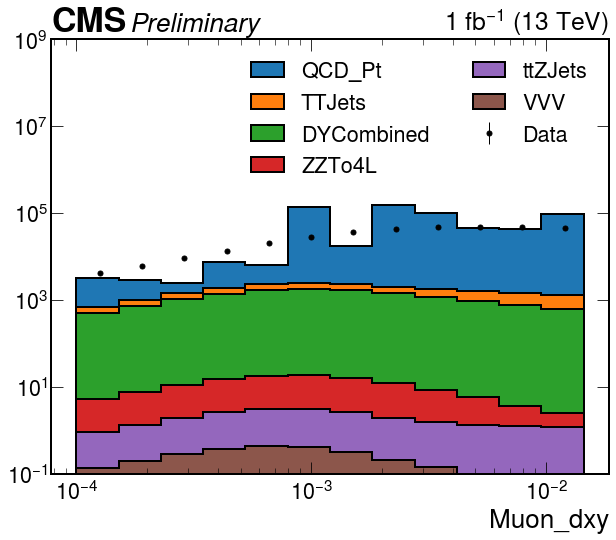

In [25]:
plot_label = 'muon_dxy_vs_miniPFRelIso_vs_nMuon'
year = '2018'

bkgs = [
    'QCD_Pt_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'ZZTo4L_2018',
    'ttZJets_2018',
    'VVV_2018',
]
if stack:
    bkgs = bkgs[::-1]


    
hists = []
for bkg in bkgs:
    hists.append(plots[bkg][plot_label][:0.02j:3j, ::sum, ::sum])
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
hep.histplot(
    hists,
    yerr=[np.sqrt(h.variances()) for h in hists], 
    label=[b.replace('_2018', '') for b in bkgs],
    stack=stack,
    histtype='fill',
    ec="black",
    lw=2,
)

# Overlay an uncertainty hatch
sumw_total = sumw_stack.sum(axis=0)
unc = np.sqrt(sumw2_sig + sumw2_bkg)
unc = np.hstack([unc, unc[-1]])
ax.fill_between(
    x=bin_edges, 
    y1=sumw_total - unc, 
    y2=sumw_total + unc,
    label='Stat. Unc.', 
    step='post', 
    **hatch_style
)


h_data = plots['DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms_2018'][plot_label][:0.02j:3j, ::sum, ::sum]
hep.histplot(
    h_data,
    #yerr=np.sqrt(h_data.variances()), 
    label=['Data'],
    histtype='errorbar',
    mec='black',
    mfc='black',
    ecolor='black'
)

plt.legend(ncol=2)
plt.xscale('log')
plt.yscale('log')
hep.cms.label(llabel='Preliminary',data=False, lumi=r"1")
plt.ylim(1e-1, 1e9)
plt.show()

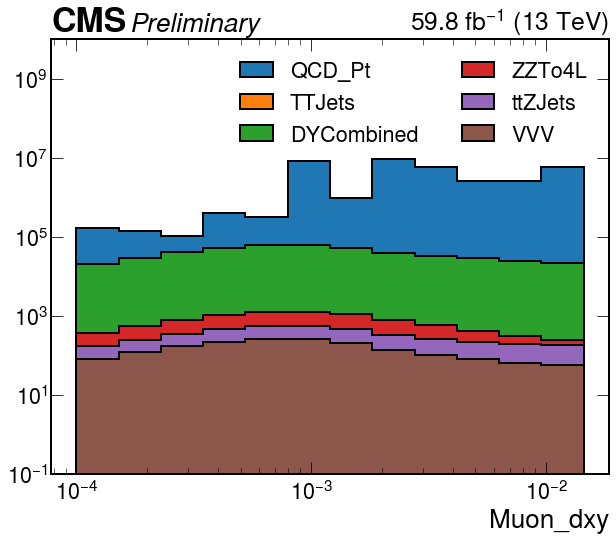

In [18]:
plot_label = 'muon_dxy_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year = '2018'
decay = 'darkPho'
stack = True

bkgs = [
    'QCD_Pt_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'ZZTo4L_2018',
    'ttZJets_2018',
    'VVV_2018',
]
if stack:
    bkgs = bkgs[::-1]

hists = []
for bkg in bkgs:
    hists.append(plots[bkg][plot_label][:0.02j:3j, ::sum, ::sum, 3j])
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
hep.histplot(
    hists,
    yerr=[np.sqrt(h.variances()) for h in hists], 
    label=[b.replace('_2018', '') for b in bkgs],
    stack=stack,
    histtype='fill',
    ec="black",
    lw=2,
)
plt.legend(ncol=2)
plt.xscale('log')
plt.yscale('log')
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
plt.ylim(1e-1, 1e10)
plt.show()

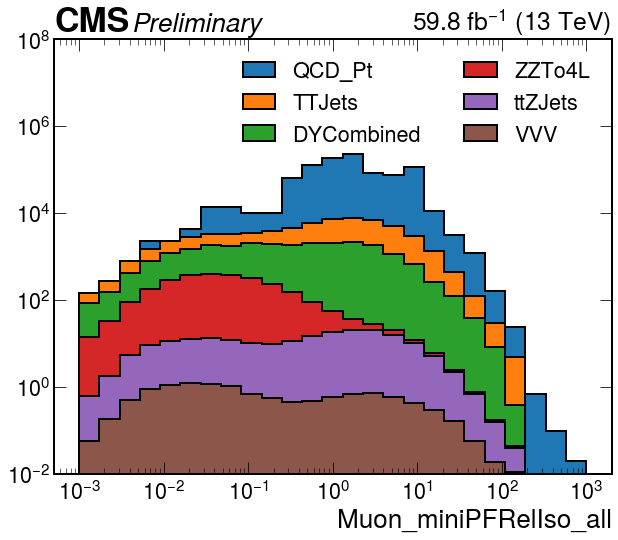

In [14]:
plot_label = 'muon_dxy_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year = '2018'
decay = 'darkPho'
stack = True

bkgs = [
    'QCD_Pt_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'ZZTo4L_2018',
    'ttZJets_2018',
    'VVV_2018',
]
if stack:
    bkgs = bkgs[::-1]

hists = []
for bkg in bkgs:
    hists.append(plots[bkg][plot_label][::sum, ::2j, ::sum, 4j])
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
hep.histplot(
    hists,
    yerr=[np.sqrt(h.variances()) for h in hists], 
    label=[b.replace('_2018', '') for b in bkgs],
    stack=stack,
    histtype='fill',
    ec="black",
    lw=2,
)
plt.legend(ncol=2)
plt.xscale('log')
plt.yscale('log')
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
plt.ylim(1e-2, 1e8)
plt.show()

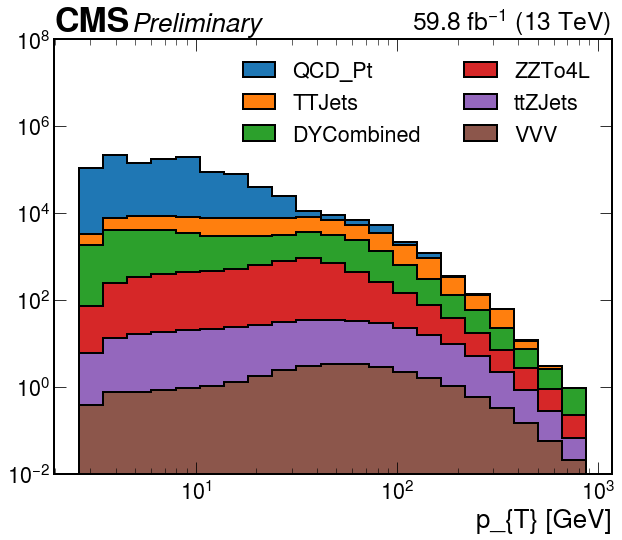

In [15]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year = '2018'
decay = 'darkPho'
stack = True

bkgs = [
    'QCD_Pt_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'ZZTo4L_2018',
    'ttZJets_2018',
    'VVV_2018',
]
if stack:
    bkgs = bkgs[::-1]

hists = []
for bkg in bkgs:
    hists.append(plots[bkg][plot_label][3j::2j, ::sum, ::sum, 4j])
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
hep.histplot(
    hists,
    yerr=[np.sqrt(h.variances()) for h in hists], 
    label=[b.replace('_2018', '') for b in bkgs],
    stack=stack,
    histtype='fill',
    ec="black",
    lw=2,
)
plt.legend(ncol=2)
plt.xscale('log')
plt.yscale('log')
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
plt.ylim(1e-2, 1e8)
plt.show()

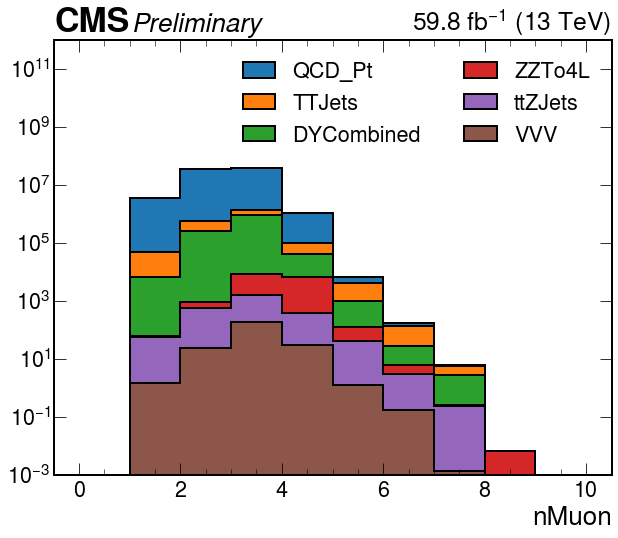

In [16]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year = '2018'
decay = 'darkPho'
stack = True

bkgs = [
    'QCD_Pt_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'ZZTo4L_2018',
    'ttZJets_2018',
    'VVV_2018',
]
if stack:
    bkgs = bkgs[::-1]

hists = []
for bkg in bkgs:
    hists.append(plots[bkg][plot_label][::sum, ::sum, ::sum, :])
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
hep.histplot(
    hists,
    yerr=[np.sqrt(h.variances()) for h in hists], 
    label=[b.replace('_2018', '') for b in bkgs],
    stack=stack,
    histtype='fill',
    ec="black",
    lw=2,
)
plt.legend(ncol=2)
plt.yscale('log')
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
plt.ylim(1e-3, 1e12)
plt.show()

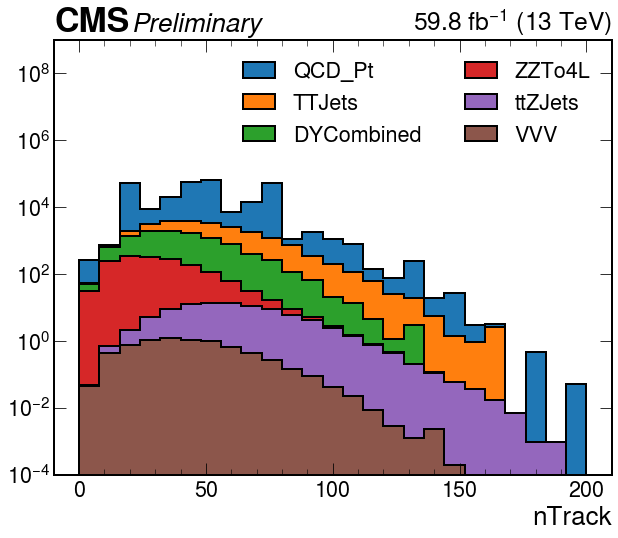

In [22]:
plot_label = 'nTrack_nMuon'
year = '2018'
decay = 'darkPho'
stack = True

bkgs = [
    'QCD_Pt_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'ZZTo4L_2018',
    'ttZJets_2018',
    'VVV_2018',
]
if stack:
    bkgs = bkgs[::-1]

hists = []
for bkg in bkgs:
    hists.append(plots[bkg][plot_label][::4j, 4j])
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
hep.histplot(
    hists,
    yerr=[np.sqrt(h.variances()) for h in hists], 
    label=[b.replace('_2018', '') for b in bkgs],
    stack=stack,
    histtype='fill',
    ec="black",
    lw=2,
)
plt.legend(ncol=2)
plt.yscale('log')
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
plt.ylim(1e-4, 1e9)
plt.show()

In [8]:
plot_label = 'nTrack_log_nMuon'
year = '2018'
decay = 'darkPho'
stack = True

bkgs = [
    'QCD_Pt_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'ZZTo4L_2018',
    'ttZJets_2018',
    'VVV_2018',
    './temp_output_histograms/DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms.pkl_2018'
]
if stack:
    bkgs = bkgs[::-1]

hist_dict = {}
hists = []
for bkg in bkgs:
    hists.append(plots[bkg][plot_label][4j:300j:2j, 4j])
    hist_dict[bkg] = plots[bkg][plot_label][4j:300j:2j, 4j]
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
hep.histplot(
    hists,
    yerr=[np.sqrt(h.variances()) for h in hists], 
    label=[b.replace('_2018', '') for b in bkgs],
    stack=stack,
    histtype='fill',
    ec="black",
    lw=2,
)
plt.legend(ncol=2)
plt.xscale('log')
plt.yscale('log')
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
plt.ylim(1e-4, 1e9)
plt.show()

KeyError: 'nTrack_log_nMuon'

In [33]:
import uproot

In [35]:
file = uproot.recreate("example.root")

In [38]:
for bkg in hist_dict.keys():
    file[bkg] = hist_dict[bkg]

In [42]:
file.close()

### Plots

7.28 ± 7.05
42.87 ± 34.01
bin 6: 0.17 ± 0.21
bin 6 no weights: 0.17 ± 0.07


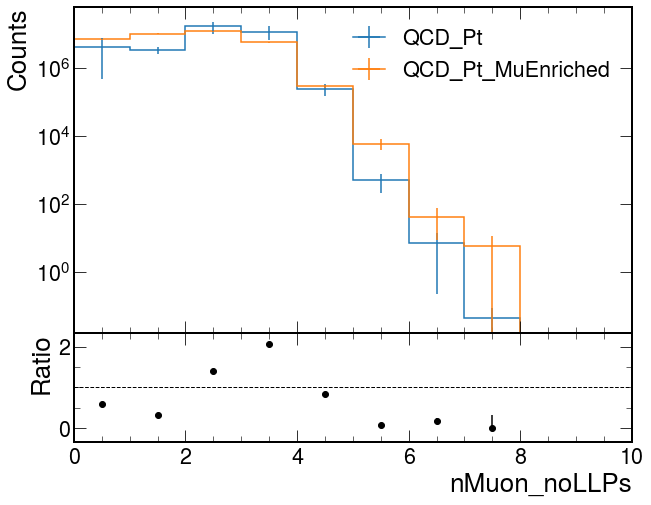

In [13]:
h1 = plots['QCD_Pt_2018']['nMuon_genflavor_all_vs_noLLPs'][::sum, :]
h2 = plots['QCD_Pt_MuEnriched_2018']['nMuon_genflavor_all_vs_noLLPs'][::sum, :]
print(f"{h1[6].value:.2f} ± {np.sqrt(h1[6].variance):.2f}")
print(f"{h2[6].value:.2f} ± {np.sqrt(h2[6].variance):.2f}")
ratio = h1[6].value / h2[6].value
delta_ratio = np.sqrt(h1[6].variance / (h2[6].value)**2 + h2[6].variance * (h1[6].value)**2 / (h2[6].value)**4)
delta_ratio_noweights = np.sqrt(h1[6].value / (h2[6].value)**2 + h2[6].value * (h1[6].value)**2 / (h2[6].value)**4)
print(f"bin 6: {ratio:.2f} ± {delta_ratio:.2f}")
print(f"bin 6 no weights: {ratio:.2f} ± {delta_ratio_noweights:.2f}")
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h1.plot_ratio(
    h2,
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
#fig.axes[1].set_yscale("log")
#fig.axes[1].set_ylim(1e-3, 1e1)
plt.show()

Plot "no matched LLPs":

7.28 ± 7.05
625.20 ± 571.56
bin 6: 0.01 ± 0.02
bin 6 no weights: 0.01 ± 0.00


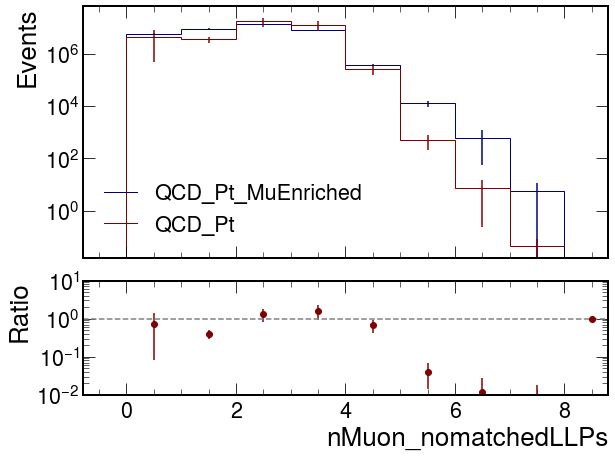

In [13]:
h1 = plots['QCD_Pt_2018']['nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'][::sum, :, ::sum, ::sum]
h2 = plots['QCD_Pt_MuEnriched_2018']['nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'][::sum, :, ::sum, ::sum]
print(f"{h1[6].value:.2f} ± {np.sqrt(h1[6].variance):.2f}")
print(f"{h2[6].value:.2f} ± {np.sqrt(h2[6].variance):.2f}")
ratio = h1[6].value / h2[6].value
delta_ratio = np.sqrt(h1[6].variance / (h2[6].value)**2 + h2[6].variance * (h1[6].value)**2 / (h2[6].value)**4)
delta_ratio_noweights = np.sqrt(h1[6].value / (h2[6].value)**2 + h2[6].value * (h1[6].value)**2 / (h2[6].value)**4)
print(f"bin 6: {ratio:.2f} ± {delta_ratio:.2f}")
print(f"bin 6 no weights: {ratio:.2f} ± {delta_ratio_noweights:.2f}")
fig, (ax1, ax2) = plot_utils.plot_ratio([h2, h1], labels=['QCD_Pt_MuEnriched', 'QCD_Pt'])
ax2.set_yscale("log")
ax2.set_ylim(1e-2, 1e1)
plt.show()

Plot "no unmatched LLPs":

7.28 ± 7.05
639.97 ± 571.62
bin 6: 0.01 ± 0.01
bin 6 no weights: 0.01 ± 0.00


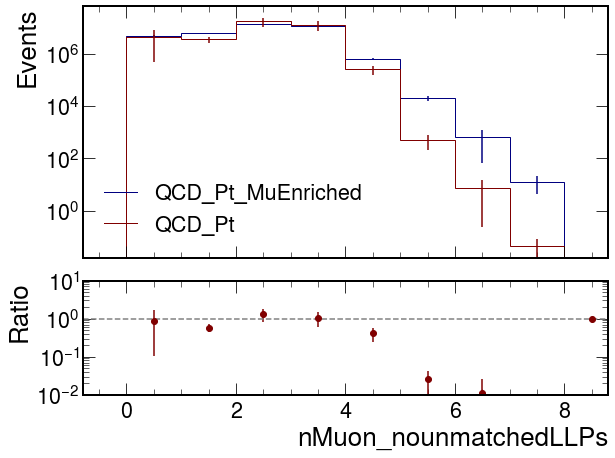

In [18]:
h1 = plots['QCD_Pt_2018']['nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'][:, ::sum, ::sum, ::sum]
h2 = plots['QCD_Pt_MuEnriched_2018']['nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'][::sum, ::sum, :, ::sum]
print(f"{h1[6].value:.2f} ± {np.sqrt(h1[6].variance):.2f}")
print(f"{h2[6].value:.2f} ± {np.sqrt(h2[6].variance):.2f}")
ratio = h1[6].value / h2[6].value
delta_ratio = np.sqrt(h1[6].variance / (h2[6].value)**2 + h2[6].variance * (h1[6].value)**2 / (h2[6].value)**4)
delta_ratio_noweights = np.sqrt(h1[6].value / (h2[6].value)**2 + h2[6].value * (h1[6].value)**2 / (h2[6].value)**4)
print(f"bin 6: {ratio:.2f} ± {delta_ratio:.2f}")
print(f"bin 6 no weights: {ratio:.2f} ± {delta_ratio_noweights:.2f}")
fig, (ax1, ax2) = plot_utils.plot_ratio([h2, h1], labels=['QCD_Pt_MuEnriched', 'QCD_Pt'])
ax2.set_yscale("log")
ax2.set_ylim(1e-2, 1e1)
plt.show()

Plot "no LLPs":

7.28 ± 7.05
619.30 ± 571.53
bin 6: 0.01 ± 0.02
bin 6 no weights: 0.01 ± 0.00


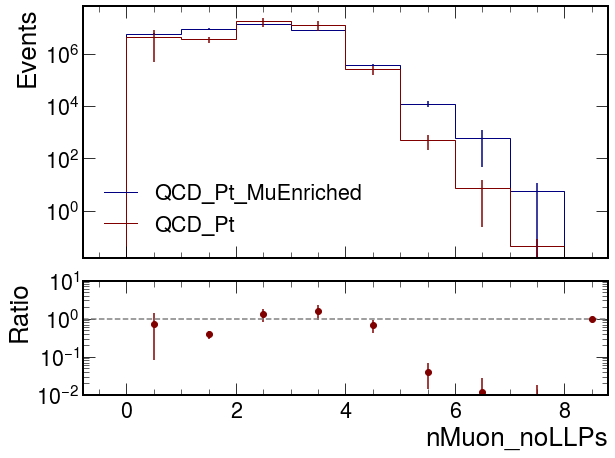

In [21]:
h1 = plots['QCD_Pt_2018']['nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'][:, ::sum, ::sum, ::sum]
h2 = plots['QCD_Pt_MuEnriched_2018'][
    'nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'
][::sum, ::sum, ::sum, :]
print(f"{h1[6].value:.2f} ± {np.sqrt(h1[6].variance):.2f}")
print(f"{h2[6].value:.2f} ± {np.sqrt(h2[6].variance):.2f}")
ratio = h1[6].value / h2[6].value
delta_ratio = np.sqrt(h1[6].variance / (h2[6].value)**2 + h2[6].variance * (h1[6].value)**2 / (h2[6].value)**4)
delta_ratio_noweights = np.sqrt(h1[6].value / (h2[6].value)**2 + h2[6].value * (h1[6].value)**2 / (h2[6].value)**4)
print(f"bin 6: {ratio:.2f} ± {delta_ratio:.2f}")
print(f"bin 6 no weights: {ratio:.2f} ± {delta_ratio_noweights:.2f}")
fig, (ax1, ax2) = plot_utils.plot_ratio([h2, h1], labels=['QCD_Pt_MuEnriched', 'QCD_Pt'])
ax2.set_yscale("log")
ax2.set_ylim(1e-2, 1e1)
plt.show()

7.28 ± 7.05
647.15 ± 571.65
bin 6: 0.01 ± 0.01
bin 6 no weights: 0.01 ± 0.00


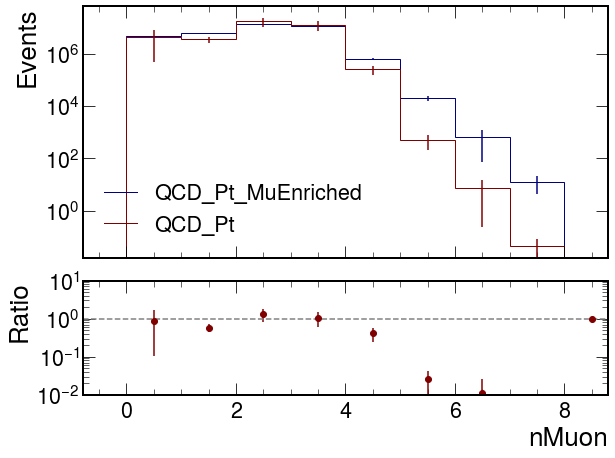

In [22]:
h1 = plots['QCD_Pt_2018']['nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'][:, ::sum, ::sum, ::sum]
h2 = plots['QCD_Pt_MuEnriched_2018'][
    'nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'
][:, ::sum, ::sum, ::sum]
print(f"{h1[6].value:.2f} ± {np.sqrt(h1[6].variance):.2f}")
print(f"{h2[6].value:.2f} ± {np.sqrt(h2[6].variance):.2f}")
ratio = h1[6].value / h2[6].value
delta_ratio = np.sqrt(h1[6].variance / (h2[6].value)**2 + h2[6].variance * (h1[6].value)**2 / (h2[6].value)**4)
delta_ratio_noweights = np.sqrt(h1[6].value / (h2[6].value)**2 + h2[6].value * (h1[6].value)**2 / (h2[6].value)**4)
print(f"bin 6: {ratio:.2f} ± {delta_ratio:.2f}")
print(f"bin 6 no weights: {ratio:.2f} ± {delta_ratio_noweights:.2f}")
fig, (ax1, ax2) = plot_utils.plot_ratio([h2, h1], labels=['QCD_Pt_MuEnriched', 'QCD_Pt'])
ax2.set_yscale("log")
ax2.set_ylim(1e-2, 1e1)
plt.show()

Compare all versions

647.15 ± 571.65
625.20 ± 571.56
639.97 ± 571.62
619.30 ± 571.53


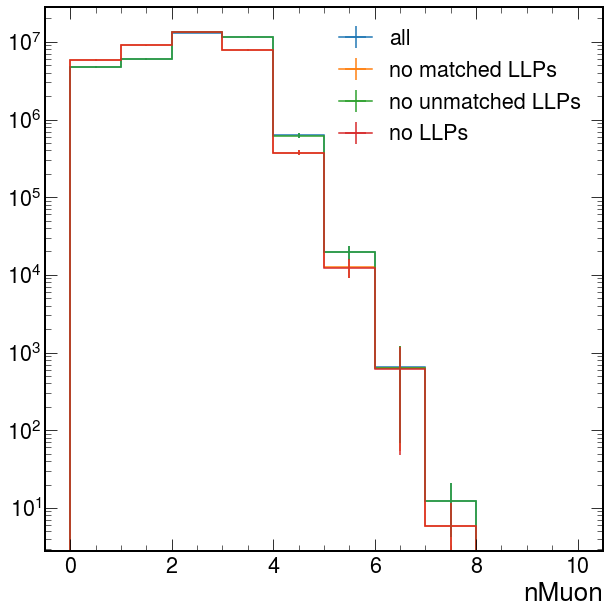

In [16]:
histogram = plots['QCD_Pt_MuEnriched_2018']['nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs']
h1 = histogram[:, ::sum, ::sum, ::sum]
h2 = histogram[::sum, :, ::sum, ::sum]
h3 = histogram[::sum, ::sum, :, ::sum]
h4 = histogram[::sum, ::sum, ::sum, :]
h_all = [h1, h2, h3, h4]
print(f"{h1[6].value:.2f} ± {np.sqrt(h1[6].variance):.2f}")
print(f"{h2[6].value:.2f} ± {np.sqrt(h2[6].variance):.2f}")
print(f"{h3[6].value:.2f} ± {np.sqrt(h3[6].variance):.2f}")
print(f"{h4[6].value:.2f} ± {np.sqrt(h4[6].variance):.2f}")
hep.histplot(
    h_all,
    yerr=[np.sqrt(h.variances()) for h in h_all], 
    label=["all","no matched LLPs","no unmatched LLPs","no LLPs"],
    stack=False,
    histtype='step',
)
plt.yscale("log")
plt.legend()
plt.show()

639.97 ± 571.62
647.15 ± 571.65
bin 6: 0.99 ± 1.24
bin 6 no weights: 0.99 ± 0.06


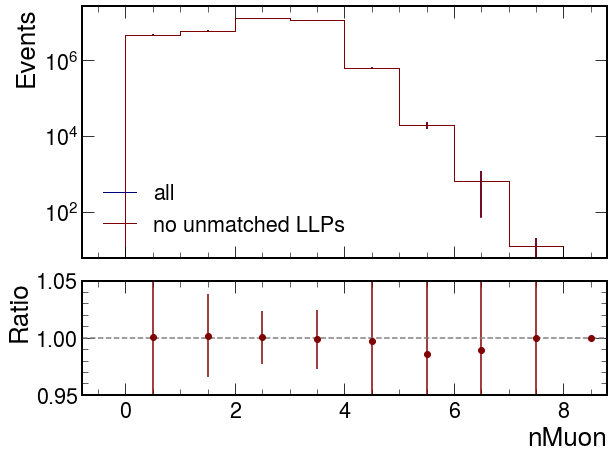

In [23]:
h1 = plots['QCD_Pt_MuEnriched_2018'][
    'nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'
][::sum, ::sum, :, ::sum]
h2 = plots['QCD_Pt_MuEnriched_2018'][
    'nMuon_all_vs_nomatchedLLPs_vs_nounmatchedLLPs_vs_noLLPs'
][:, ::sum, ::sum, ::sum]
print(f"{h1[6].value:.2f} ± {np.sqrt(h1[6].variance):.2f}")
print(f"{h2[6].value:.2f} ± {np.sqrt(h2[6].variance):.2f}")
ratio = h1[6].value / h2[6].value
delta_ratio = np.sqrt(h1[6].variance / (h2[6].value)**2 + h2[6].variance * (h1[6].value)**2 / (h2[6].value)**4)
delta_ratio_noweights = np.sqrt(h1[6].value / (h2[6].value)**2 + h2[6].value * (h1[6].value)**2 / (h2[6].value)**4)
print(f"bin 6: {ratio:.2f} ± {delta_ratio:.2f}")
print(f"bin 6 no weights: {ratio:.2f} ± {delta_ratio_noweights:.2f}")
fig, (ax1, ax2) = plot_utils.plot_ratio([h2, h1], labels=['all', 'no unmatched LLPs'])
ax2.set_ylim(0.95, 1.05)
plt.show()

Calculate the ratio between LLP muons & all non-0 muons

In [123]:
def convert_events_to_muons(h):
    """Lets go from nMuon==1 to nMuon==9"""
    n_muons = 0
    n_muons_variance = 0
    for i in range(9):
        n_muons += h[i].value * (i+1)
        n_muons_variance += h[i].variance * (i+1)**2
    return n_muons, np.sqrt(n_muons_variance)

In [119]:
print(
    "no LLPs:", convert_events_to_muons(plots['QCD_Pt_MuEnriched_2018']['nMuon_genflavor_all_vs_noLLPs'][::sum, :]))
print("all:", convert_events_to_muons(plots['QCD_Pt_MuEnriched_2018']['nMuon_genflavor_all_vs_noLLPs'][:, ::sum]))

no LLPs: (53951021.84463193, 662777.1522482907)
all: (69886656.54108863, 798574.0703092347)


In [116]:
sample = 'QCD_Pt_MuEnriched_2018'
histogram = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
wsum = (
    plots[sample][histogram][::sum, ::sum, ::sum, 1j::sum].value -
    plots[sample][histogram][::sum, ::sum, 0, 1j::sum].value,
    np.sqrt(plots[sample][histogram][::sum, ::sum, ::sum, 1j::sum].variance) +
    np.sqrt(plots[sample][histogram][::sum, ::sum, 0, 1j::sum].variance),
)
print("all non-0 muons:", (wsum[0], wsum[1]))

all non-0 muons: (58122103.227358565, 718210.3823293268)


In [117]:
plots[sample][histogram][::sum, ::sum, ::sum, 1j::sum].value

69886656.54109624

In [125]:
no_LLPs_over_all_non0 = convert_events_to_muons(
    plots['QCD_Pt_MuEnriched_2018']['nMuon_genflavor_all_vs_noLLPs'][1j:, ::sum]
)[0] / wsum[0]
no_LLPs_over_all_non0_variance = (
    (convert_events_to_muons(h1)[1] ** 2) / (wsum[0] ** 2) + 
    (convert_events_to_muons(h1)[0] ** 2) * (wsum[1] ** 2) / (wsum[0] ** 4)
)
print(
    "no LLPs:", 
    convert_events_to_muons(
        plots['QCD_Pt_MuEnriched_2018']['nMuon_genflavor_all_vs_noLLPs'][1j:, ::sum]
    )
)
print("all non-0 muons:", (wsum[0], wsum[1]))
print("ratio:", (no_LLPs_over_all_non0, np.sqrt(no_LLPs_over_all_non0_variance)))

no LLPs: (69886656.54108863, 798574.0703092347)
all non-0 muons: (58122103.227358565, 718210.3823293268)
ratio: (1.2024110047723184, 0.025074510944823467)


In [73]:
h1[1].value

10561047.31584318

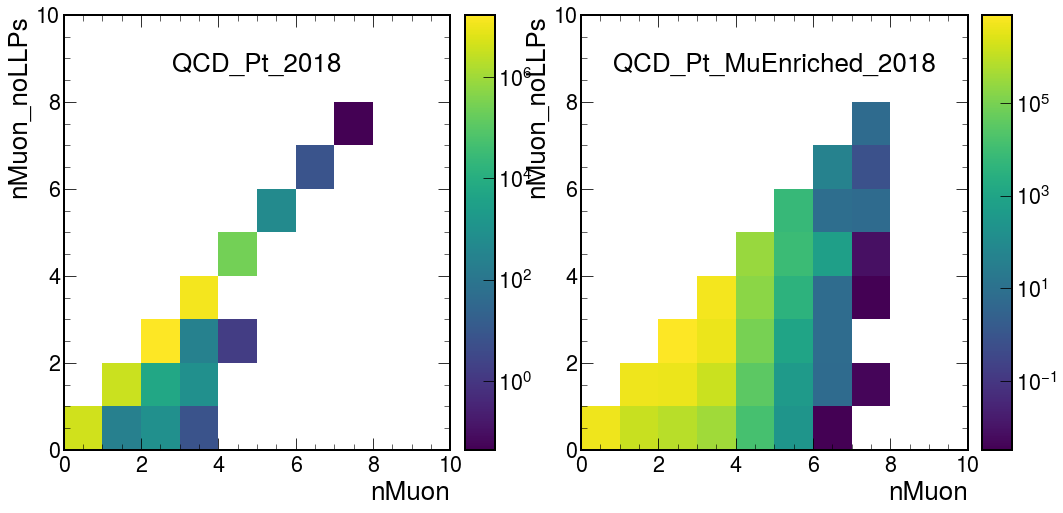

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(17,8))
hep.hist2dplot(
    plots['QCD_Pt_2018']['nMuon_genflavor_all_vs_noLLPs'],
    norm=matplotlib.colors.LogNorm(),
    ax=ax1
)
ax1.text(5, 8.7, "QCD_Pt_2018", ha='center')
hep.hist2dplot(
    plots['QCD_Pt_MuEnriched_2018']['nMuon_genflavor_all_vs_noLLPs'],
    norm=matplotlib.colors.LogNorm(),
    ax=ax2
)
ax2.text(5, 8.7, "QCD_Pt_MuEnriched_2018", ha='center')
plt.show()

1377154.91 ± 220082.68
636908.96 ± 32479.72


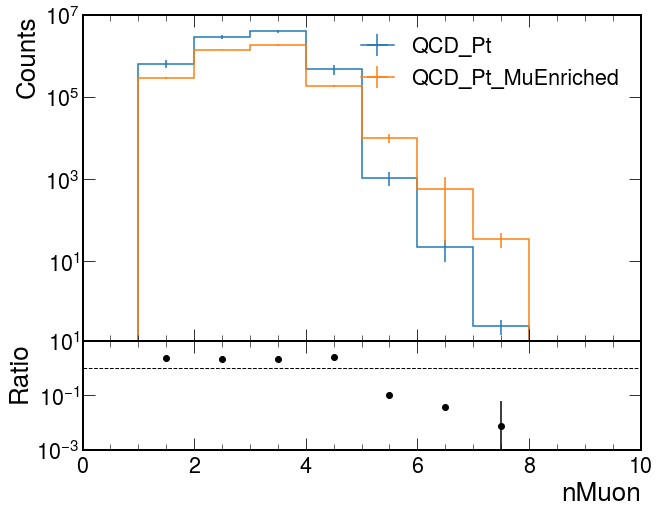

In [19]:
h1 = plots['QCD_Pt_2018']['muon_pdgId_parentId_genFlav_nMuon'][::sum, 400j:500j:sum, ::sum, :]
h2 = plots['QCD_Pt_MuEnriched_2018']['muon_pdgId_parentId_genFlav_nMuon'][::sum, 400j:500j:sum, ::sum, :]
print(f"{h1.sum().value/6:.2f} ± {np.sqrt(h1.sum().variance/6):.2f}")
print(f"{h2.sum().value/6:.2f} ± {np.sqrt(h2.sum().variance/6):.2f}")
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h1.plot_ratio(
    h2,
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
fig.axes[1].set_yscale("log")
fig.axes[1].set_ylim(1e-3, 1e1)
plt.show()

6227018.60 ± 3781850.99
6044672.76 ± 156529.49


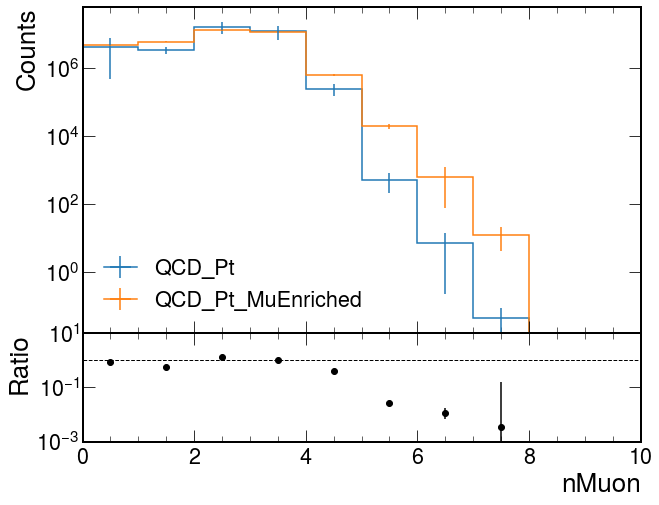

In [33]:
h1 = plots['QCD_Pt_2018']['nMuon_keep_genflavor_all_vs_45_vs_145'][:, ::sum, ::sum]
h2 = plots['QCD_Pt_MuEnriched_2018']['nMuon_keep_genflavor_all_vs_45_vs_145'][:, ::sum, ::sum]
print(f"{h1.sum().value/6:.2f} ± {np.sqrt(h1.sum().variance/6):.2f}")
print(f"{h2.sum().value/6:.2f} ± {np.sqrt(h2.sum().variance/6):.2f}")
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h1.plot_ratio(
    h2,
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
fig.axes[1].set_yscale("log")
fig.axes[1].set_ylim(1e-3, 1e1)
plt.show()

37362111.61 ± 9263605.21
36268036.53 ± 383417.38


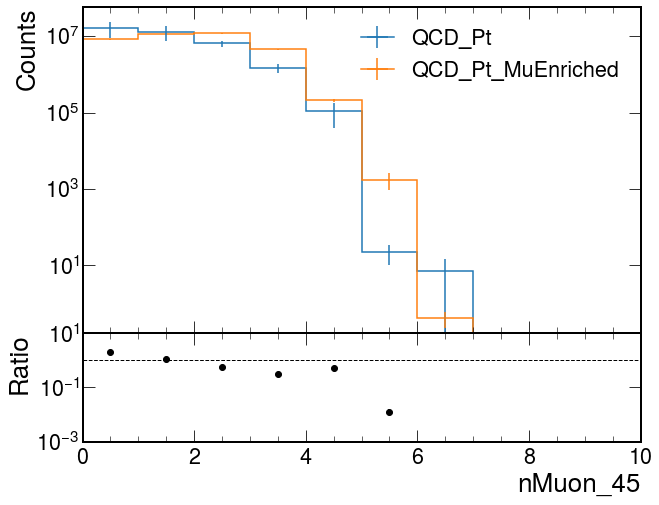

In [34]:
h1 = plots['QCD_Pt_2018']['nMuon_keep_genflavor_all_vs_45_vs_145'][::sum, :, ::sum]
h2 = plots['QCD_Pt_MuEnriched_2018']['nMuon_keep_genflavor_all_vs_45_vs_145'][::sum, :, ::sum]
print(f"{h1.sum().value:.2f} ± {np.sqrt(h1.sum().variance):.2f}")
print(f"{h2.sum().value:.2f} ± {np.sqrt(h2.sum().variance):.2f}")
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h1.plot_ratio(
    h2,
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
fig.axes[1].set_yscale("log")
fig.axes[1].set_ylim(1e-3, 1e1)
plt.show()

6227018.60 ± 3781850.99
6044672.76 ± 156529.49


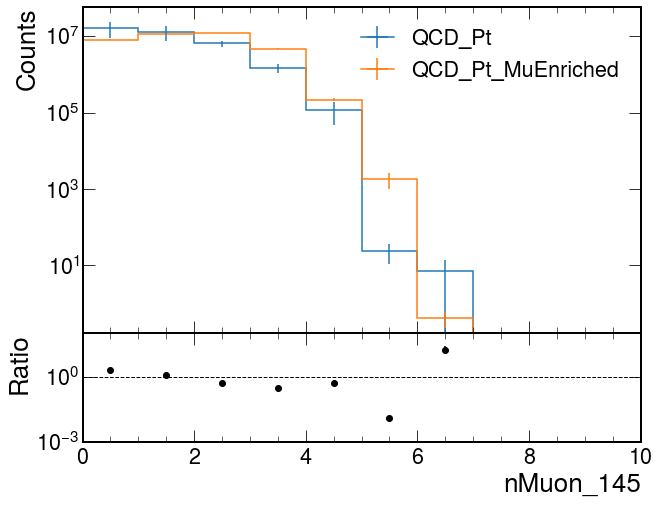

In [35]:
h1 = plots['QCD_Pt_2018']['nMuon_keep_genflavor_all_vs_45_vs_145'][::sum, ::sum, :]
h2 = plots['QCD_Pt_MuEnriched_2018']['nMuon_keep_genflavor_all_vs_45_vs_145'][::sum, ::sum, :]
print(f"{h1.sum().value/6:.2f} ± {np.sqrt(h1.sum().variance/6):.2f}")
print(f"{h2.sum().value/6:.2f} ± {np.sqrt(h2.sum().variance/6):.2f}")
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h1.plot_ratio(
    h2,
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
fig.axes[1].set_yscale("log")
fig.axes[1].set_ylim(1e-3, 1e2)
plt.show()

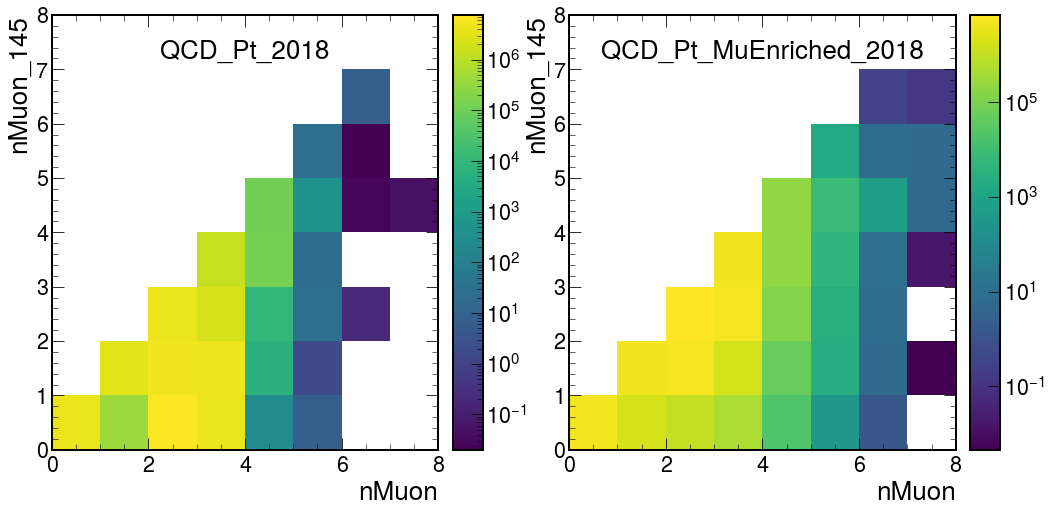

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(17,8))
hep.hist2dplot(
    plots['QCD_Pt_2018']['nMuon_keep_genflavor_all_vs_45_vs_145'][:8j, ::sum, :8j],
    norm=matplotlib.colors.LogNorm(),
    ax=ax1
)
ax1.text(4, 7.2, "QCD_Pt_2018", ha='center')
hep.hist2dplot(
    plots['QCD_Pt_MuEnriched_2018']['nMuon_keep_genflavor_all_vs_45_vs_145'][:8j, ::sum, :8j],
    norm=matplotlib.colors.LogNorm(),
    ax=ax2
)
ax2.text(4, 7.2, "QCD_Pt_MuEnriched_2018", ha='center')
plt.show()

12606404.40 ± 5346301.90
11647776.09 ± 207103.18


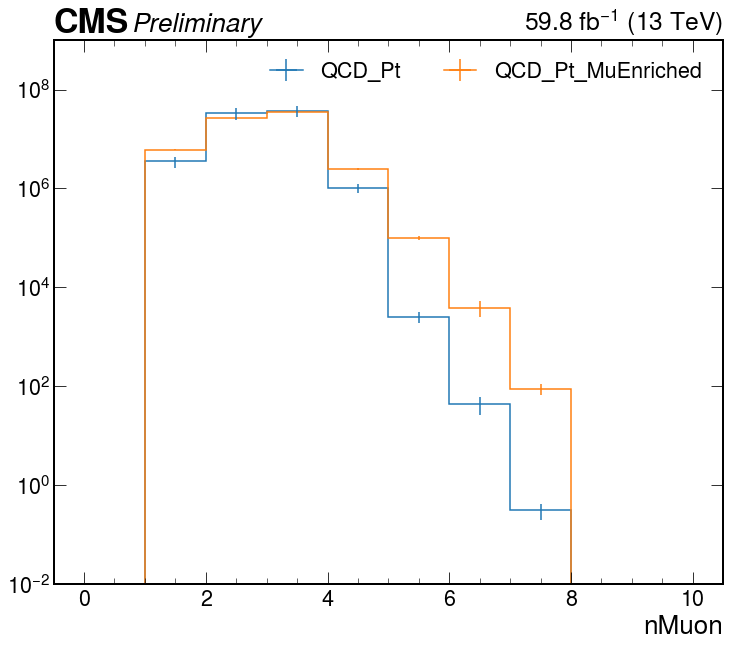

In [21]:
plot_labels = ['muon_pt_vs_nMuon']
year='2018'
decay='darkPho'

qcd_bin_1 = '470to600'
qcd_bin_2 = '470To600'

#samples_bkg = [
#    f'QCD_Pt_{qcd_bin_1}_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
#    f'QCD_Pt-{qcd_bin_2}_MuEnrichedPt5_TuneCP5_13TeV-pythia8_histograms_normalized_2018',
#]
samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018'
]
samples_signal = [
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

density = False
plot_signal = False

for plot_label in plot_labels:
    fig, ax = plt.subplots(figsize=(12, 10))
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    h_bkg = []
    for sample in samples_bkg: 
        h = plots[sample][plot_label][::sum, :]
        if density:
            h = h/h.sum().value
        h_bkg.append(h)
        print(f"{h.sum().value/6:.2f} ± {np.sqrt(h.sum().variance/6):.2f}")
    hep.histplot(
        h_bkg,
        yerr=[np.sqrt(h.variances()) for h in h_bkg], 
        label=[f'QCD_Pt',f'QCD_Pt_MuEnriched'], 
        stack=False,
        histtype='step',
    )

    for sample in samples_signal:
        if not plot_signal:
            continue
        h_temp = plots[sample][plot_label][:, 4j::sum]
        h = h_temp[::1j]
        if density: h = h/h.sum().value
        hep.histplot(
            h,
            yerr=np.sqrt(h.variances()), 
            label=sample, 
            color=plot_utils.default_colors[sample],
        )

    # tweak these by hand, as needed
    plt.ylim(1e-2, 1e9)
    #plt.setp(ax.get_xticklabels(), rotation=350)
    #plt.xlabel('cutflow')
    plt.legend(ncol=2)
    plt.yscale("log")
    plt.show()

169662.20 ± 79478.66
432565.09 ± 32700.44
9358.06 ± 112.84


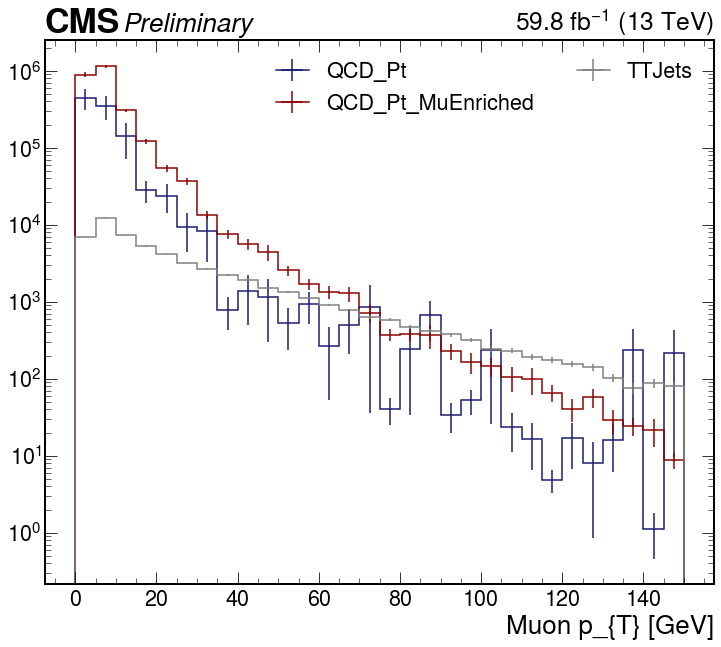

In [13]:
plot_labels = ['muon_pt_vs_nMuon']
year='2018'
decay='darkPho'

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    #'QCD_HT_2018',
    #'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    #'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
]
samples_signal = [
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

density = False
plot_signal = False

for plot_label in plot_labels:
    fig, ax = plt.subplots(figsize=(12, 10))
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    h_bkg = []
    for sample in samples_bkg: 
        h_temp = plots[sample][plot_label][:, ::sum]
        h = h_temp[::5j]
        if density:
            h = h/h.sum().value
        h_bkg.append(h)
        print(f"{h.sum().value/6:.2f} ± {np.sqrt(h.sum().variance/6):.2f}")
    hep.histplot(
        h_bkg,
        yerr=[np.sqrt(h.variances()) for h in h_bkg], 
        label=[s[:-5] for s in samples_bkg], 
        color=[plot_utils.default_colors[sample] for sample in samples_bkg],
        stack=False,
        histtype='step',
    )

    for sample in samples_signal:
        if not plot_signal:
            continue
        h_temp = plots[sample][plot_label][:, 4j::sum]
        h = h_temp[::1j]
        if density: h = h/h.sum().value
        hep.histplot(
            h,
            yerr=np.sqrt(h.variances()), 
            label=sample, 
            color=plot_utils.default_colors[sample],
        )

    # tweak these by hand, as needed
    #plt.ylim(1e-2, 1e9)
    #plt.setp(ax.get_xticklabels(), rotation=350)
    #plt.xlabel('cutflow')
    plt.legend(ncol=2)
    plt.yscale("log")
    plt.show()

7.33 ± 7.05
661.66 ± 571.72
18.44 ± 5.44


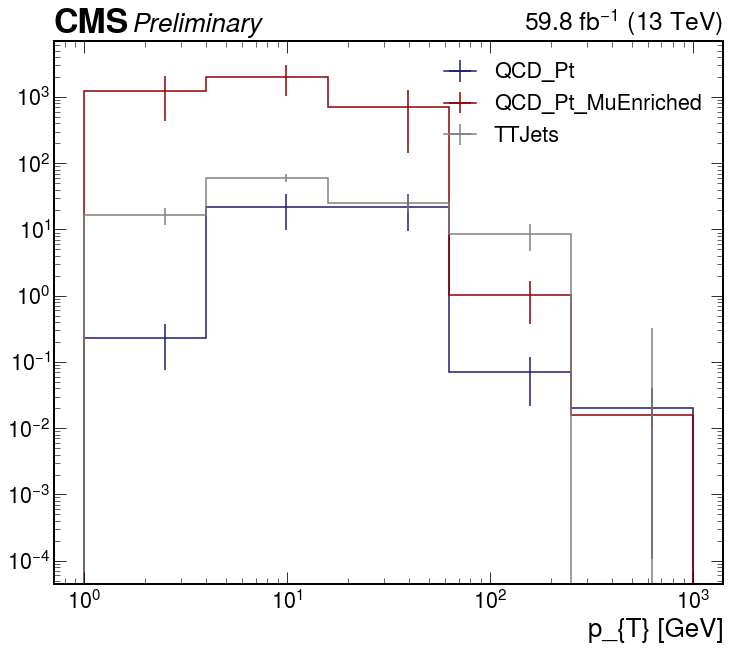

In [14]:
plot_labels = ['muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon']
year='2018'
decay='darkPho'

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    #'QCD_HT_2018',
    #'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    #'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
]
samples_signal = [
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

density = False
plot_signal = False

for plot_label in plot_labels:
    fig, ax = plt.subplots(figsize=(12, 10))
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    h_bkg = []
    for sample in samples_bkg: 
        h = plots[sample][plot_label][::10j, ::sum, ::sum, 6j::sum]
        if density:
            h = h/h.sum().value
        h_bkg.append(h)
        print(f"{h.sum().value/6:.2f} ± {np.sqrt(h.sum().variance/6):.2f}")
    hep.histplot(
        h_bkg,
        yerr=[np.sqrt(h.variances()) for h in h_bkg], 
        label=[s[:-5] for s in samples_bkg], 
        color=[plot_utils.default_colors[sample] for sample in samples_bkg],
        stack=False,
        histtype='step',
    )

    for sample in samples_signal:
        if not plot_signal:
            continue
        h_temp = plots[sample][plot_label][:, 4j::sum]
        h = h_temp[::1j]
        if density: h = h/h.sum().value
        hep.histplot(
            h,
            yerr=np.sqrt(h.variances()), 
            label=sample, 
            color=plot_utils.default_colors[sample],
        )

    # tweak these by hand, as needed
    #plt.ylim(1e-2, 1e9)
    #plt.setp(ax.get_xticklabels(), rotation=350)
    #plt.xlabel('cutflow')
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

5522496.92 ± 2292950.79
5252237.09 ± 102334.96


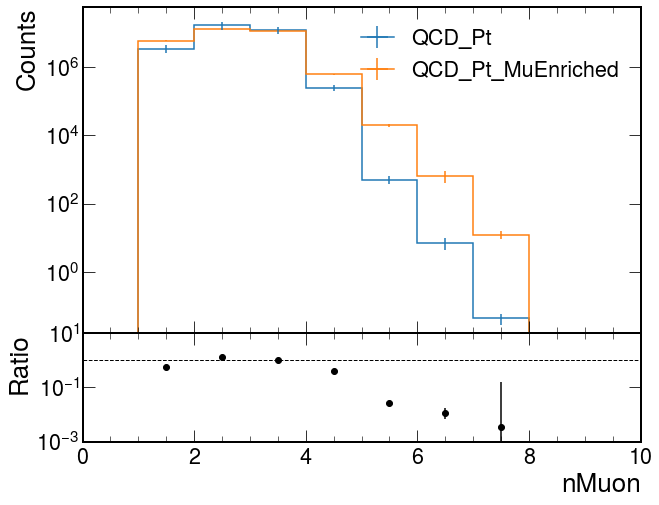

In [56]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'
density = False

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
]

h_bkg = []
for sample in samples_bkg:
    h = convert_permuon_to_perevent(plots[sample][plot_label][::sum, ::sum, ::sum, :])
    if density:
        h = h/h.sum().value
    h_bkg.append(h)
    print(f"{h.sum().value/6:.2f} ± {np.sqrt(h.sum().variance/6):.2f}")
    
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h_bkg[0].plot_ratio(
    h_bkg[1],
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
fig.axes[1].set_yscale("log")
fig.axes[1].set_ylim(1e-3, 1e1)
#fig.axes[0].text(2, 1, r"$p^{\mu}_{T}\geq50\,$GeV")

"""
fig, ax = plt.subplots(figsize=(12, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
hep.histplot(
    h_bkg,
    yerr=[np.sqrt(h.variances()) for h in h_bkg], 
    label=[s[:-5] for s in samples_bkg], 
    color=[plot_utils.default_colors[sample] for sample in samples_bkg],
    stack=False,
    histtype='step',
)
plt.legend()
"""

plt.show()

Now try to remove the "light" muons from MuEnriched

In [57]:
h = plots['QCD_Pt_MuEnriched_2018']['muon_pdgId_parentId_genFlav_nMuon'][:, :, ::sum, :]

In [60]:
h[::sum, 0, :]

Hist(Regular(10, 0, 10, name='nMuon', label='nMuon'), storage=Weight()) # Sum: WeightedSum(value=1.00282e+07, variance=2.00557e+10)

12602747.22 ± 5346300.48
9976403.97 ± 198869.57


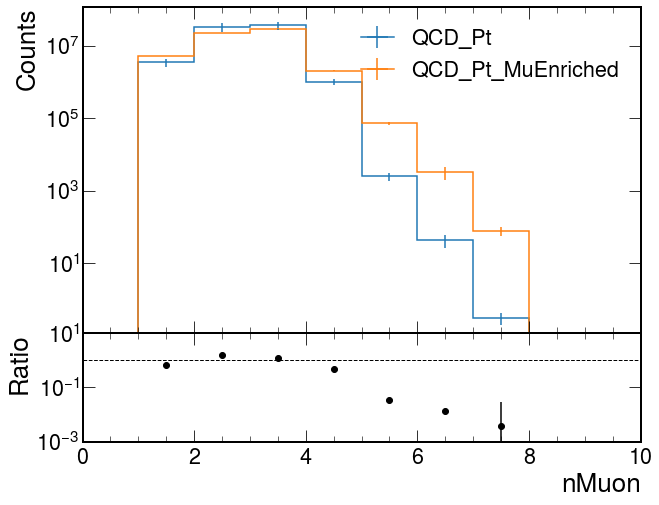

In [72]:
plot_label = 'muon_pdgId_parentId_genFlav_nMuon'
year='2018'
decay='darkPho'
density = False

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
]

h_bkg = []
for sample in samples_bkg:
    h = plots[sample][plot_label][::sum, :, ::sum, :]
    h_new = h[::sum, :].copy()
    h_new.empty()
    for i in range(h[::sum, :].axes[0].size):
        #h_new[i] = (h[::sum, i].value - h[0, i].value, h[::sum, i].variance - h[0, i].variance)
        h_new[i] = (h[::sum, i].value - h[-1j, i].value, h[::sum, i].variance - h[-1j, i].variance)
    if density:
        h = h/h.sum().value
    h_bkg.append(h_new)
    print(f"{h_new.sum().value/6:.2f} ± {np.sqrt(h_new.sum().variance/6):.2f}")
    
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h_bkg[0].plot_ratio(
    h_bkg[1],
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
fig.axes[1].set_yscale("log")
fig.axes[1].set_ylim(1e-3, 1e1)
#fig.axes[0].text(2, 1, r"$p^{\mu}_{T}\geq50\,$GeV")

"""
fig, ax = plt.subplots(figsize=(12, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
hep.histplot(
    h_bkg,
    yerr=[np.sqrt(h.variances()) for h in h_bkg], 
    label=[s[:-5] for s in samples_bkg], 
    color=[plot_utils.default_colors[sample] for sample in samples_bkg],
    stack=False,
    histtype='step',
)
plt.legend()
"""

plt.show()

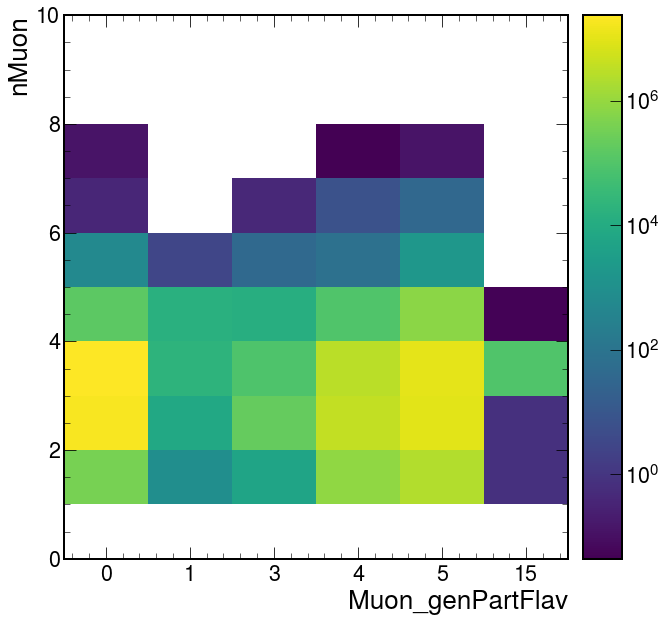

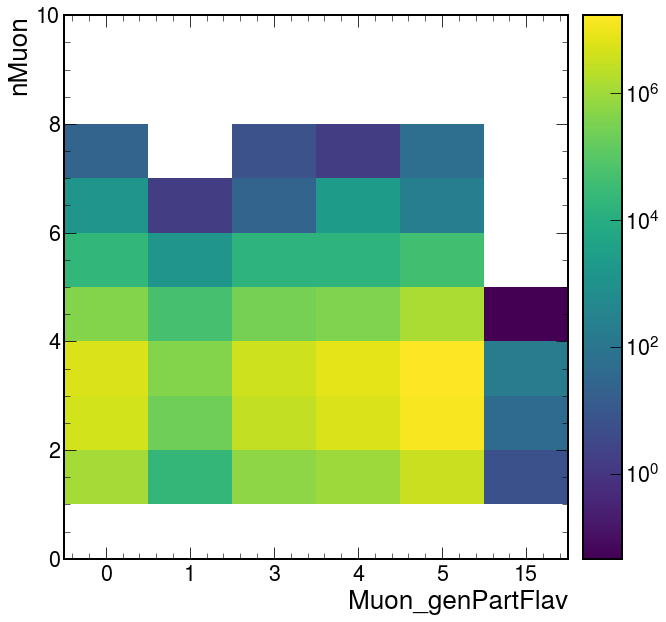

In [19]:
hep.hist2dplot(
    plots['QCD_Pt_2018'][plot_label][::sum, ::sum, :, :],
    norm=matplotlib.colors.LogNorm(),
)
plt.show()
hep.hist2dplot(
    plots['QCD_Pt_MuEnriched_2018'][plot_label][::sum, ::sum, :, :],
    norm=matplotlib.colors.LogNorm(),
)
plt.show()

10371866.87 ± 195887.85


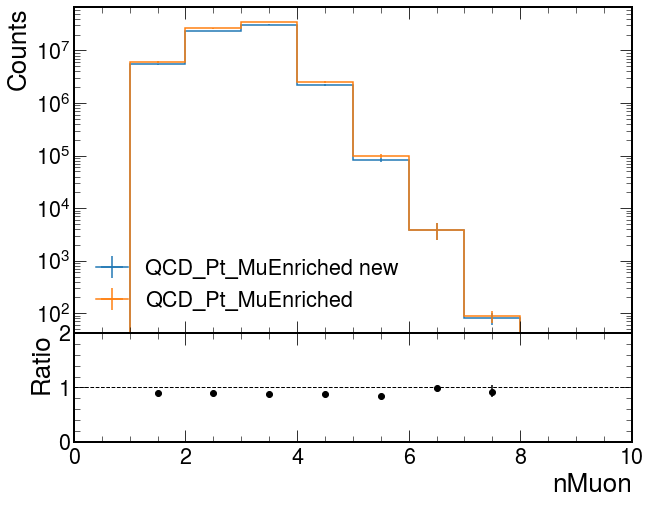

In [26]:
plot_label = 'muon_pdgId_parentId_genFlav_nMuon'
year='2018'
decay='darkPho'
density = False

samples_bkg = ['QCD_Pt_2018']

h_mu = plots['QCD_Pt_MuEnriched_2018'][plot_label][::sum, ::sum, :, :]
h_mu_new = h_mu[::sum, :].copy()
for i in range(h_mu[::sum, :].axes[0].size):
    #h_mu_new[i] = (h_mu_new[i].value - h_mu[1j, i].value, h_mu_new[i].variance - h_mu[1j, i].variance)
    h_mu_new[i] = (h_mu_new[i].value - h_mu[3j, i].value, h_mu_new[i].variance - h_mu[3j, i].variance)
print(f"{h_mu_new.sum().value/6:.2f} ± {np.sqrt(h_mu_new.sum().variance/6):.2f}")
    
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h_mu_new.plot_ratio(
    h_mu[::sum, :],
    rp_num_label=r'QCD_Pt_MuEnriched new',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
#fig.axes[1].set_yscale("log")
#fig.axes[1].set_ylim(1e-3, 1e1)
fig.axes[1].set_ylim(0, 2)

plt.show()

In [28]:
import awkward as ak
arr = ak.Array([[1,3,1,2],[4,3,2,6],[1,3,5,4,3]])

In [34]:
(arr != 1) & (arr != 3)

<Array [[False, False, False, ... True, False]] type='3 * var * bool'>

In [14]:
for i, i_c in enumerate(h):
    if i > 0:
        i_c.value = i_c.value / i
        i_c.variance = i_c.variance / i
    print(i, i_c)

0 WeightedSum(value=0, variance=0)


AttributeError: can't set attribute

In [36]:
new = convert_permuon_to_perevent(h)

In [40]:
new [6j::sum]

WeightedSum(value=659.59, variance=54473.8)

In [41]:
h[6j::sum]

WeightedSum(value=3969.98, variance=1.96118e+06)

12606404.36 ± 5346301.90
11647776.08 ± 207103.18


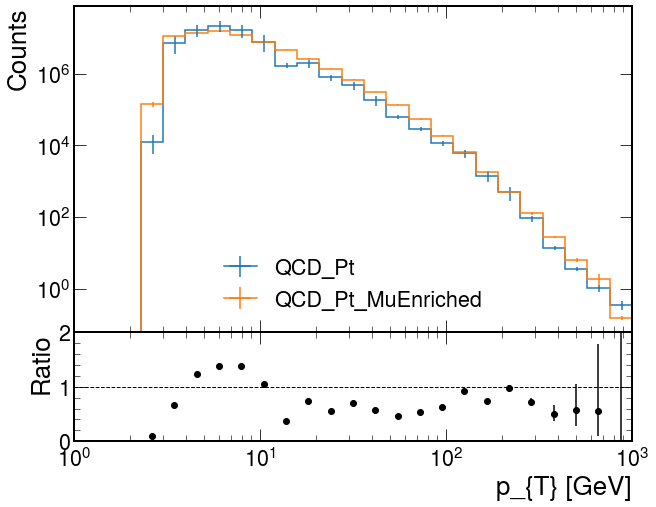

In [8]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'
density = False

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
]

h_bkg = []
for sample in samples_bkg:
    h = plots[sample][plot_label][::2j, ::sum, ::sum, ::sum]
    if density:
        h = h/h.sum().value
    h_bkg.append(h)
    print(f"{h.sum().value/6:.2f} ± {np.sqrt(h.sum().variance/6):.2f}")
    
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h_bkg[0].plot_ratio(
    h_bkg[1],
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_xscale("log")
fig.axes[0].set_yscale("log")
fig.axes[1].set_ylim(0, 2)
#fig.axes[1].set_yscale("log")
#fig.axes[1].set_ylim(1e-2, 1e1)



"""
fig, ax = plt.subplots(figsize=(12, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
hep.histplot(
    h_bkg,
    yerr=[np.sqrt(h.variances()) for h in h_bkg], 
    label=[s[:-5] for s in samples_bkg], 
    color=[plot_utils.default_colors[sample] for sample in samples_bkg],
    stack=False,
    histtype='step',
)
plt.legend()
"""

plt.show()

9091322.40 ± 4370139.19
9277015.78 ± 172643.88


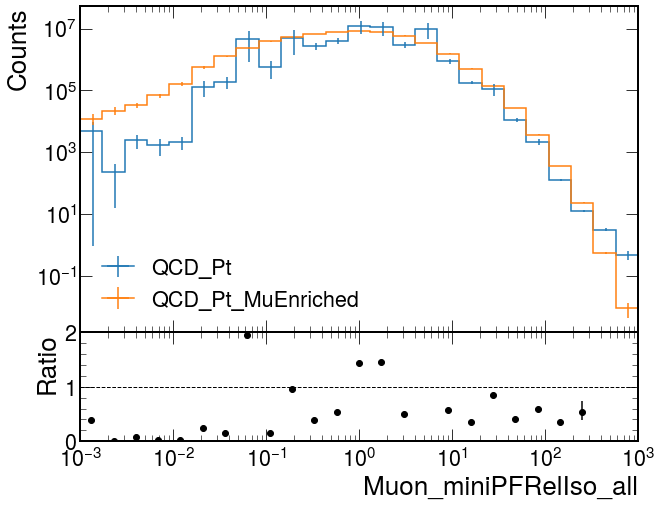

In [9]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'
density = False

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
]

h_bkg = []
for sample in samples_bkg:
    h = plots[sample][plot_label][::sum, ::2j, ::sum, ::sum]
    if density:
        h = h/h.sum().value
    h_bkg.append(h)
    print(f"{h.sum().value/6:.2f} ± {np.sqrt(h.sum().variance/6):.2f}")
    
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h_bkg[0].plot_ratio(
    h_bkg[1],
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_xscale("log")
fig.axes[0].set_yscale("log")
fig.axes[1].set_ylim(0, 2)
#fig.axes[1].set_yscale("log")
#fig.axes[1].set_ylim(1e-2, 1e1)



"""
fig, ax = plt.subplots(figsize=(12, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
hep.histplot(
    h_bkg,
    yerr=[np.sqrt(h.variances()) for h in h_bkg], 
    label=[s[:-5] for s in samples_bkg], 
    color=[plot_utils.default_colors[sample] for sample in samples_bkg],
    stack=False,
    histtype='step',
)
plt.legend()
"""

plt.show()

423.63 ± 270.63
16501.47 ± 3567.71


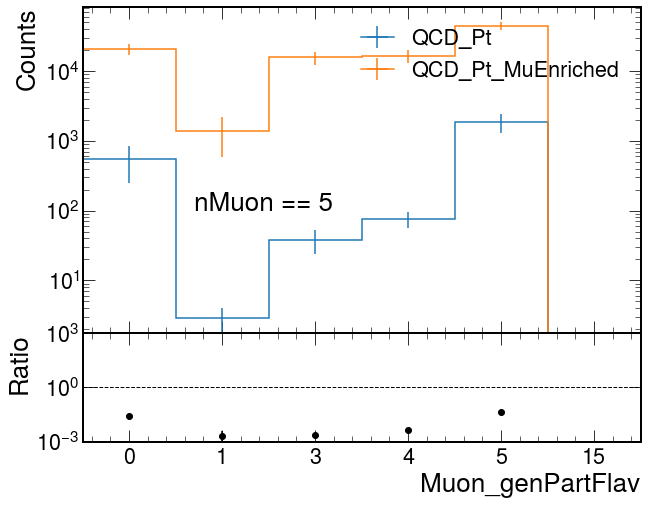

In [49]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'
density = False

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
]

h_bkg = []
for sample in samples_bkg:
    h = plots[sample][plot_label][::sum, ::sum, :, 5]
    if density:
        h = h/h.sum().value
    h_bkg.append(h)
    print(f"{h.sum().value/6:.2f} ± {np.sqrt(h.sum().variance/6):.2f}")
    
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h_bkg[0].plot_ratio(
    h_bkg[1],
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
fig.axes[1].set_ylim(0, 2)
fig.axes[1].set_yscale("log")
fig.axes[1].set_ylim(1e-3, 1e3)
fig.axes[0].text(1.2, 100, "nMuon == 5")



"""
fig, ax = plt.subplots(figsize=(12, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
hep.histplot(
    h_bkg,
    yerr=[np.sqrt(h.variances()) for h in h_bkg], 
    label=[s[:-5] for s in samples_bkg], 
    color=[plot_utils.default_colors[sample] for sample in samples_bkg],
    stack=False,
    histtype='step',
)
plt.legend()
"""

plt.show()

12436737.85 ± 5345711.10
11215187.50 ± 204505.27


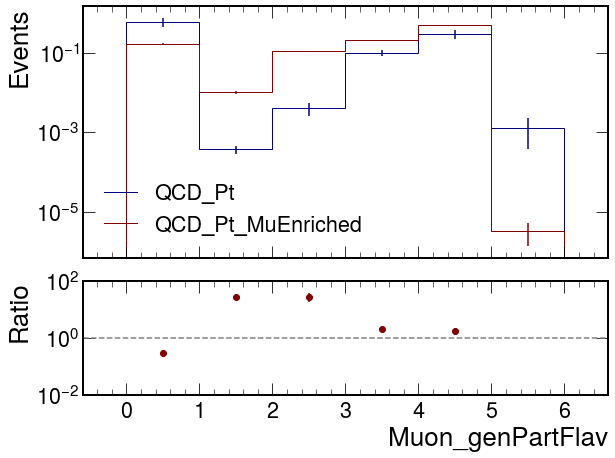

In [21]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'
density = True

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
]

h_bkg = []
for sample in samples_bkg:
    h = plots[sample][plot_label][::sum, ::sum, :, 0j:4j:sum]
    h_bkg.append(h)
    print(f"{h.sum().value/6:.2f} ± {np.sqrt(h.sum().variance/6):.2f}")

fig, (ax1, ax2) = plot_utils.plot_ratio(
    [h_bkg[0], h_bkg[1]],
    labels=['QCD_Pt', 'QCD_Pt_MuEnriched'],
    density=density
)

ax2.set_yscale('log')
ax2.set_ylim(1e-2, 1e2)
#fig.axes[0].set_yscale("log")
#fig.axes[1].set_ylim(0, 2)
#fig.axes[1].set_yscale("log")
#fig.axes[1].set_ylim(1e-3, 1e3)



"""
fig, ax = plt.subplots(figsize=(12, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
hep.histplot(
    h_bkg,
    yerr=[np.sqrt(h.variances()) for h in h_bkg], 
    label=[s[:-5] for s in samples_bkg], 
    color=[plot_utils.default_colors[sample] for sample in samples_bkg],
    stack=False,
    histtype='step',
)
plt.legend()
"""

plt.show()

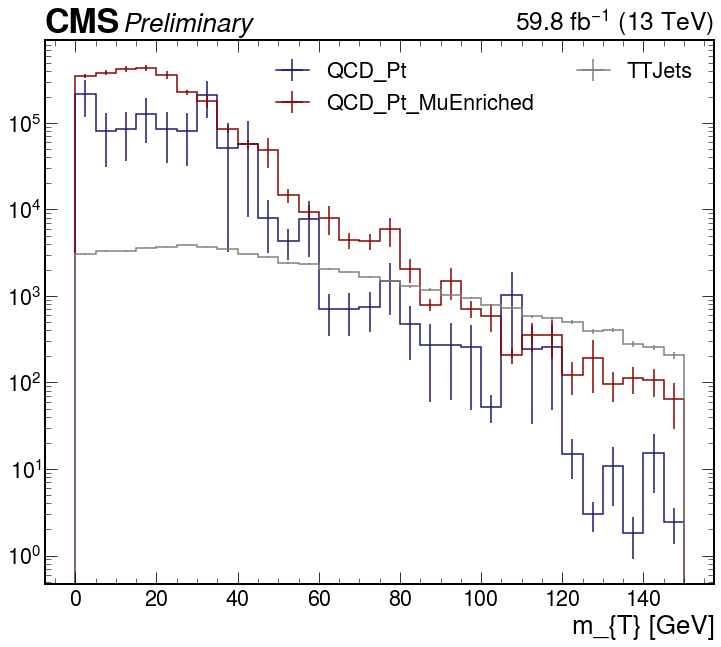

In [16]:
plot_labels = ['muon_mt_vs_nMuon']
year='2018'
decay='darkPho'

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    #'QCD_HT_2018',
    #'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    #'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
]
samples_signal = [
    #f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    #f'SUEP-m1000-{decay}_2018',
]

density = False
plot_signal = False

for plot_label in plot_labels:
    fig, ax = plt.subplots(figsize=(12, 10))
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    h_bkg = []
    for sample in samples_bkg: 
        h_temp = plots[sample][plot_label][:,4j::sum]
        h = h_temp[::5j]
        if density:
            h = h/h.sum().value
        h_bkg.append(h)
    hep.histplot(
        h_bkg,
        yerr=[np.sqrt(h.variances()) for h in h_bkg], 
        label=[s[:-5] for s in samples_bkg], 
        color=[plot_utils.default_colors[sample] for sample in samples_bkg],
        stack=False,
        histtype='step',
    )

    for sample in samples_signal:
        if not plot_signal:
            continue
        h_temp = plots[sample][plot_label][:,4j::sum]
        h = h_temp[::5j]
        if density: h = h/h.sum().value
        hep.histplot(
            h,
            yerr=np.sqrt(h.variances()), 
            label=sample, 
            color=plot_utils.default_colors[sample],
        )

    # tweak these by hand, as needed
    #plt.ylim(1e-2, 1e9)
    #plt.setp(ax.get_xticklabels(), rotation=350)
    #plt.xlabel('cutflow')
    plt.legend(ncol=2)
    plt.yscale("log")
    plt.show()

5522496.92 ± 2292950.79
5252237.09 ± 102334.96


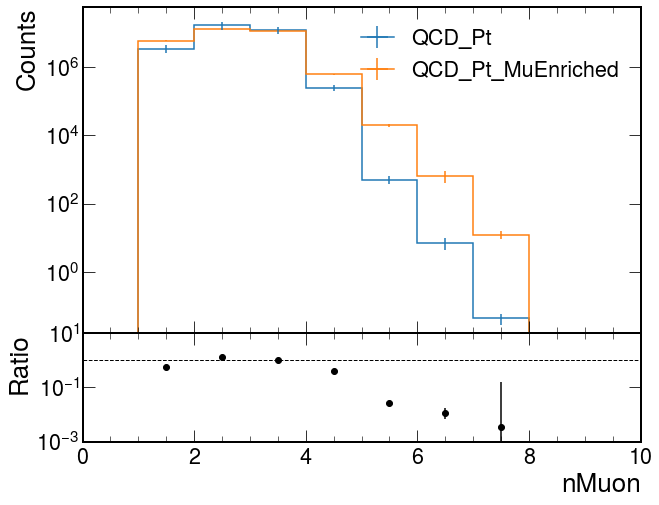

In [22]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'
density = False

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
]

h_bkg = []
for sample in samples_bkg:
    h = convert_permuon_to_perevent(plots[sample][plot_label][3j::sum, ::sum, ::sum, :])
    if density:
        h = h/h.sum().value
    h_bkg.append(h)
    print(f"{h.sum().value/6:.2f} ± {np.sqrt(h.sum().variance/6):.2f}")
    
fig = plt.figure(figsize=(10, 8))
main_ax_artists, sublot_ax_arists = h_bkg[0].plot_ratio(
    h_bkg[1],
    rp_num_label=r'QCD_Pt',
    rp_denom_label='QCD_Pt_MuEnriched'
)
fig.axes[0].set_yscale("log")
fig.axes[1].set_yscale("log")
fig.axes[1].set_ylim(1e-3, 1e1)

fig.subplots_adjust(hspace=0.5)

"""
fig, ax = plt.subplots(figsize=(12, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
hep.histplot(
    h_bkg,
    yerr=[np.sqrt(h.variances()) for h in h_bkg], 
    label=[s[:-5] for s in samples_bkg], 
    color=[plot_utils.default_colors[sample] for sample in samples_bkg],
    stack=False,
    histtype='step',
)
plt.legend()
"""

plt.show()

### Now the 2D plots

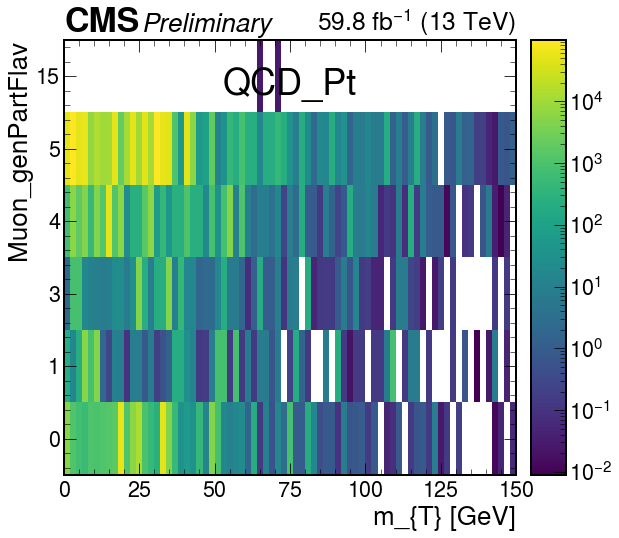

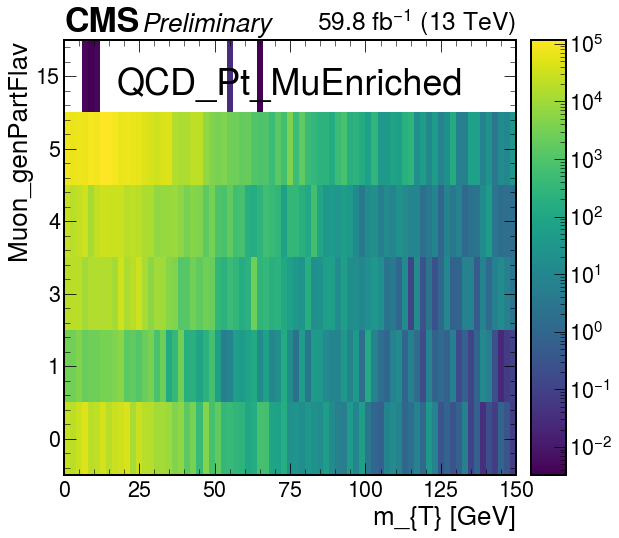

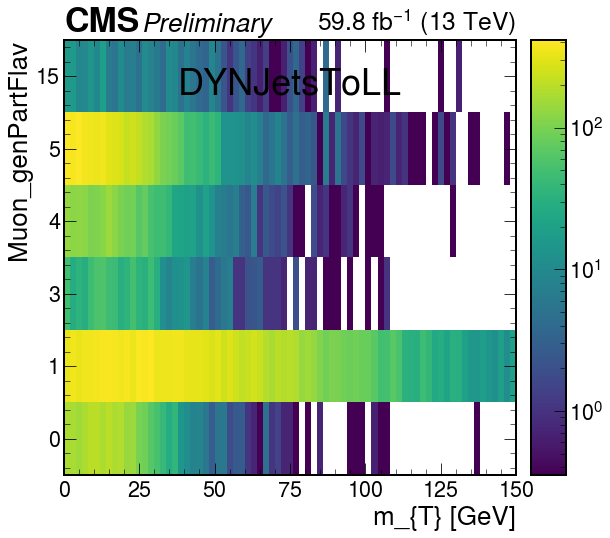

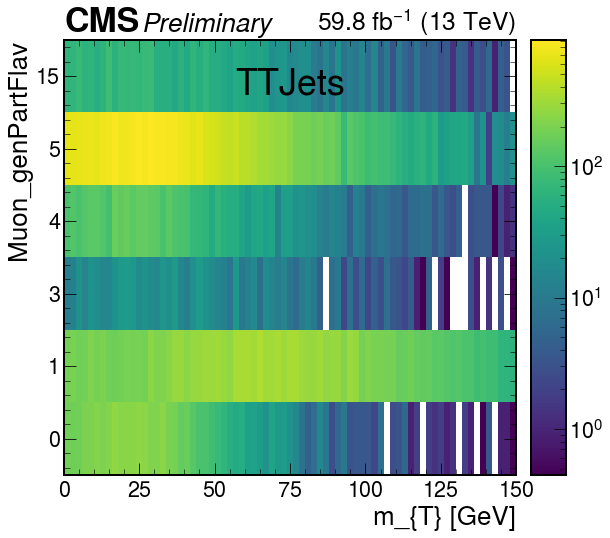

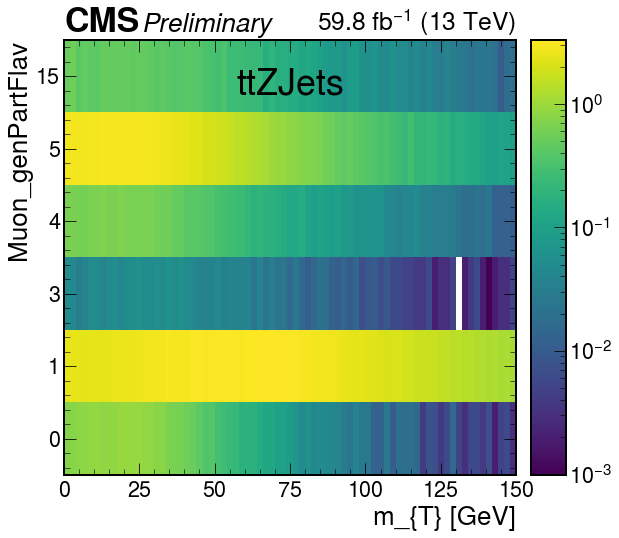

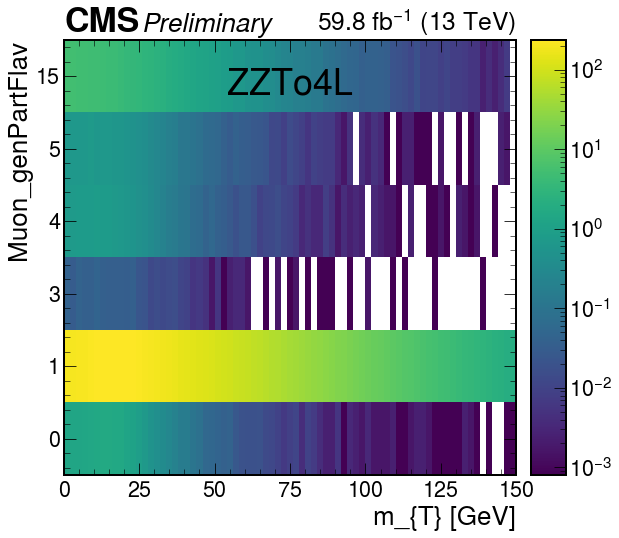

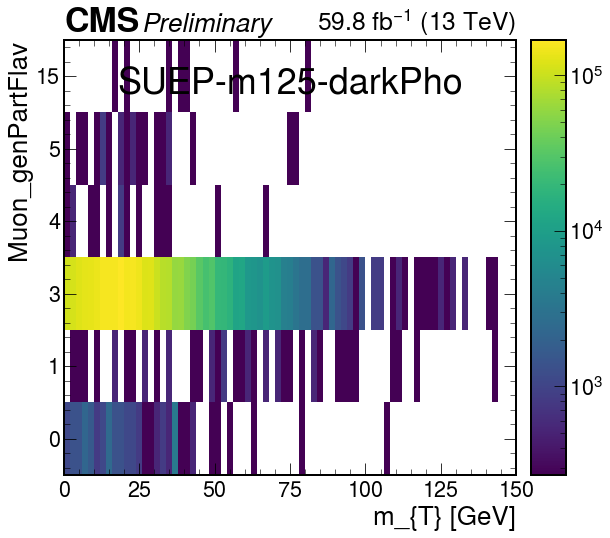

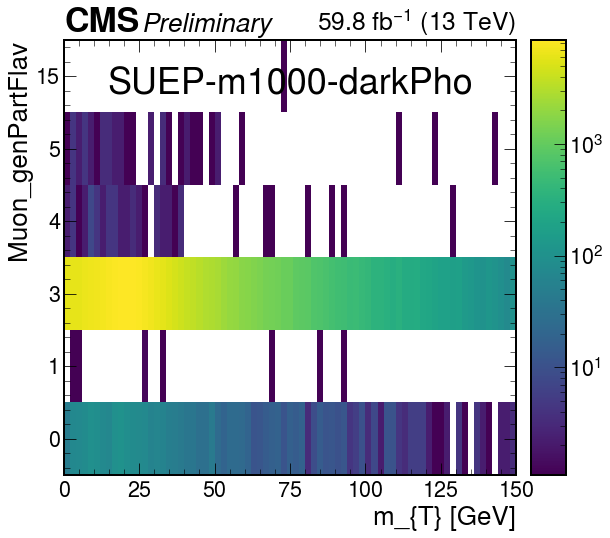

In [66]:
plot_label = 'muon_mt_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][::2j, :, 4j::sum]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(75, 5.25,sample.strip('_2018'), fontsize=36, ha='center')
    plt.show()

WeightedSum(value=1.018e+06, variance=3.79011e+10)


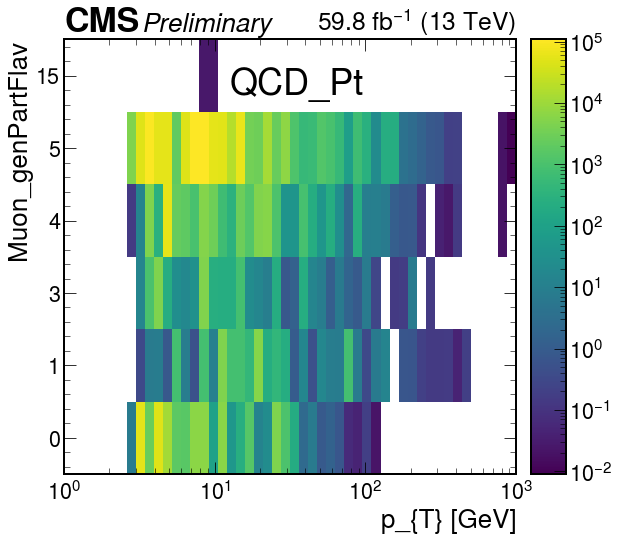

WeightedSum(value=2.59553e+06, variance=6.41591e+09)


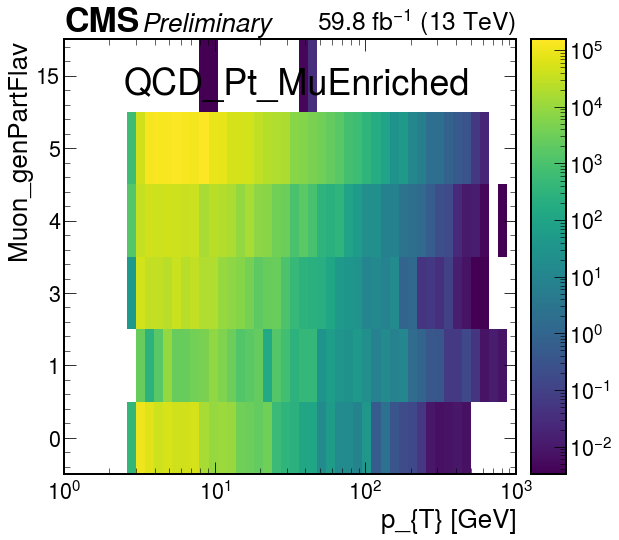

WeightedSum(value=25033.3, variance=36439.6)


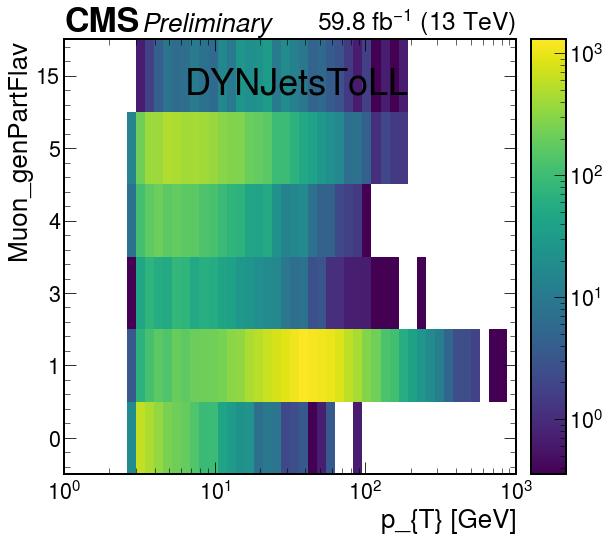

WeightedSum(value=56691.4, variance=77230.2)


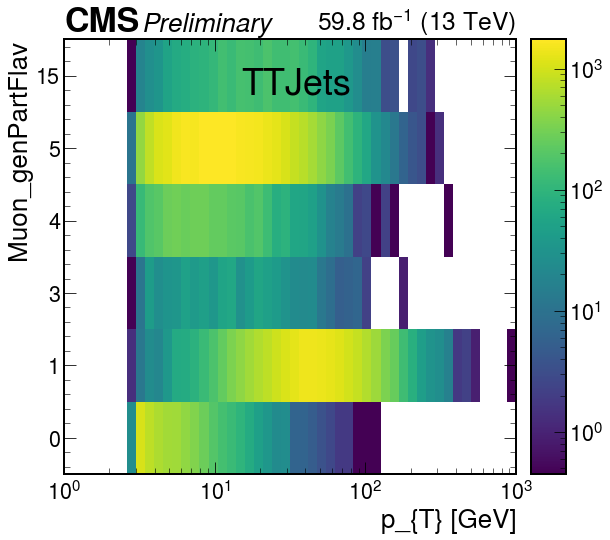

WeightedSum(value=385.293, variance=0.379999)


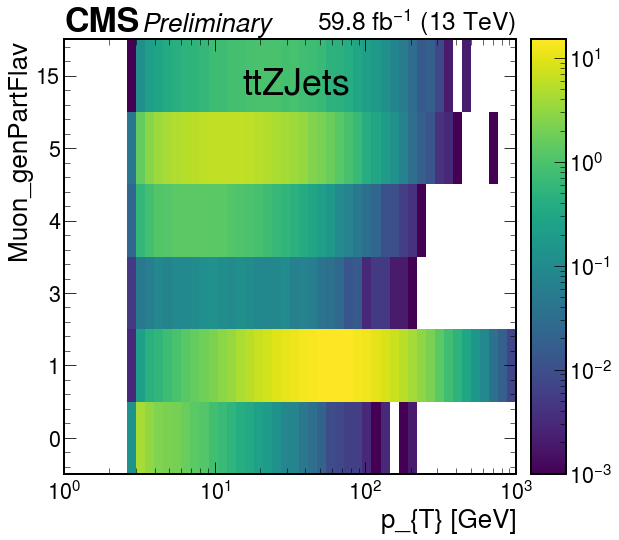

WeightedSum(value=6347.13, variance=5.16443)


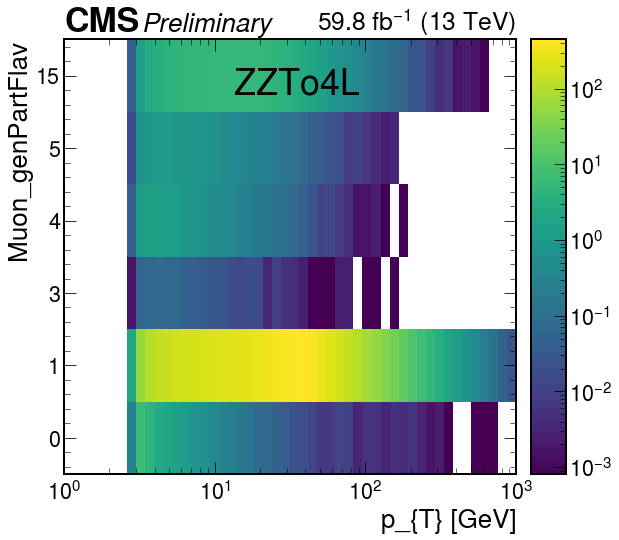

WeightedSum(value=2.85236e+06, variance=8.15105e+08)


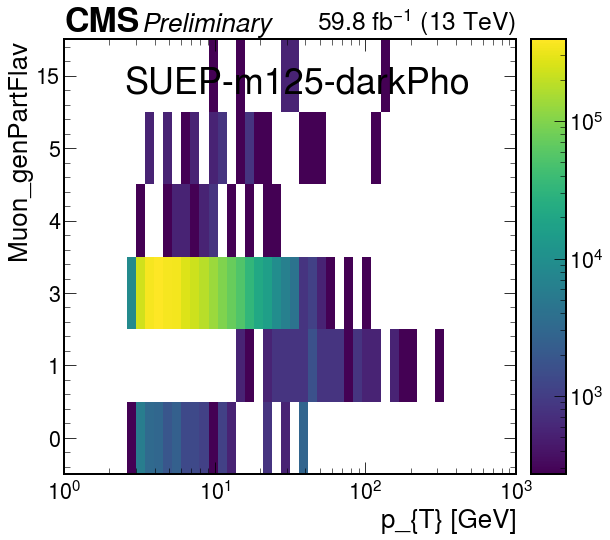

WeightedSum(value=191232, variance=211177)


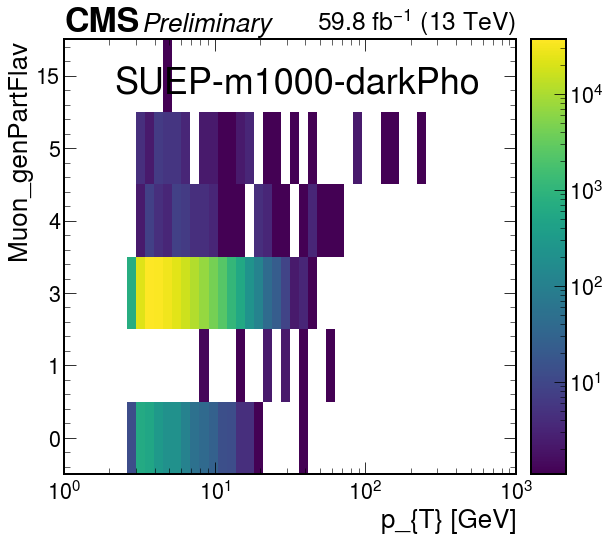

In [59]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][:, ::sum, :, ::sum]
    print(h_temp.sum())
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(35, 5.25,sample.strip('_2018'), fontsize=36, ha='center')
    plt.xscale('log')
    plt.show()

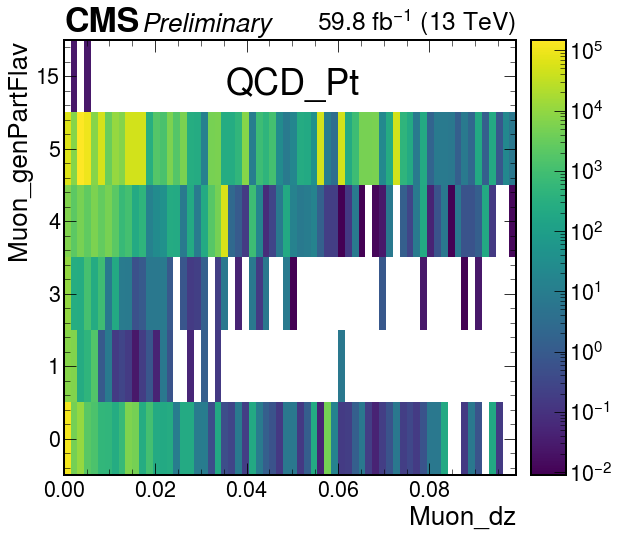

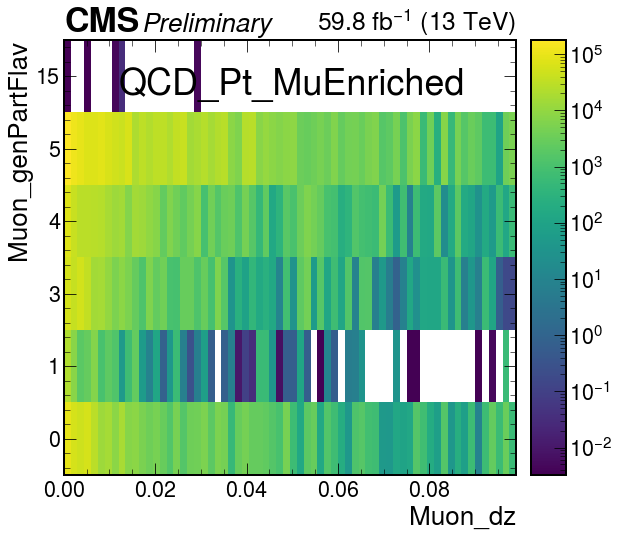

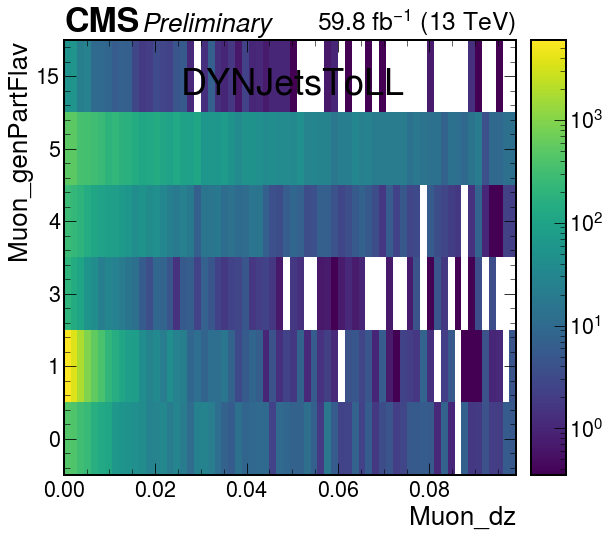

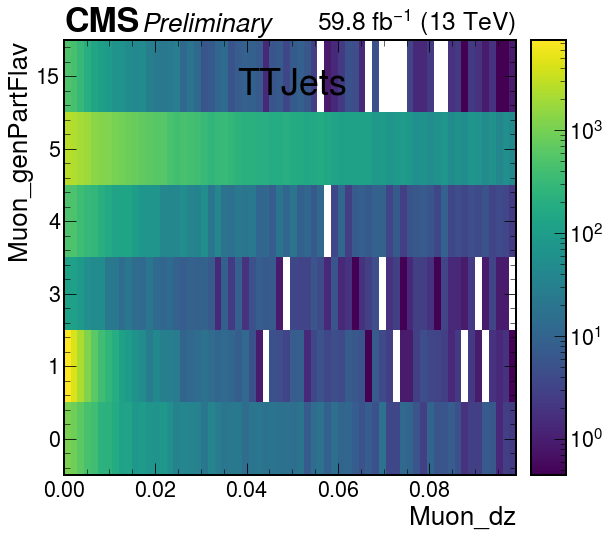

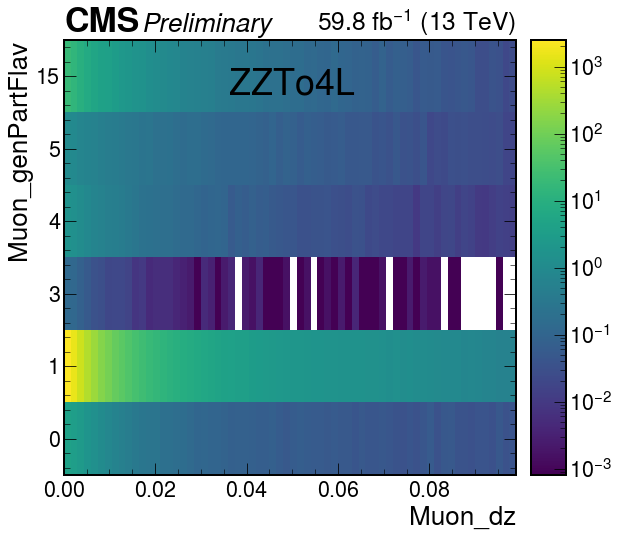

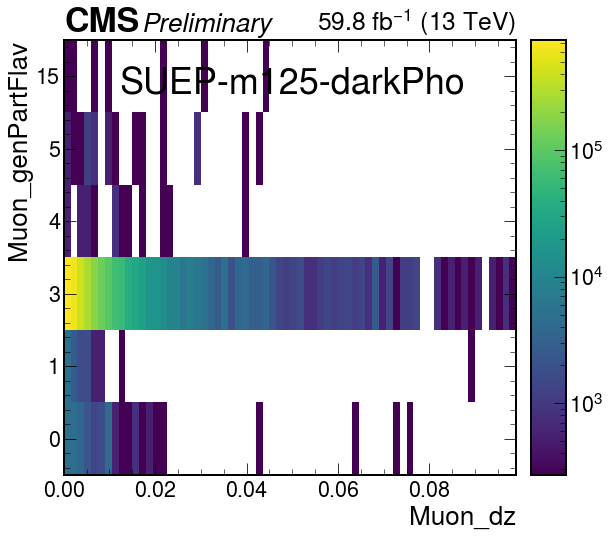

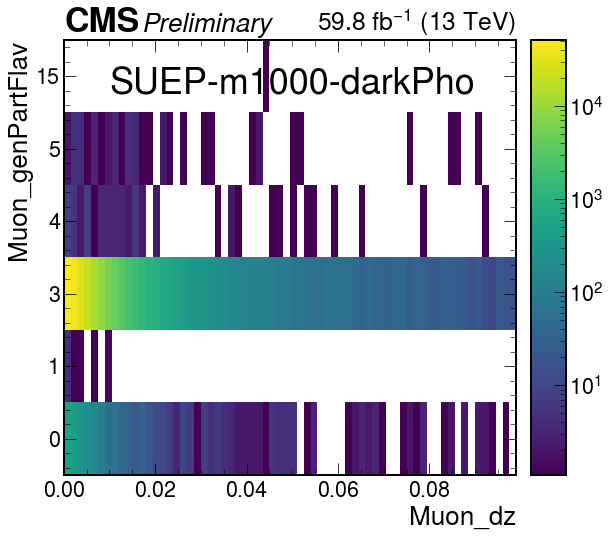

In [71]:
plot_label = 'muon_dz_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][::3j,:,::sum]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(0.05, 5.25,sample.strip('_2018'), fontsize=36, ha='center')
    plt.show()

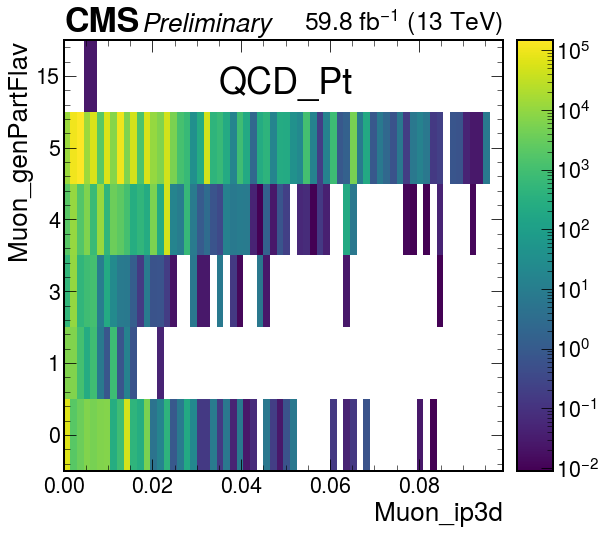

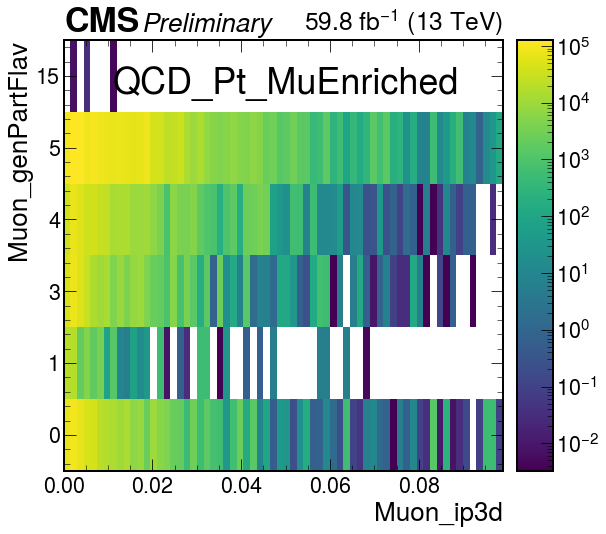

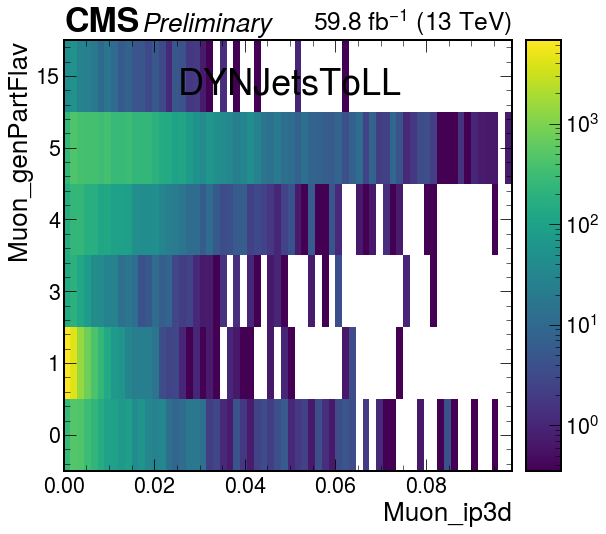

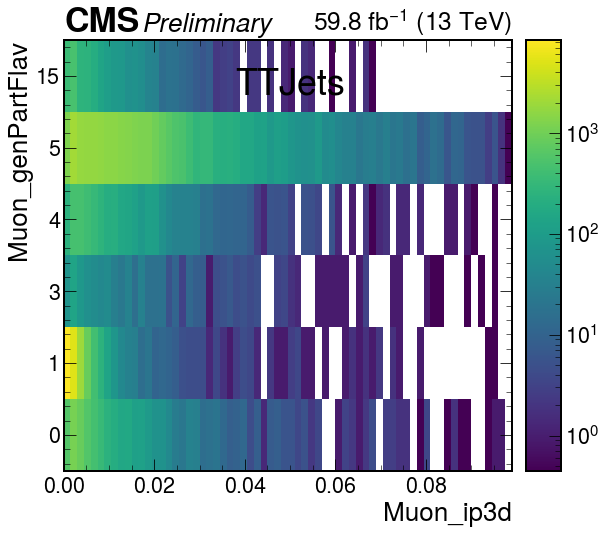

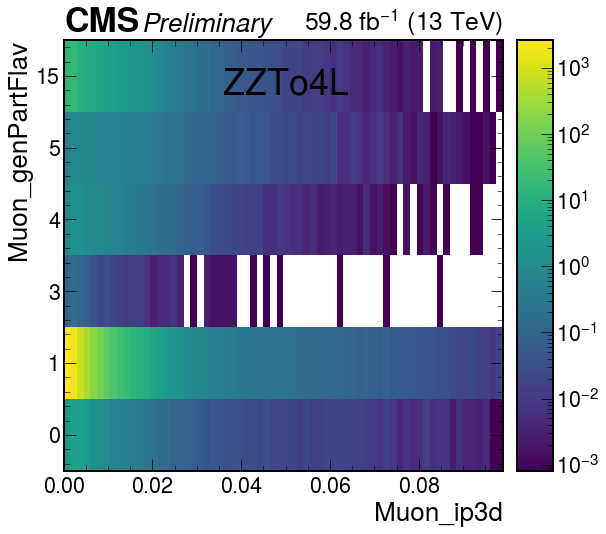

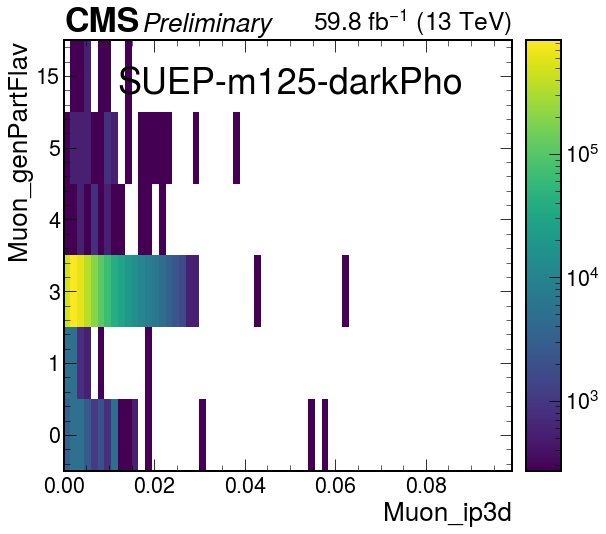

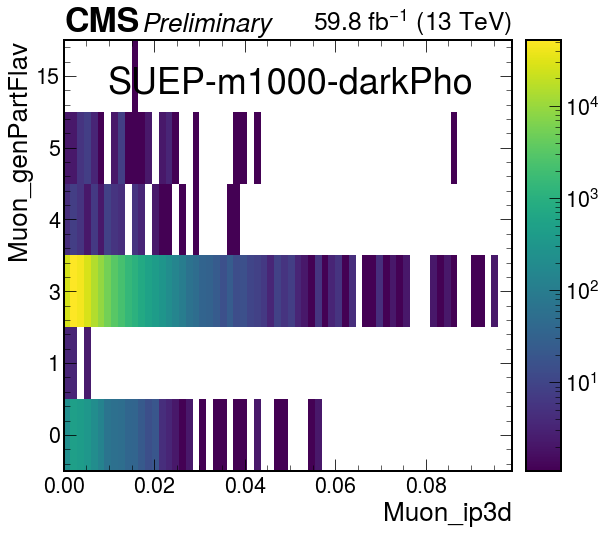

In [72]:
plot_label = 'muon_ip3d_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][::3j,:,::sum]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(0.05, 5.25,sample.strip('_2018'), fontsize=36, ha='center')
    plt.show()

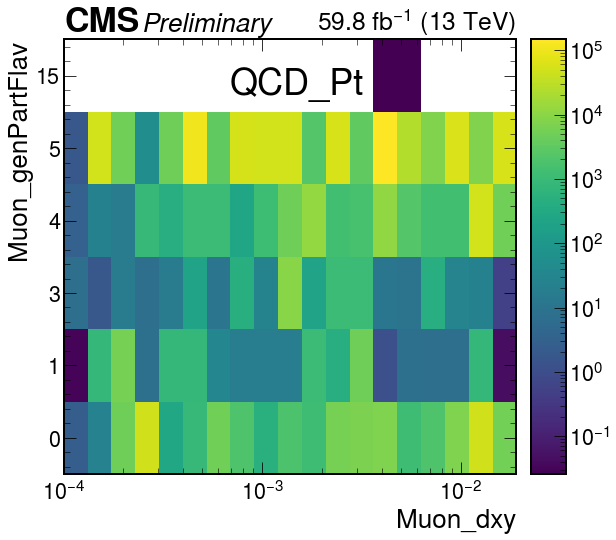

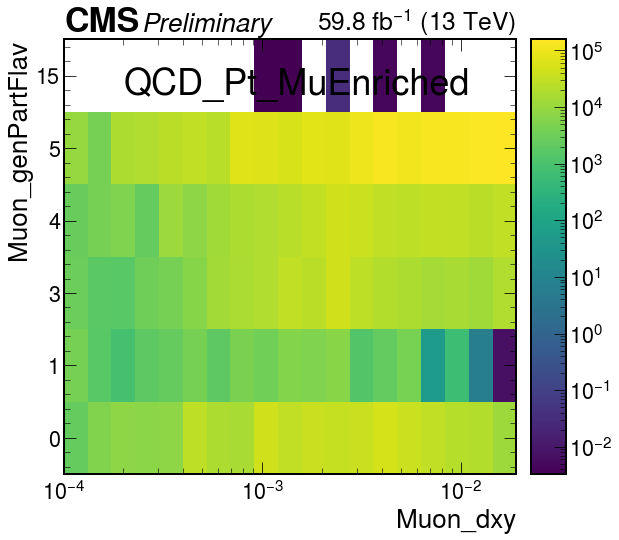

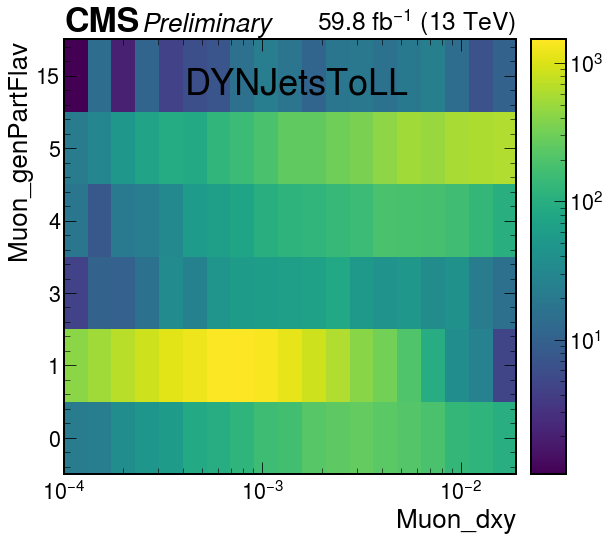

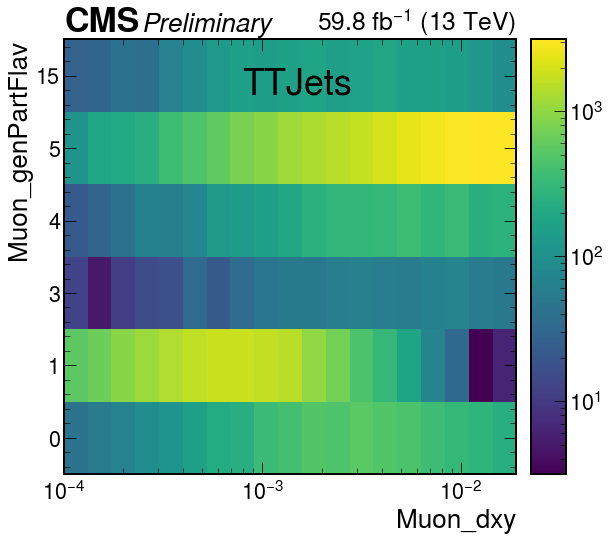

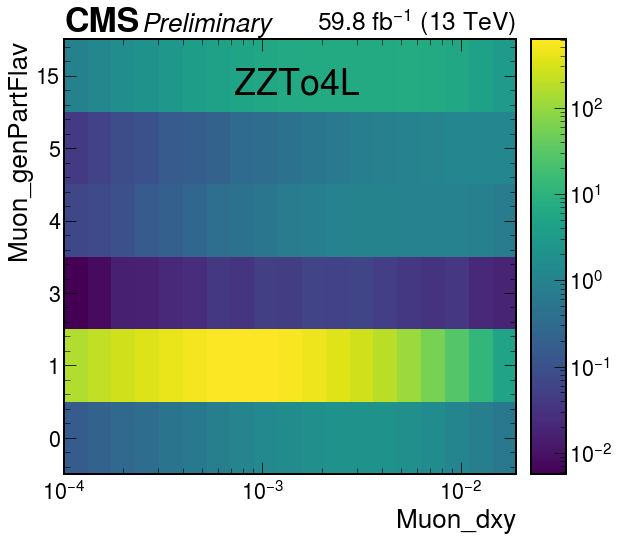

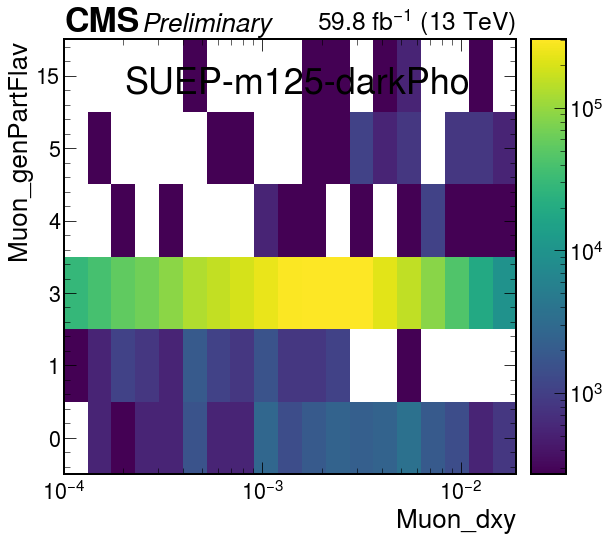

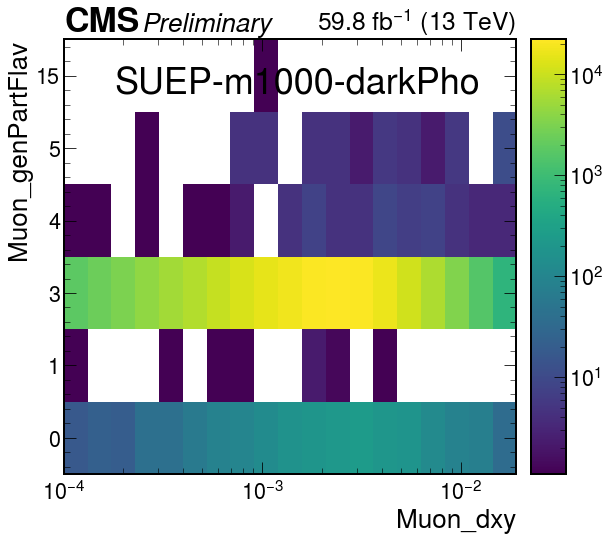

In [75]:
plot_label = 'muon_dxy_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][:0.02j,::sum,:,::sum]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(0.0015, 5.25,sample.strip('_2018'), fontsize=36, ha='center')
    plt.xscale('log')
    plt.show()

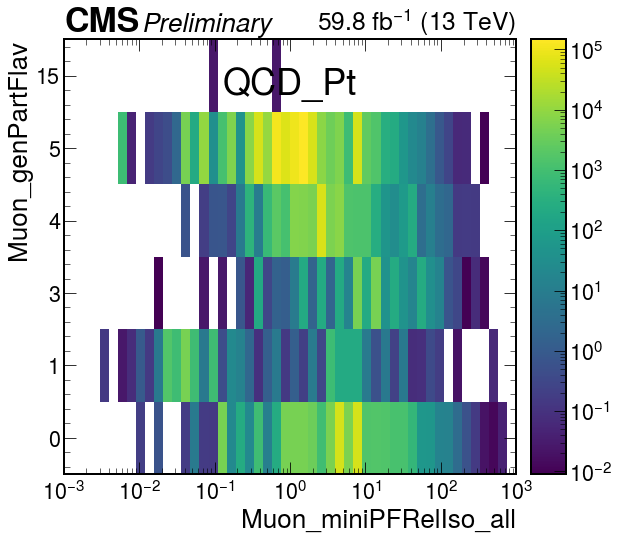

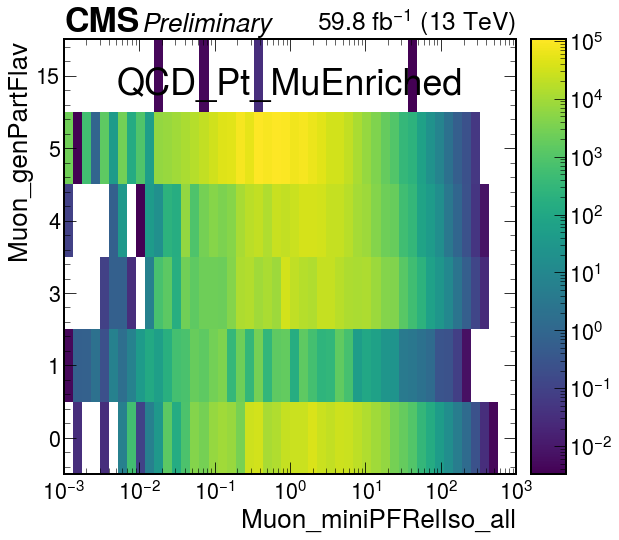

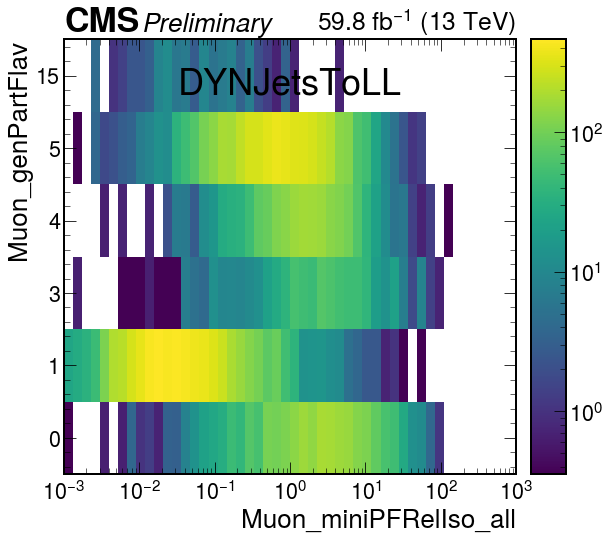

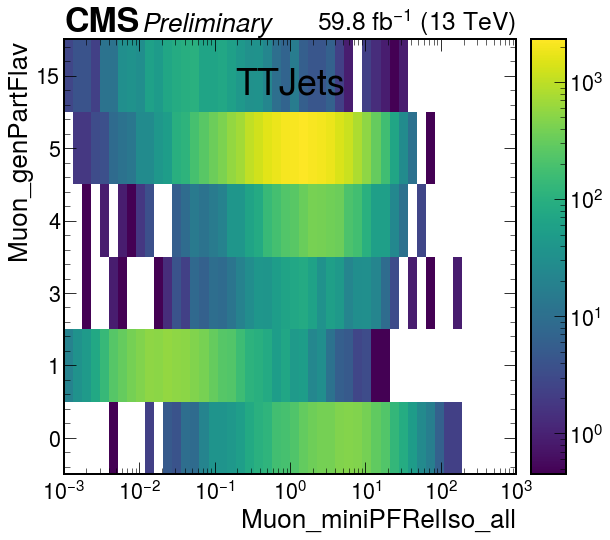

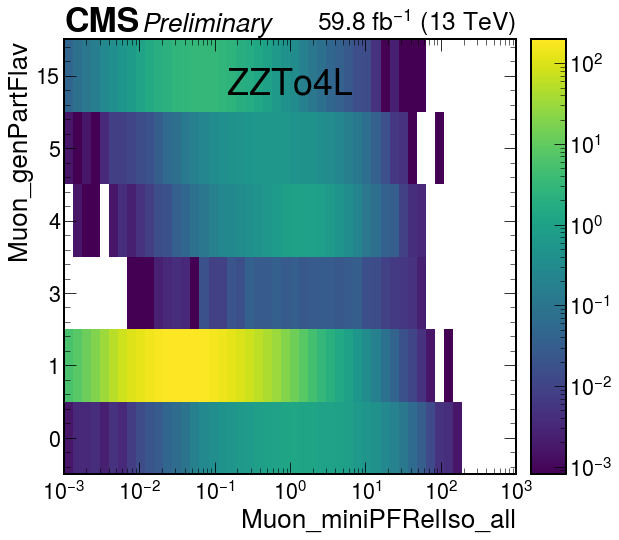

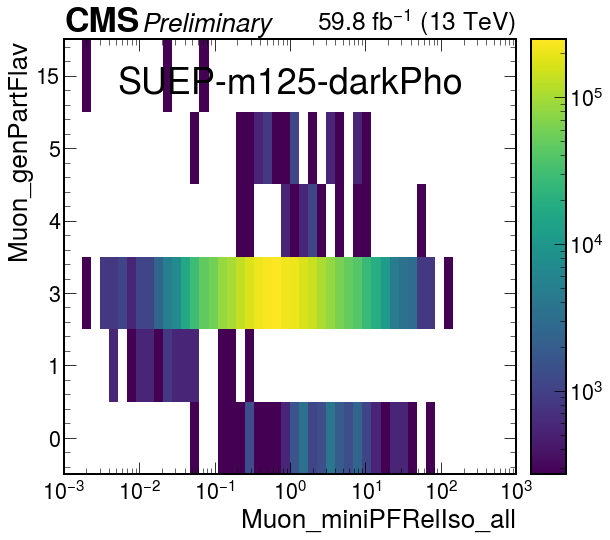

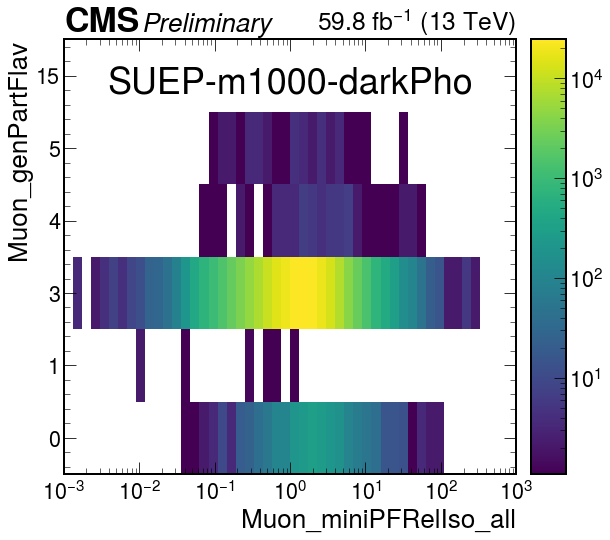

In [76]:
plot_label = 'muon_dxy_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][::sum,:,:,::sum]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(1, 5.25,sample.strip('_2018'), fontsize=36, ha='center')
    plt.xscale('log')
    plt.show()

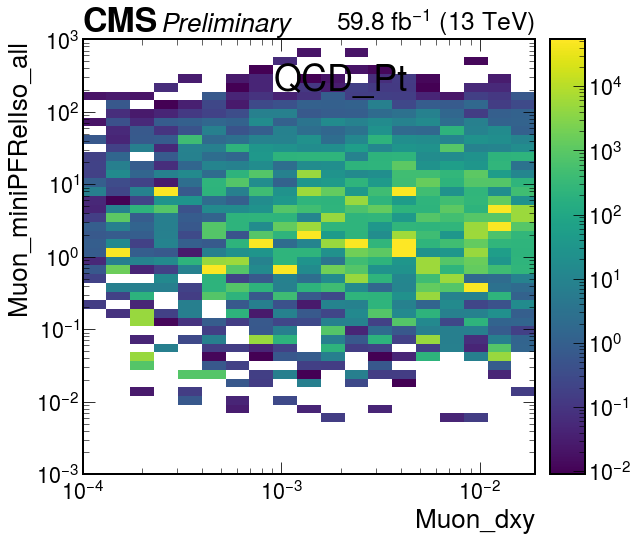

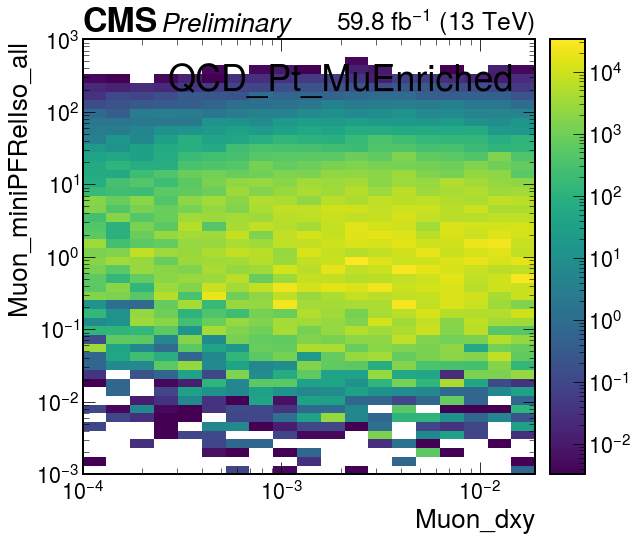

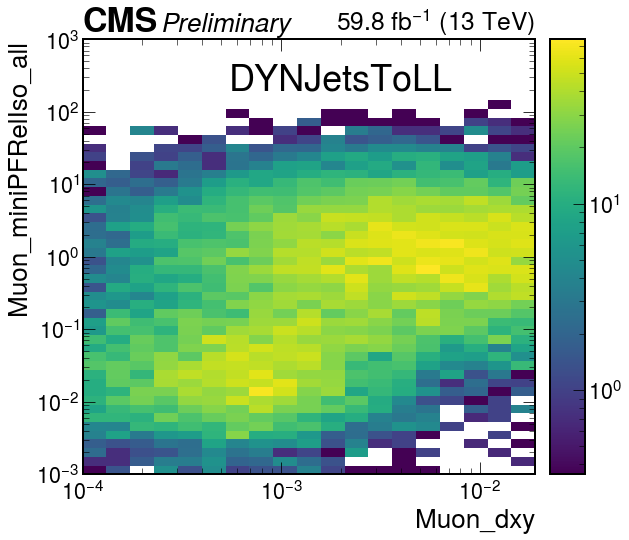

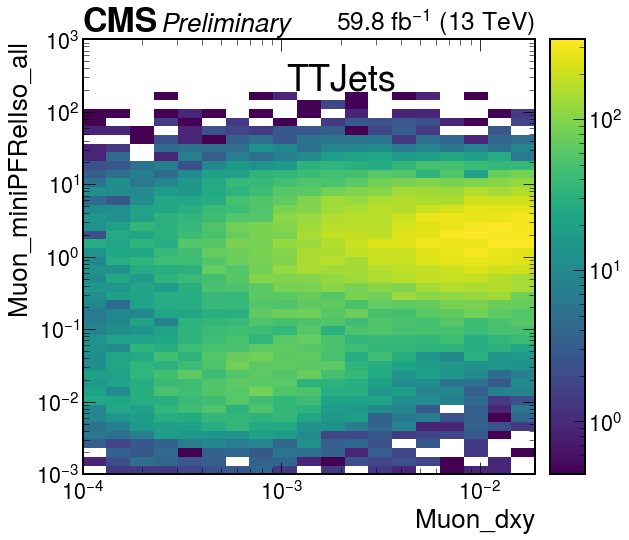

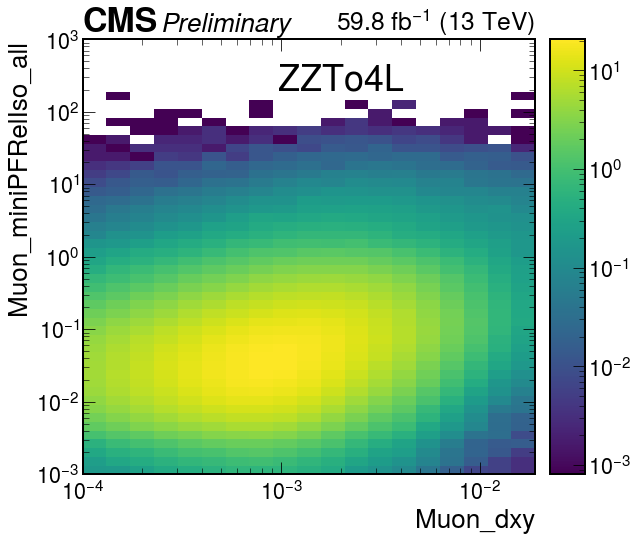

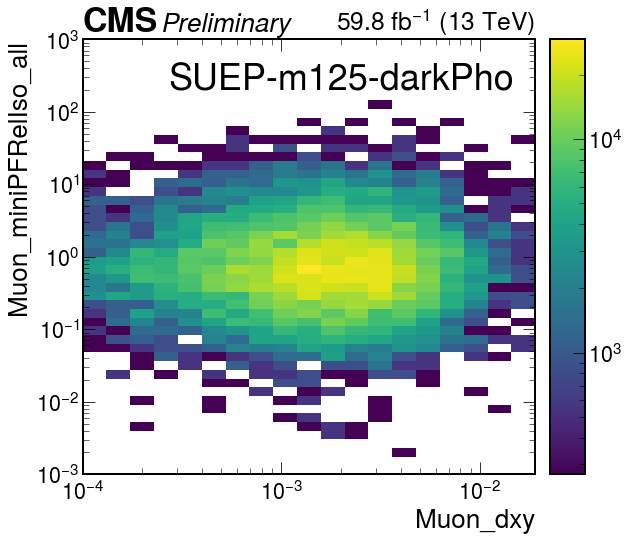

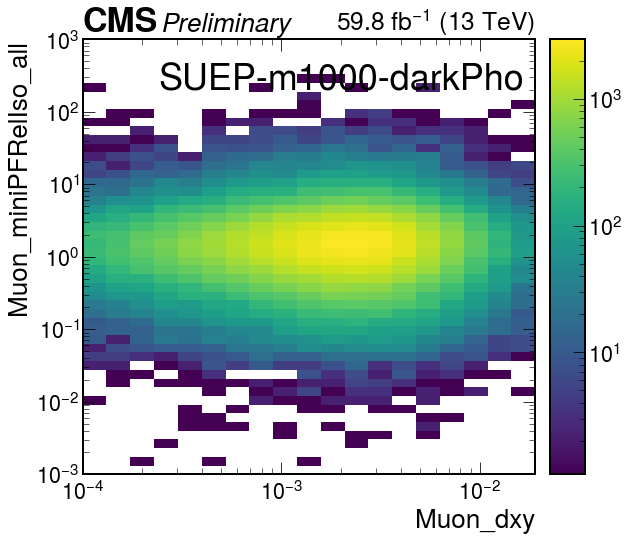

In [77]:
plot_label = 'muon_dxy_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][:0.02j,:,::sum,::sum]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(0.002, 2e2,sample.strip('_2018'), fontsize=36, ha='center')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    plt.show()

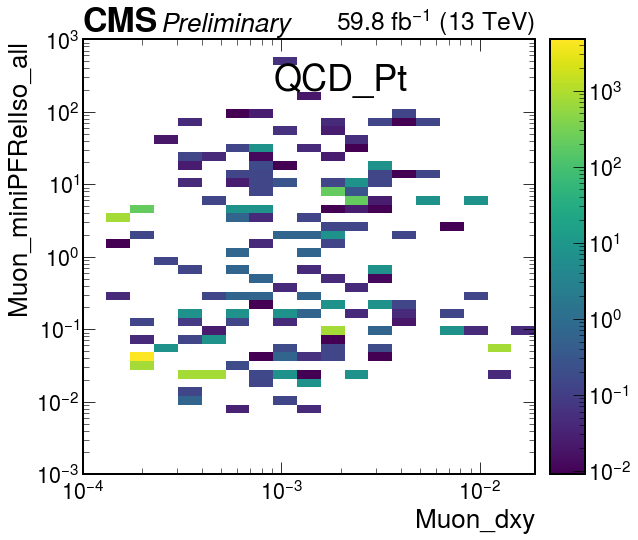

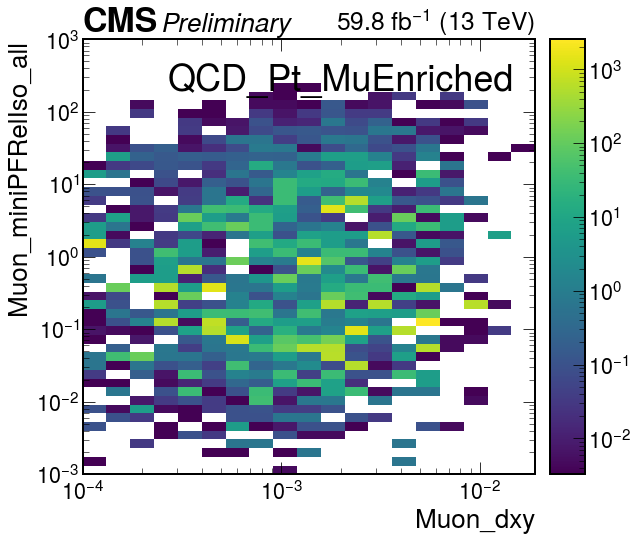

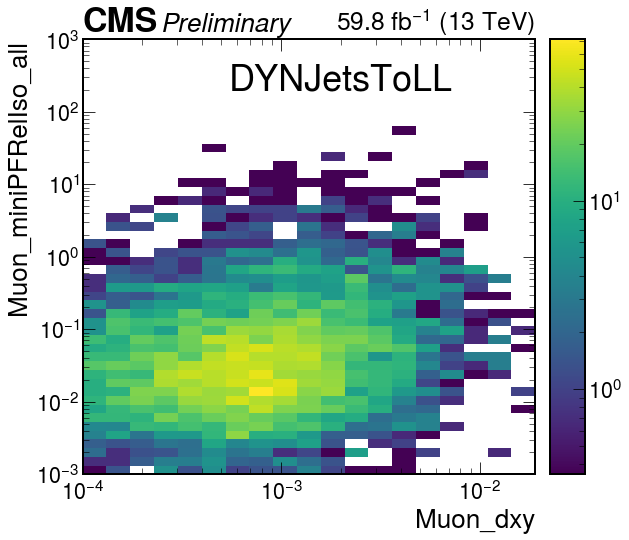

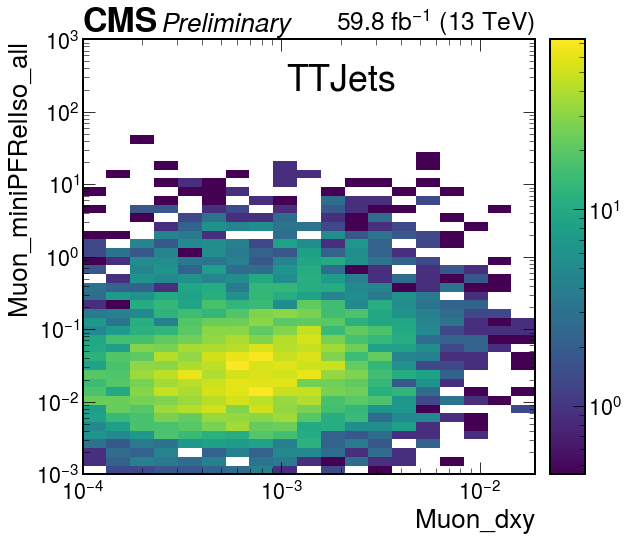

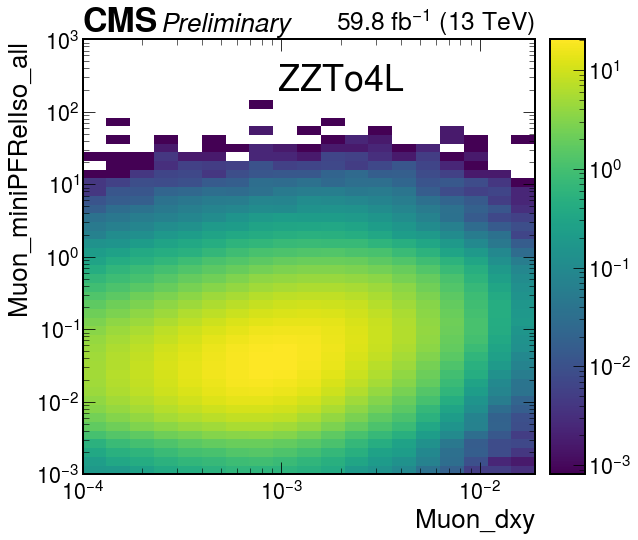

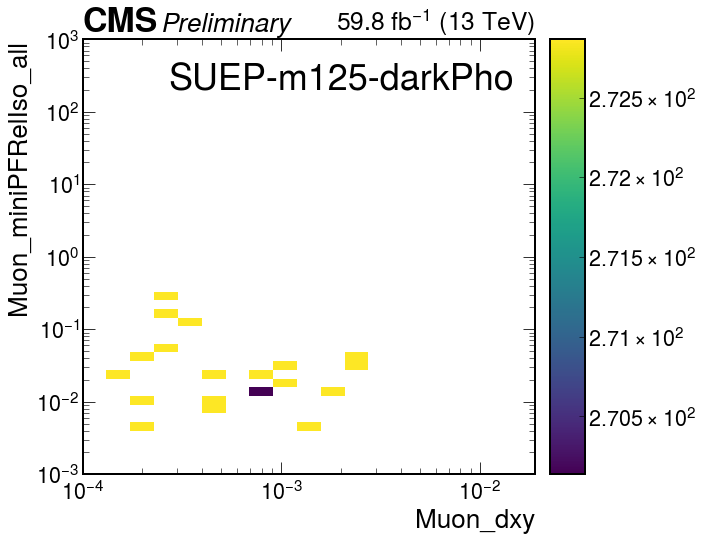

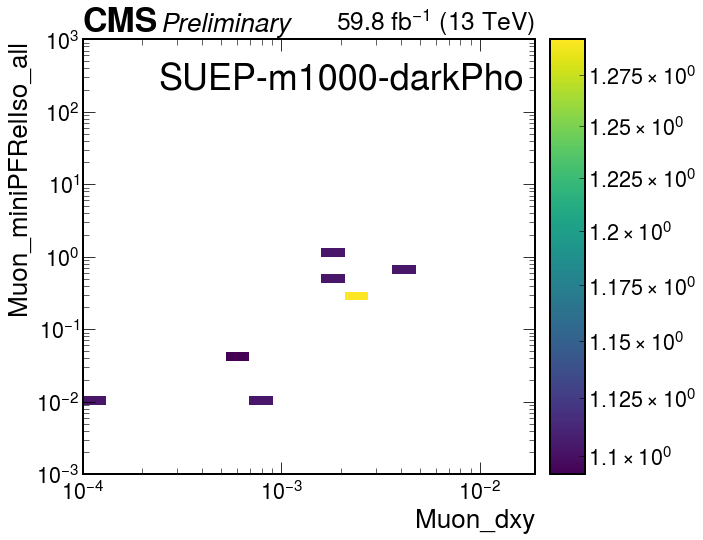

In [79]:
plot_label = 'muon_dxy_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][:0.02j,:,1,::sum]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(0.002, 2e2,sample.strip('_2018'), fontsize=36, ha='center')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    plt.show()

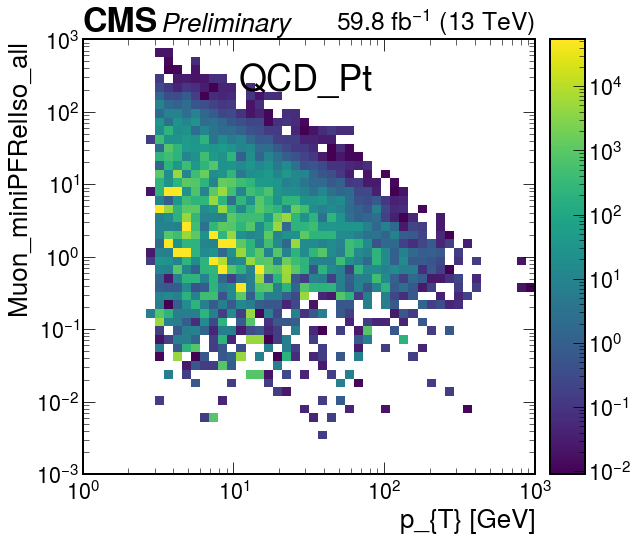

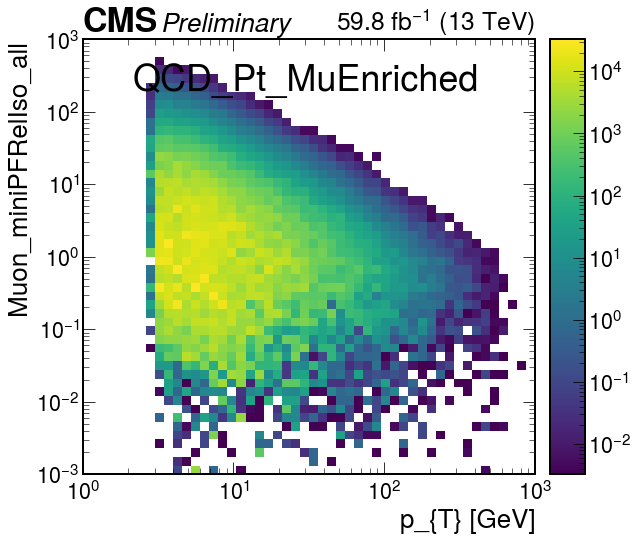

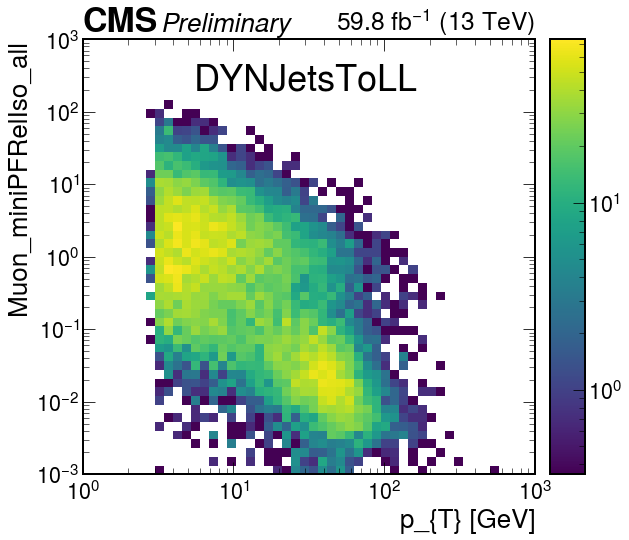

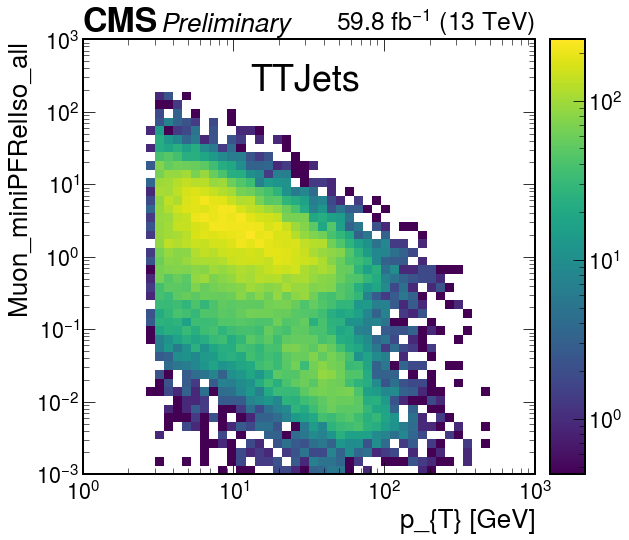

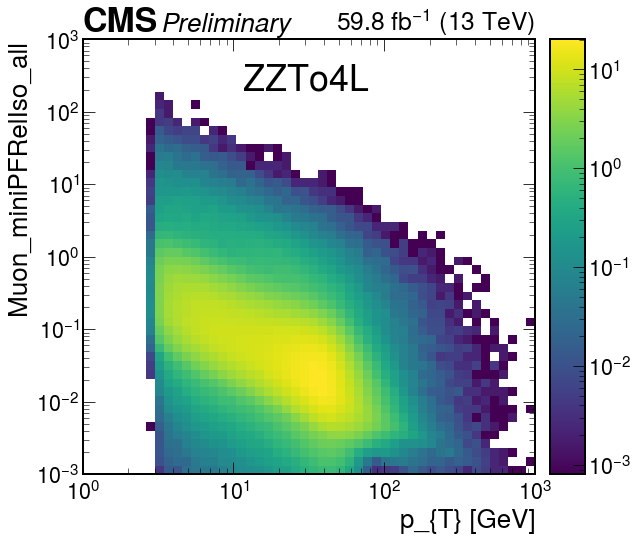

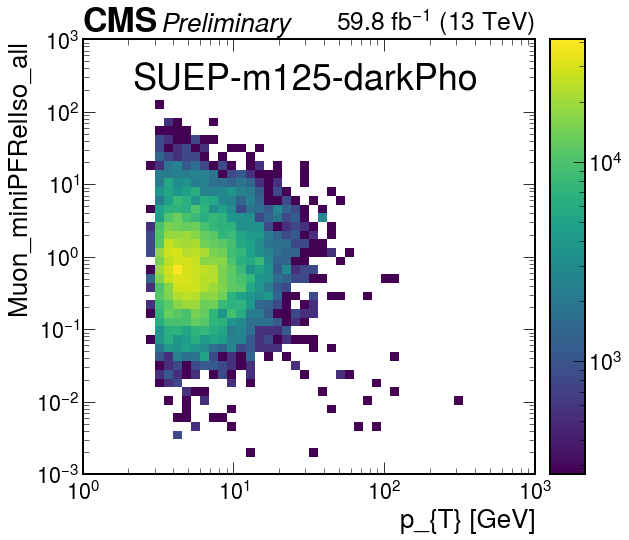

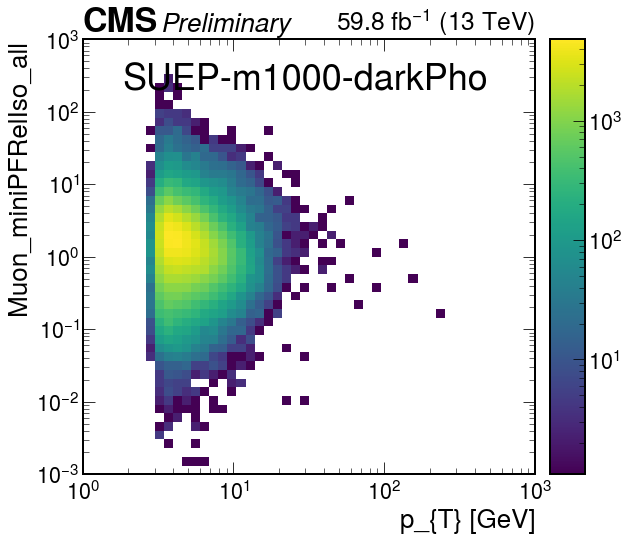

In [78]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][:,:,::sum,::sum]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(30, 2e2,sample.strip('_2018'), fontsize=36, ha='center')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    plt.show()

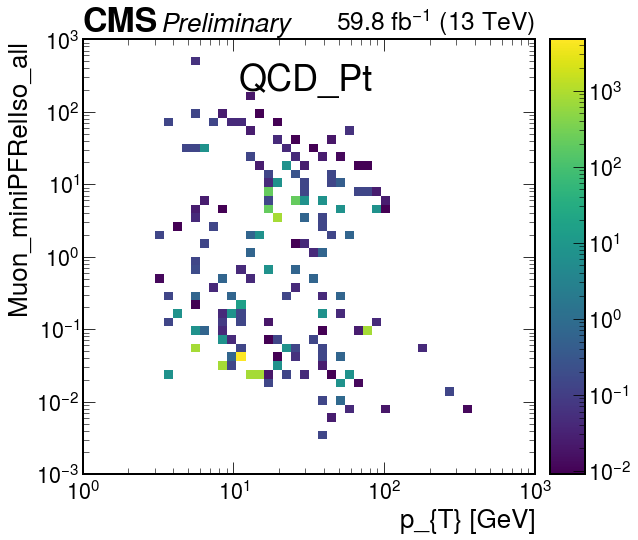

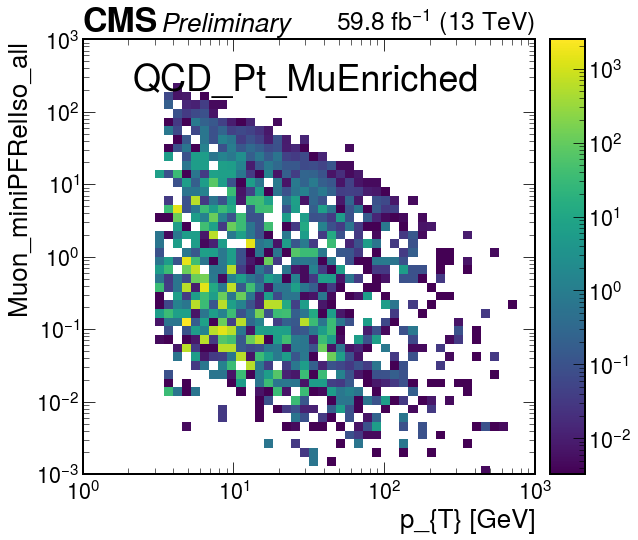

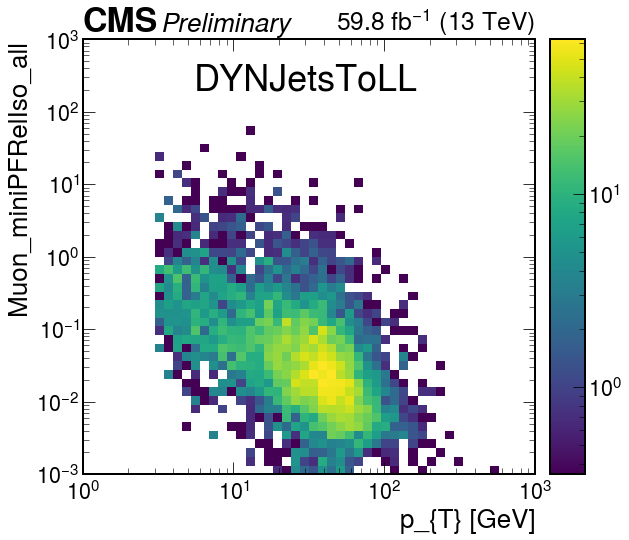

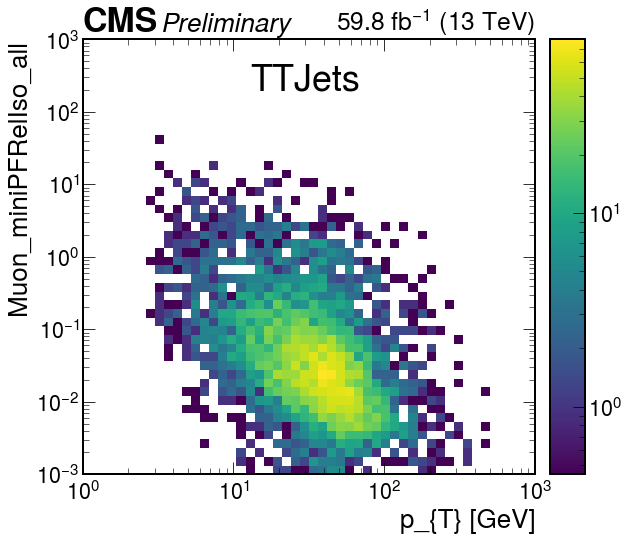

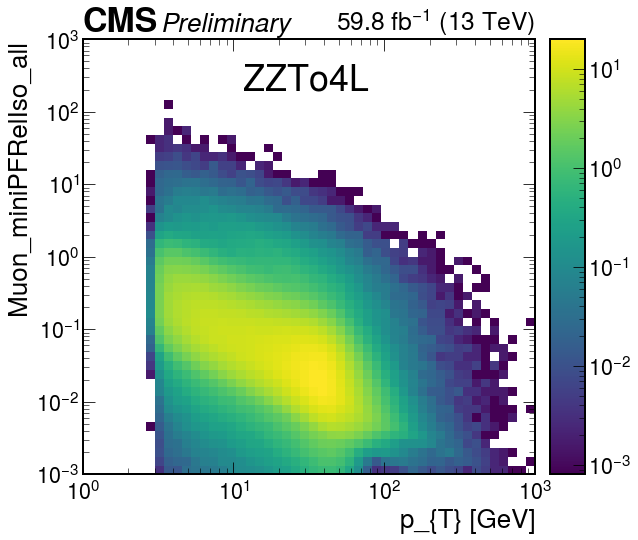

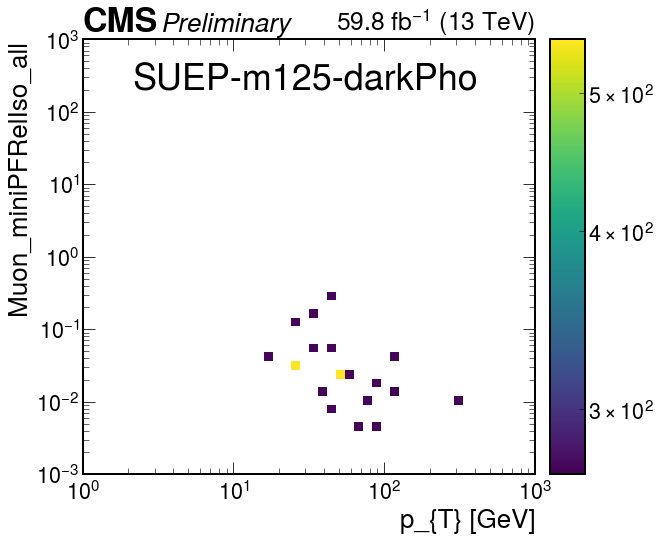

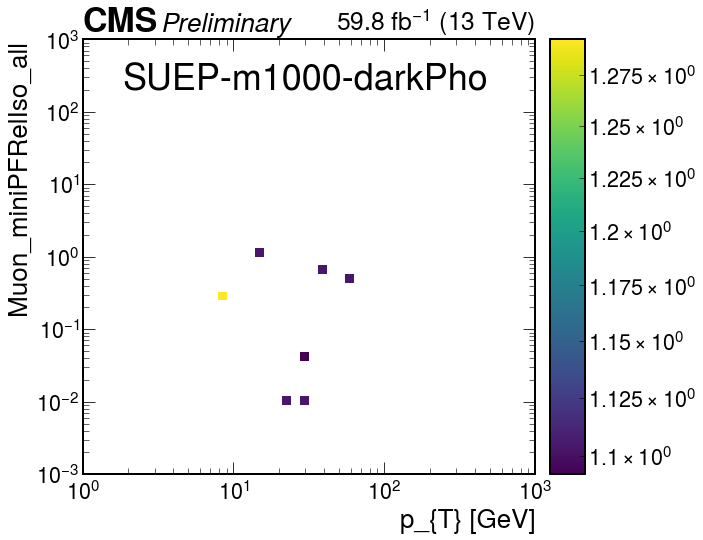

In [80]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][:,:,1,::sum]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(30, 2e2,sample.strip('_2018'), fontsize=36, ha='center')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    plt.show()

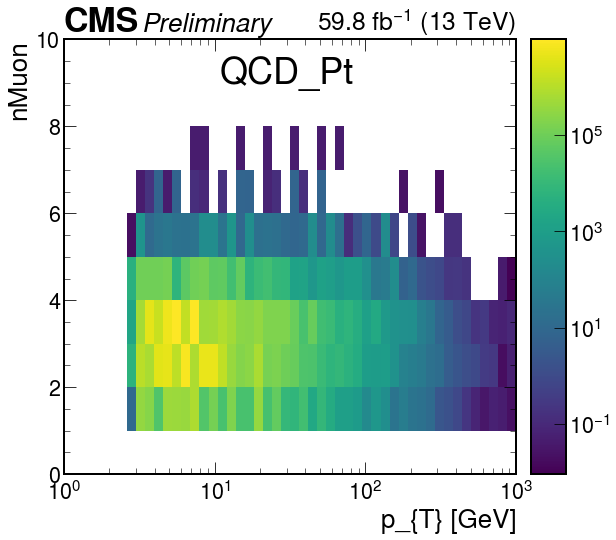

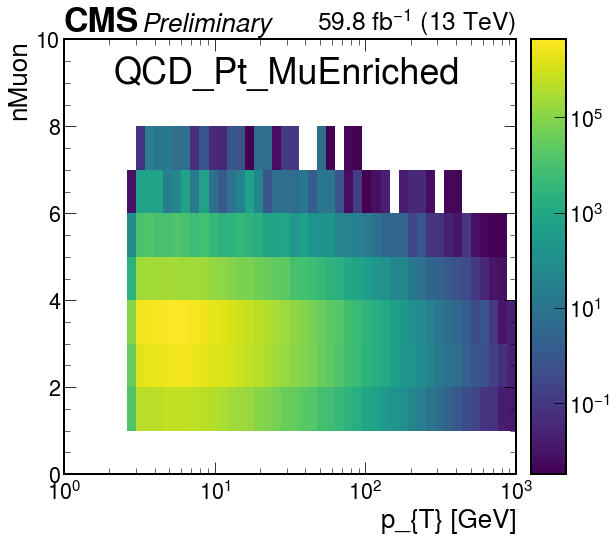

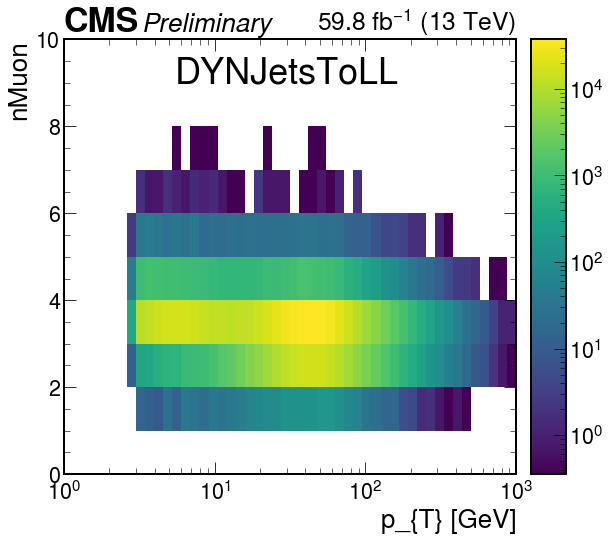

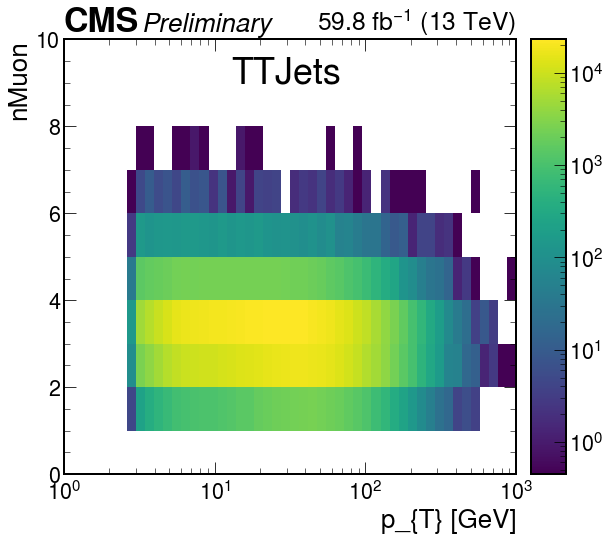

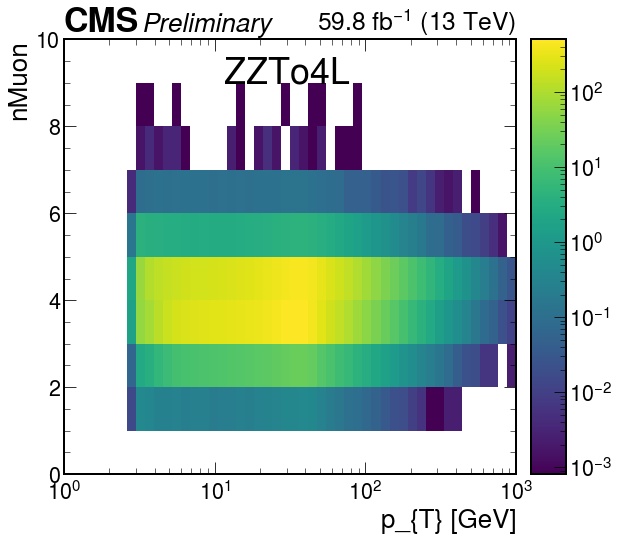

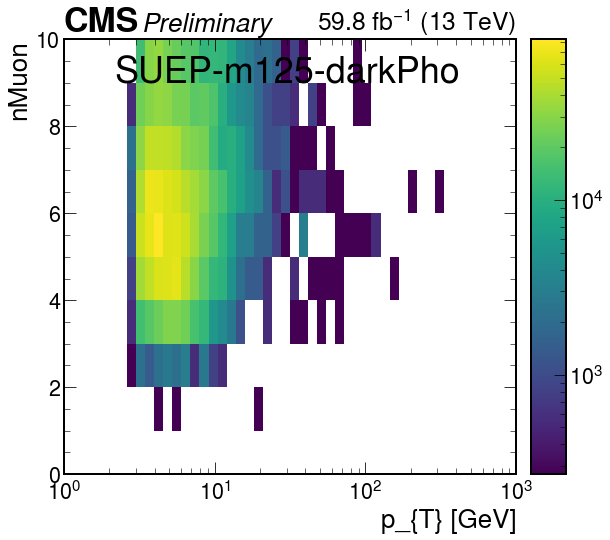

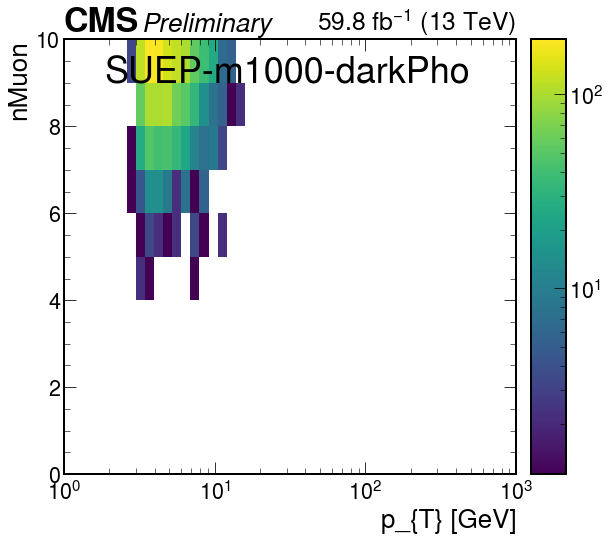

In [25]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][:,::sum,::sum,:]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(30, 9,sample.strip('_2018'), fontsize=36, ha='center')
    ax1.set_xscale('log')
    plt.show()

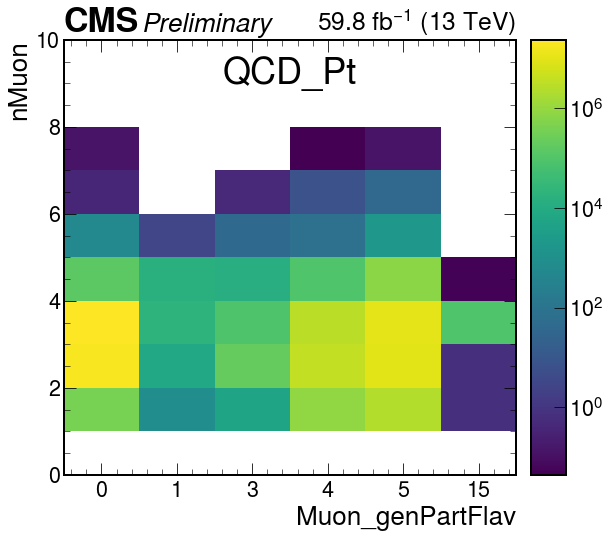

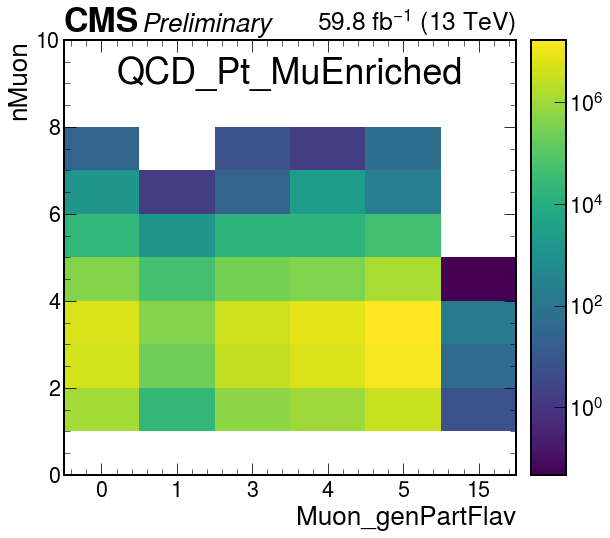

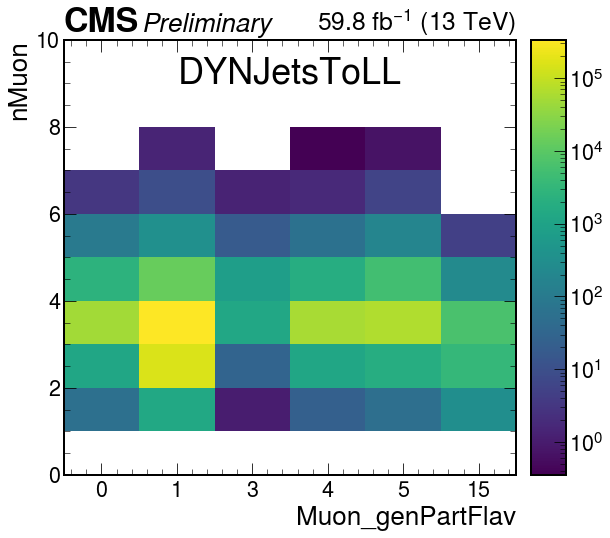

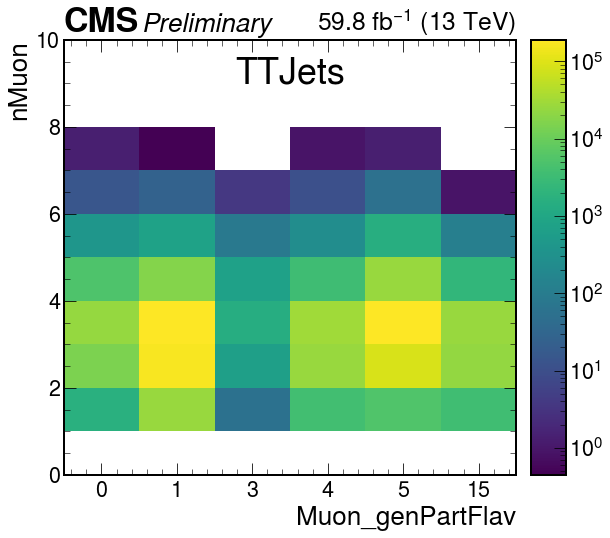

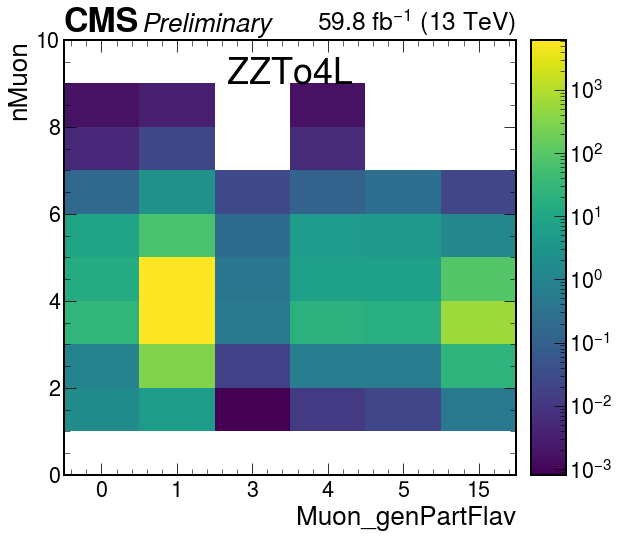

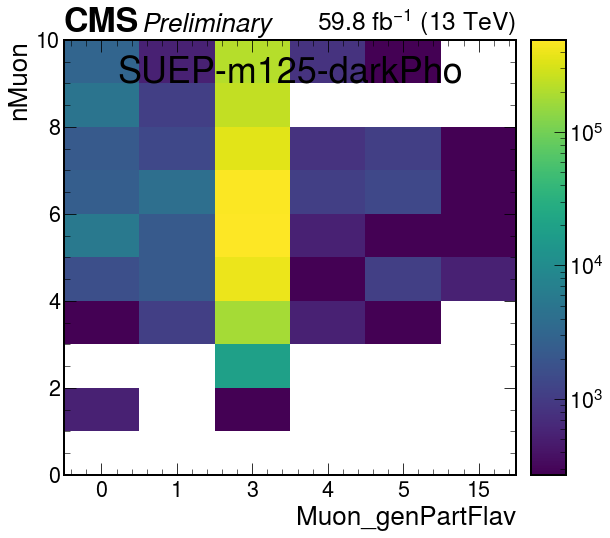

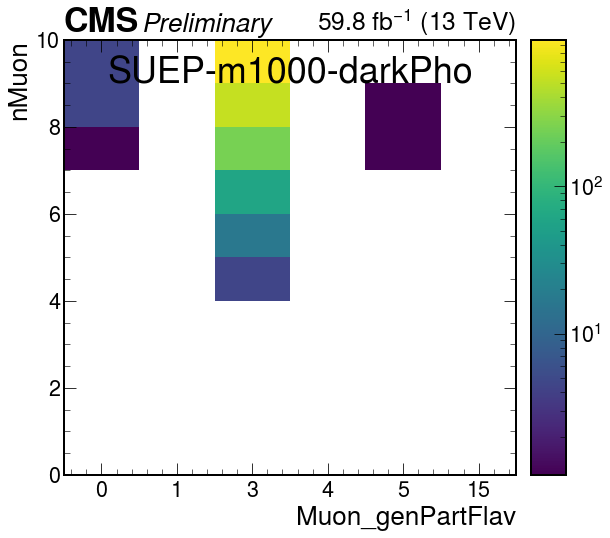

In [13]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(9,8))
    h_temp = plots[sample][plot_label][::sum,::sum,:,:]
    hep.hist2dplot(
        h_temp,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(3, 9,sample.strip('_2018'), fontsize=36, ha='center')
    plt.show()

In [14]:
plots['QCD_Pt_2018']['muon_pdgId_parentId_genFlav_nMuon'][:,:,::sum,::sum]

Hist(
  IntCategory([-1, 0, 11, 13, 15, 22, 100, 200, 300, 400, 500, 1000], name='GenPart_pdgId', label='GenPart_pdgId'),
  IntCategory([-1, 0, 1, 2, 3, 4, 5, 11, 13, 15, 21, 22, 100, 200, 300, 400, 500, 1000], name='GenPart_parent_pdgId', label='GenPart_parent_pdgId'),
  storage=Weight()) # Sum: WeightedSum(value=7.56384e+07, variance=1.71498e+14)

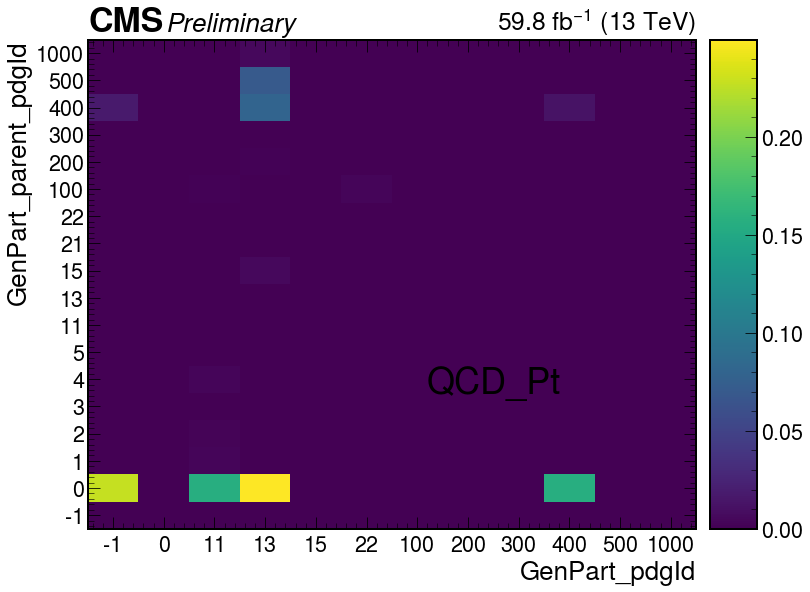

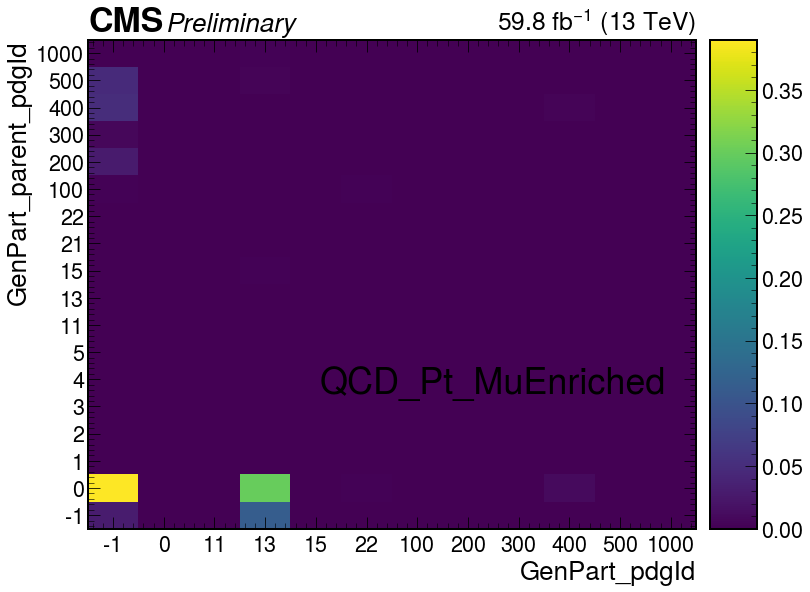

In [15]:
plot_label = 'muon_pdgId_parentId_genFlav_nMuon'
year='2018'
decay='darkPho'
density=True

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    #'DYNJetsToLL_2018',
    #'TTJets_2018',
    #'ttZJets_2018',
    #'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    #f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    #f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 9))
    h_temp = plots[sample][plot_label][:,:,::sum,::sum]
    hep.hist2dplot(
        h_temp / h_temp.sum().value,
        #norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(8, 5,sample.strip('_2018'), fontsize=36, ha='center')
    plt.show()

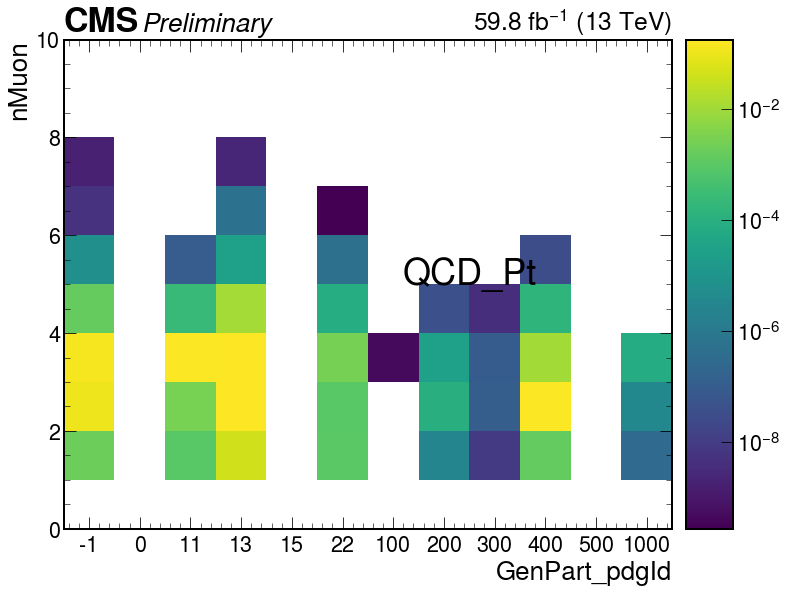

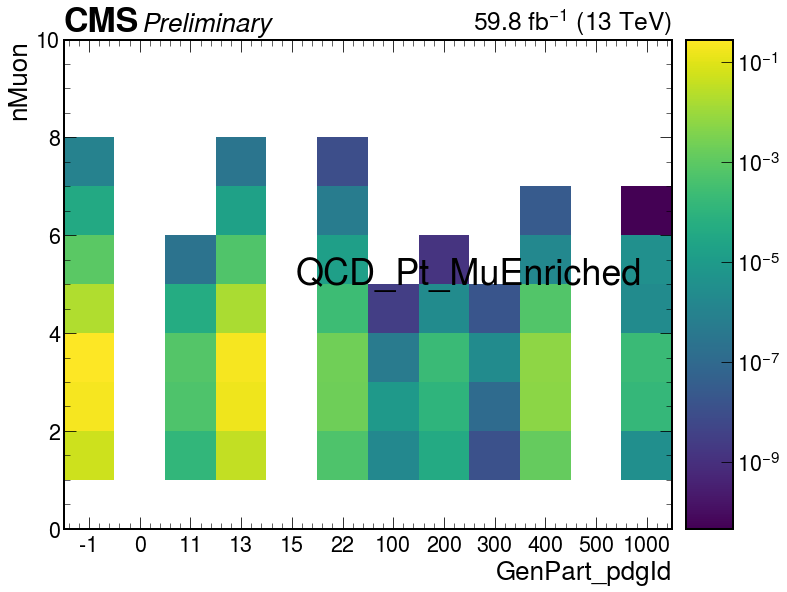

In [18]:
plot_label = 'muon_pdgId_parentId_genFlav_nMuon'
year='2018'
decay='darkPho'
density=True

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    #'DYNJetsToLL_2018',
    #'TTJets_2018',
    #'ttZJets_2018',
    #'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    #f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    #f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 9))
    h_temp = plots[sample][plot_label][:,::sum,::sum,:]
    hep.hist2dplot(
        h_temp / h_temp.sum().value,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(8, 5,sample.strip('_2018'), fontsize=36, ha='center')
    plt.show()

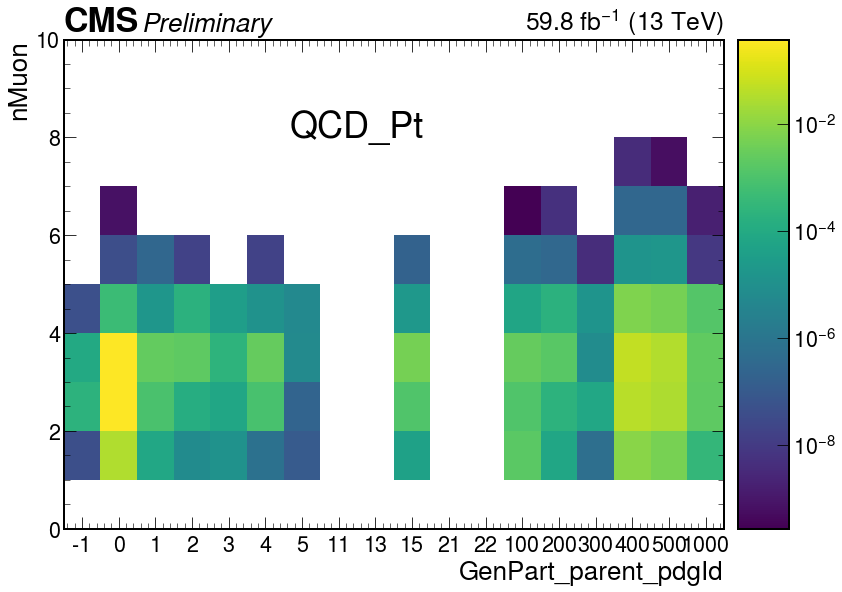

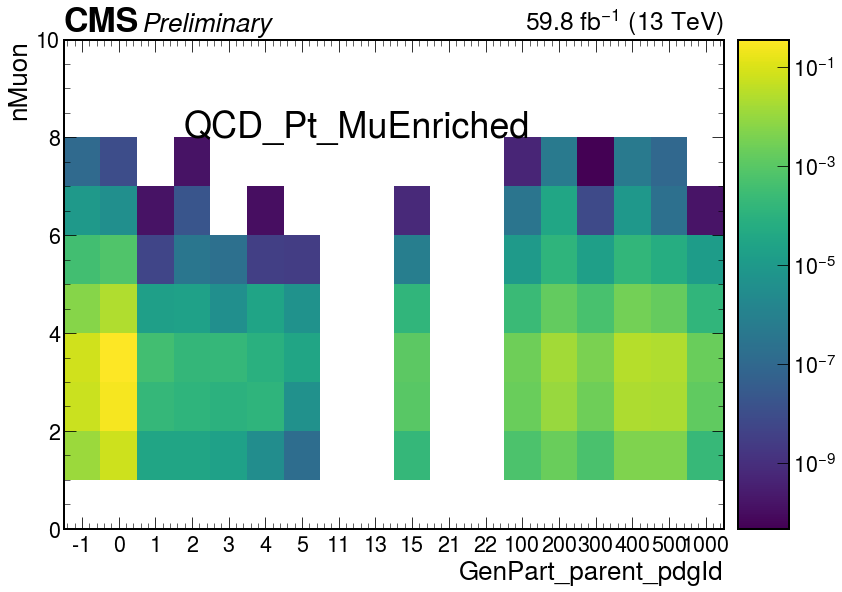

In [50]:
plot_label = 'muon_pdgId_parentId_genFlav_nMuon'
year='2018'
decay='darkPho'
density=True

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    #'DYNJetsToLL_2018',
    #'TTJets_2018',
    #'ttZJets_2018',
    #'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    #f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    #f'SUEP-m1000-{decay}_2018',
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(13, 9))
    h_temp = plots[sample][plot_label][::sum,:,::sum,:]
    hep.hist2dplot(
        h_temp / h_temp.sum().value,
        norm=matplotlib.colors.LogNorm(),
        ax=ax1,
    )
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(8, 8,sample.strip('_2018'), fontsize=36, ha='center')
    plt.show()

## Stacks

In [65]:
plots['QCD_Pt_2018']['muon_mt_vs_genflavor_vs_nMuon']

Hist(
  Regular(150, 0, 150, name='mt', label='m_{T} [GeV]'),
  IntCategory([0, 1, 3, 4, 5, 15], name='Muon_genPartFlav', label='Muon_genPartFlav'),
  Regular(10, 0, 10, name='nMuon', label='nMuon'),
  storage=Weight()) # Sum: WeightedSum(value=1.01795e+06, variance=3.79011e+10) (WeightedSum(value=1.018e+06, variance=3.79011e+10) with flow)

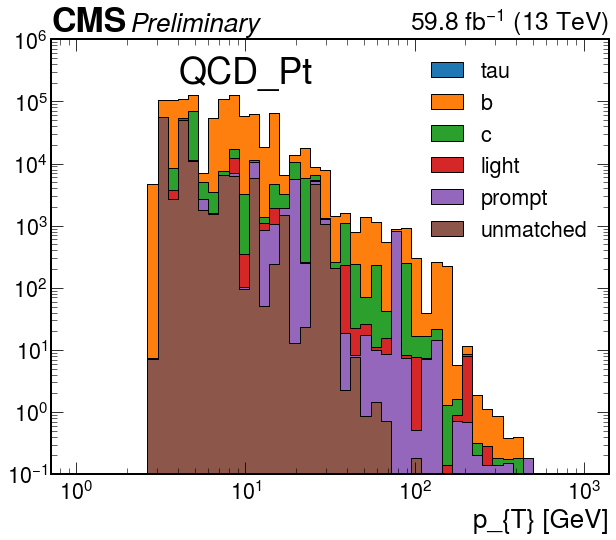

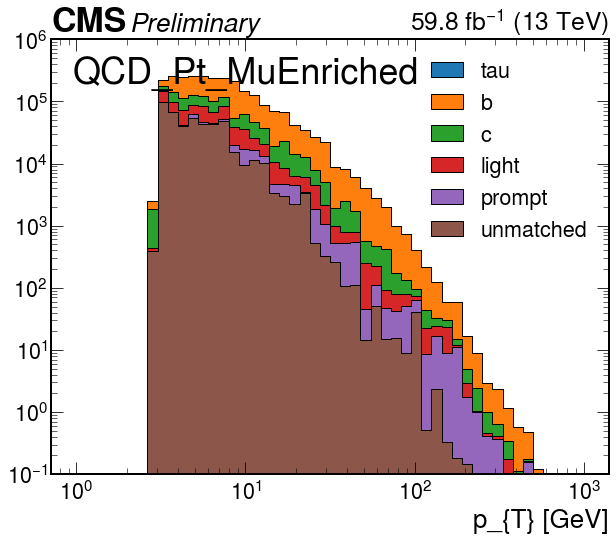

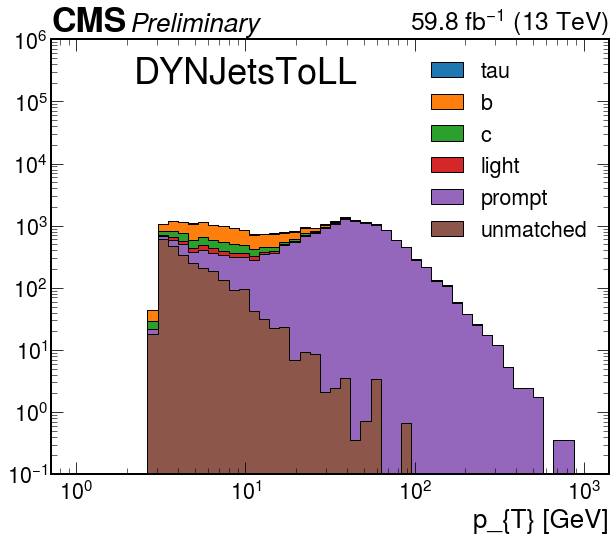

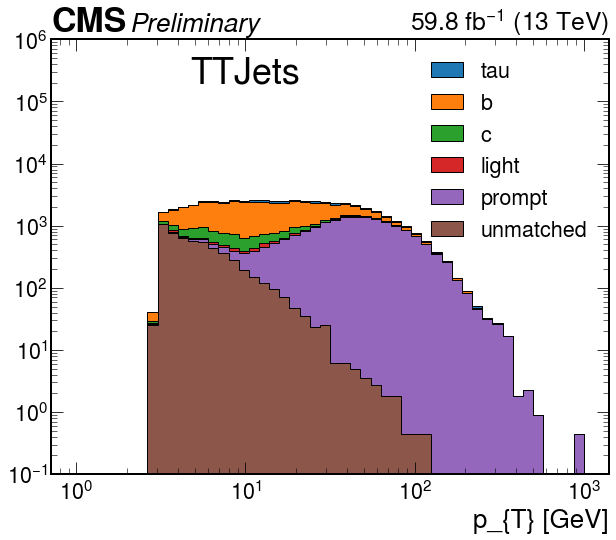

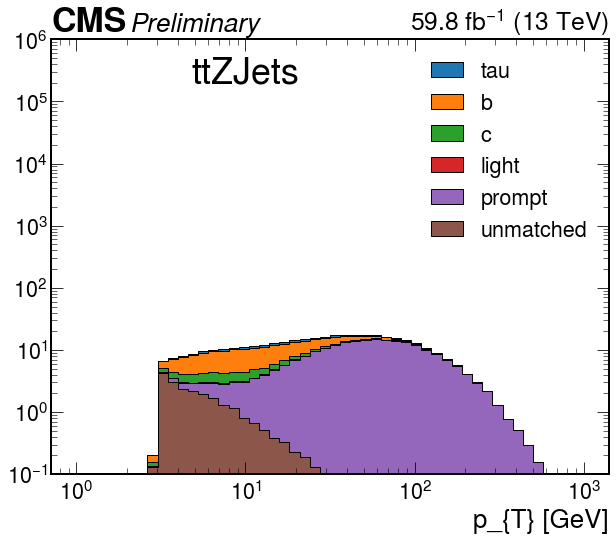

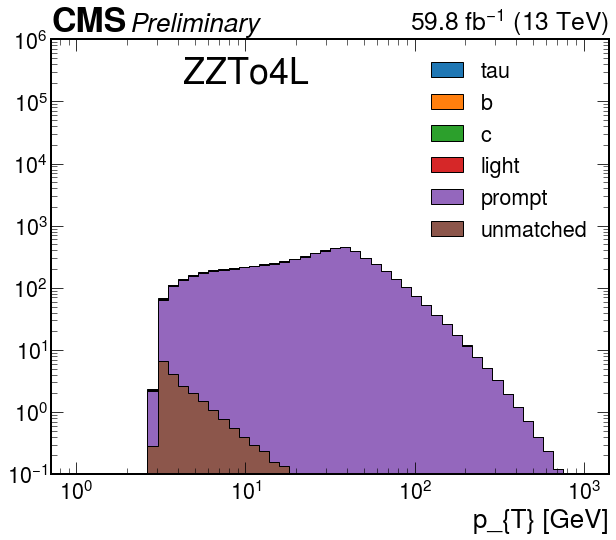

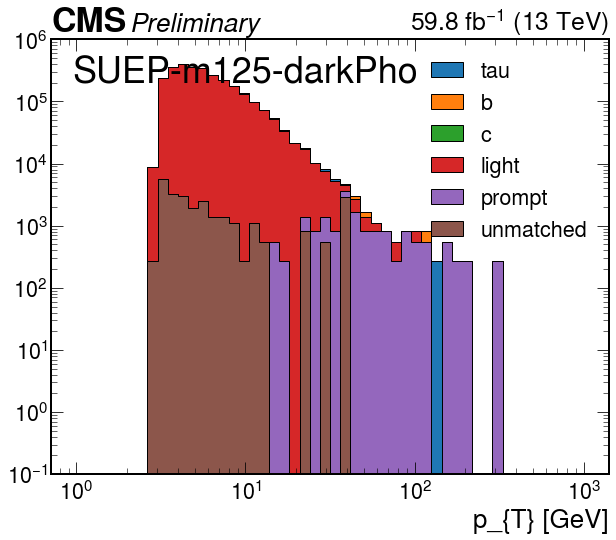

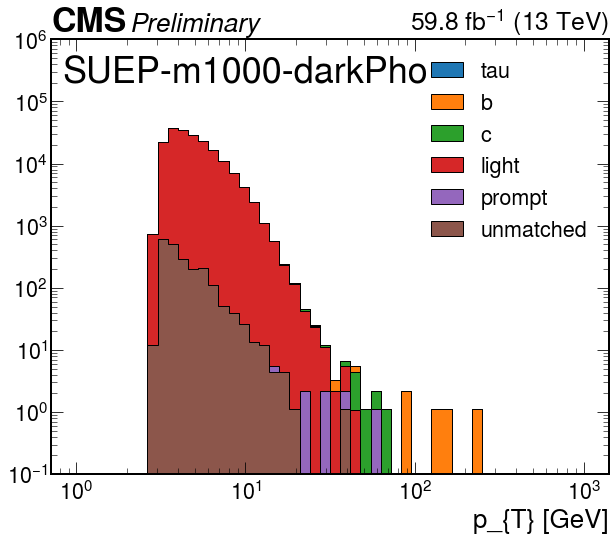

In [119]:
plot_label = 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

genPartFlavor_labels = [
    "unmatched",
    "prompt",
    "light",
    "c",
    "b",
    "tau",
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
    hists = []
    for i in range(6):
        hists.append(plots[sample][plot_label][:, ::sum, i, 4j::sum])
    hep.histplot(
        hists,
        yerr=[np.sqrt(h.variances()) for h in hists], 
        label=genPartFlavor_labels,
        stack=True,
        histtype='fill',
        ec="black",
        #lw=2,
    )
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(10, 2e5,sample.strip('_2018'), fontsize=36, ha='center')
    plt.ylim(1e-1, 1e6)
    plt.show()

In [44]:
print(plots['QCD_Pt_2018'].keys())

dict_keys(['muon_pt_vs_nMuon', 'muon_METmt_vs_nMuon', 'muon_mt_vs_nMuon', 'muon_pt_vs_genflavor_vs_nMuon', 'muon_METmt_vs_genflavor_vs_nMuon', 'muon_mt_vs_genflavor_vs_nMuon', 'muon_dz_vs_genflavor_vs_nMuon', 'muon_ip3d_vs_genflavor_vs_nMuon', 'muon_dxy_vs_miniPFRelIso_vs_genflavor_vs_nMuon', 'muon_pt_vs_miniPFRelIso_vs_genflavor_vs_nMuon'])


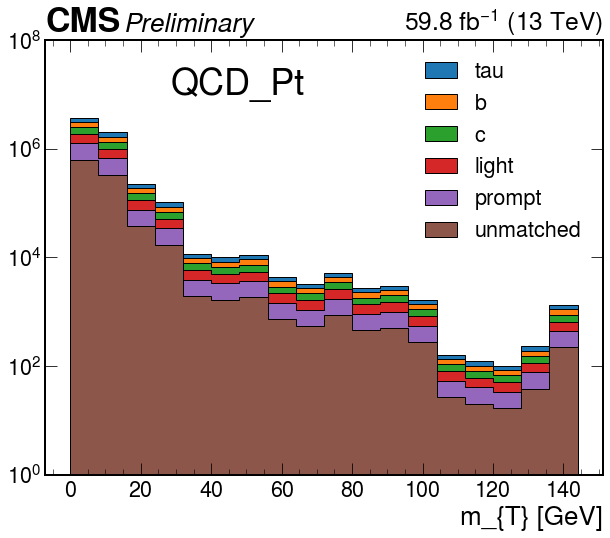

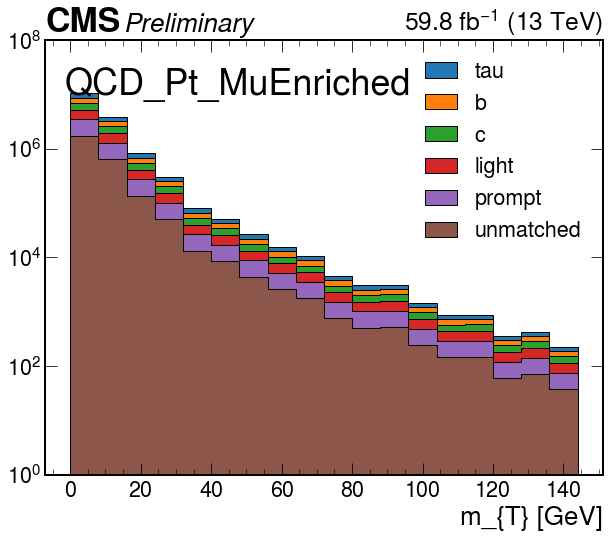

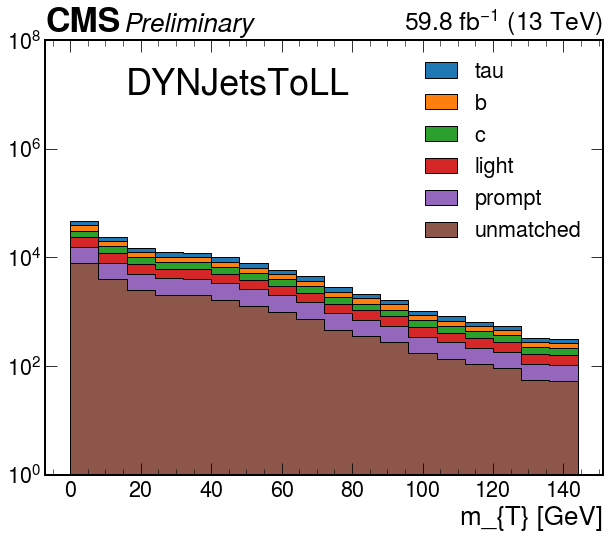

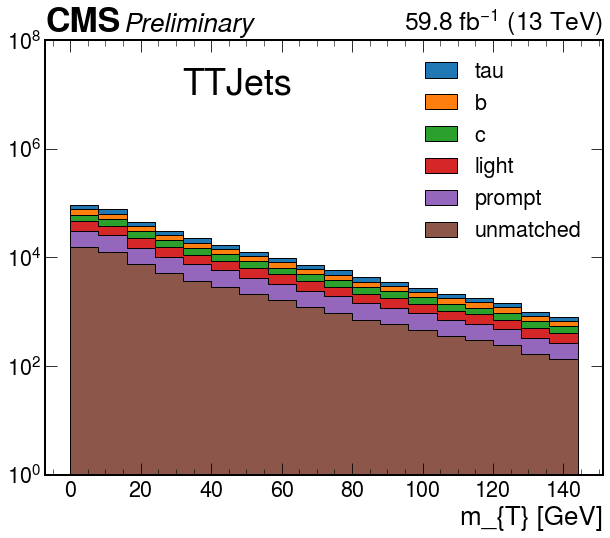

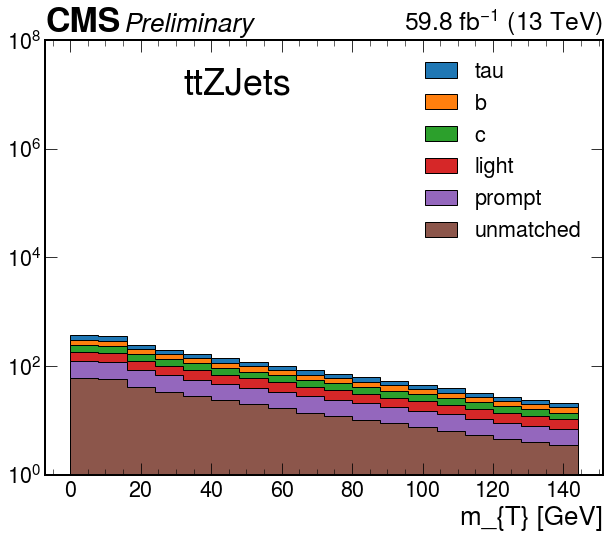

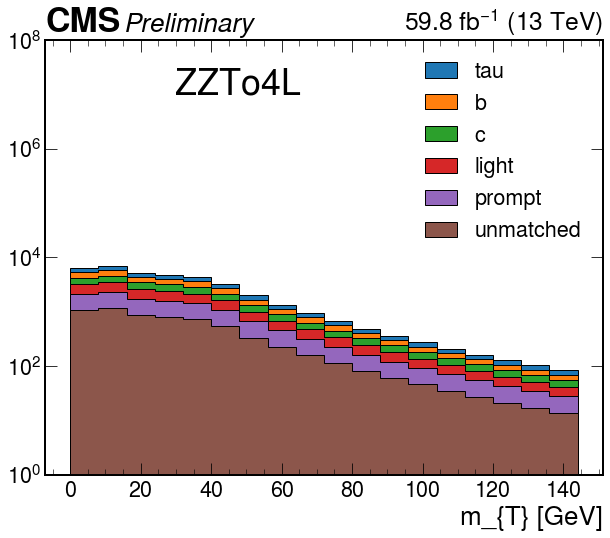

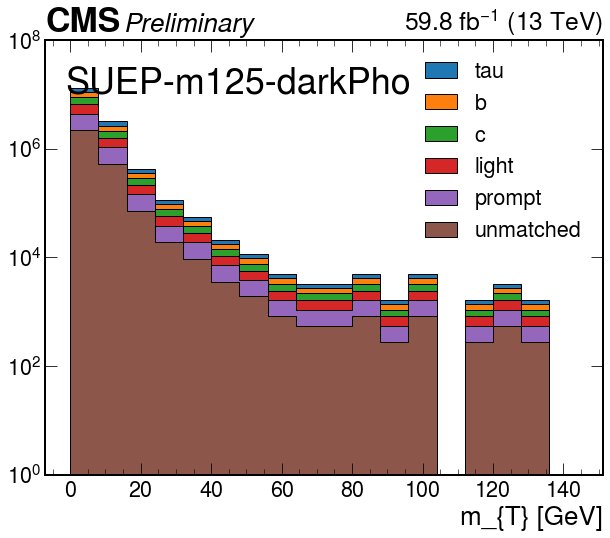

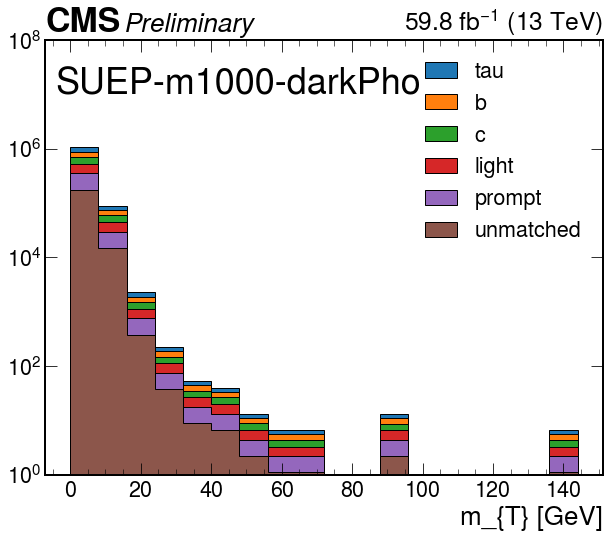

In [43]:
plot_label = 'muon_mt_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

genPartFlavor_labels = [
    "unmatched",
    "prompt",
    "light",
    "c",
    "b",
    "tau",
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
    hists = []
    for i in range(6):
        hists.append(plots[sample][plot_label][::8j, ::sum, 4j::sum])
    hep.histplot(
        hists,
        yerr=[np.sqrt(h.variances()) for h in hists], 
        label=genPartFlavor_labels,
        stack=True,
        histtype='fill',
        ec="black",
        #lw=2,
    )
    plt.legend()
    plt.yscale('log')
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(47.5, 1e7,sample.strip('_2018'), fontsize=36, ha='center')
    plt.ylim(1e0, 1e8)
    plt.show()

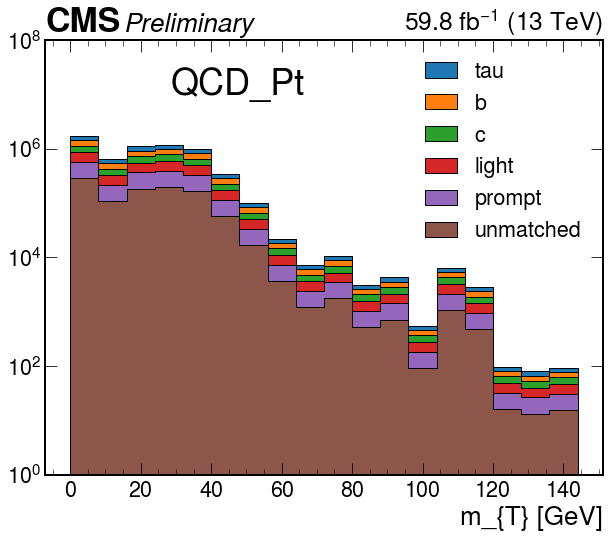

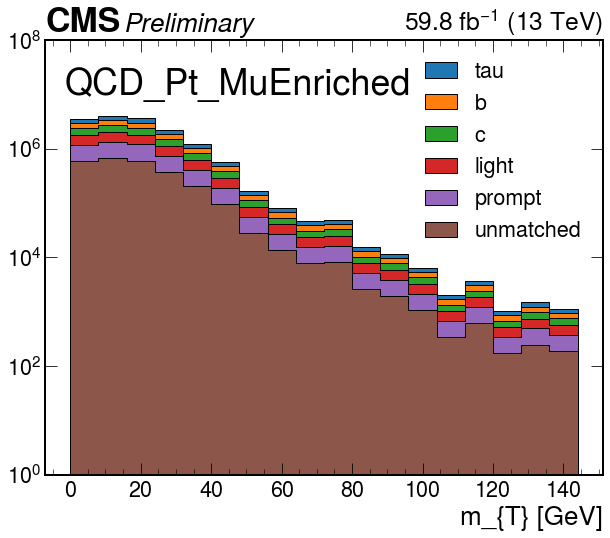

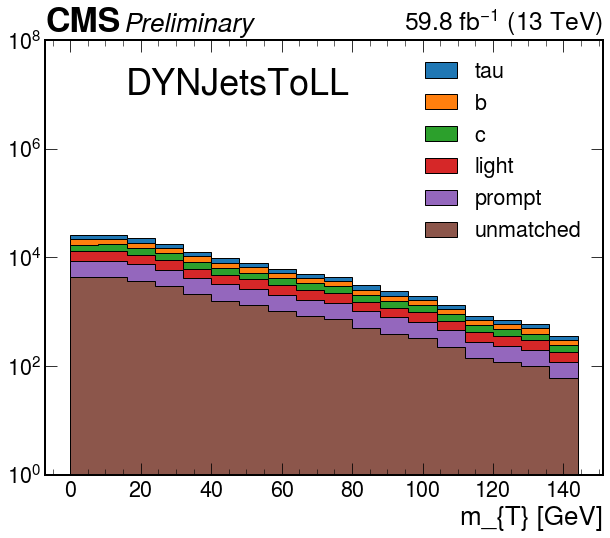

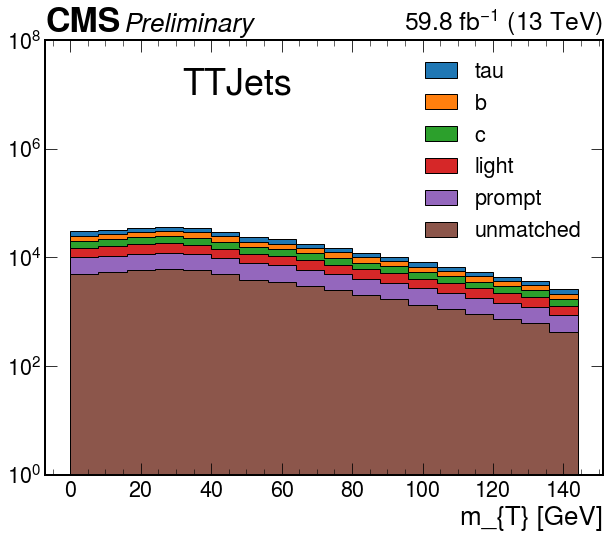

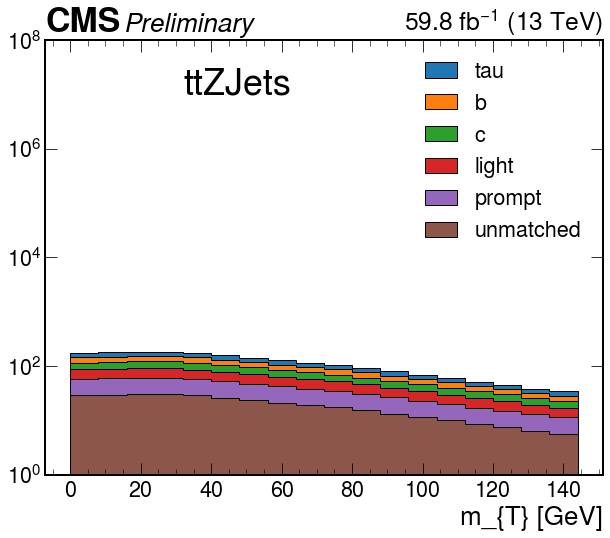

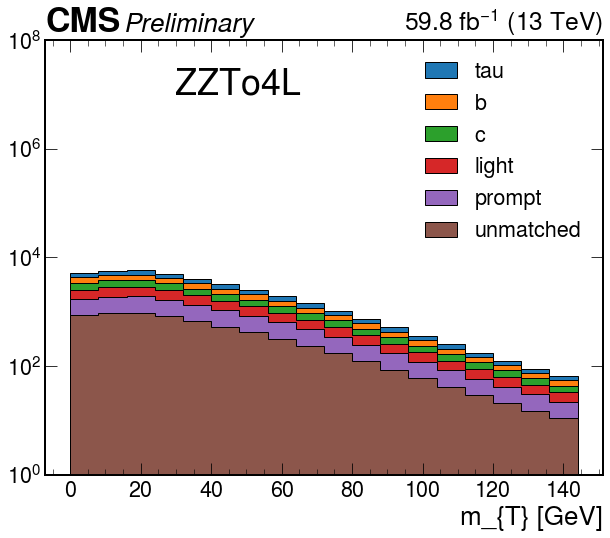

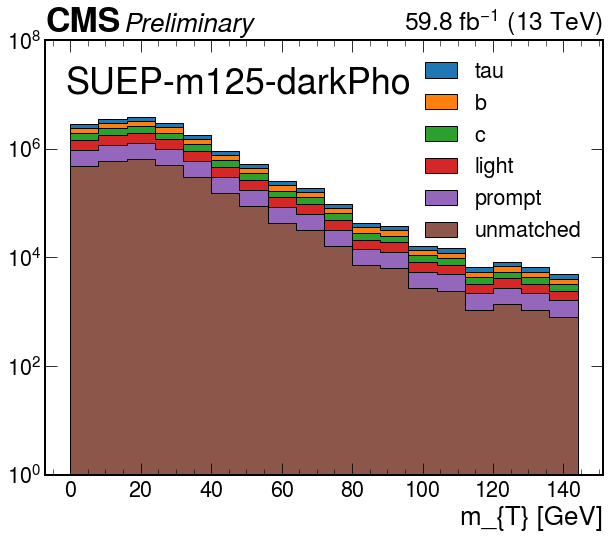

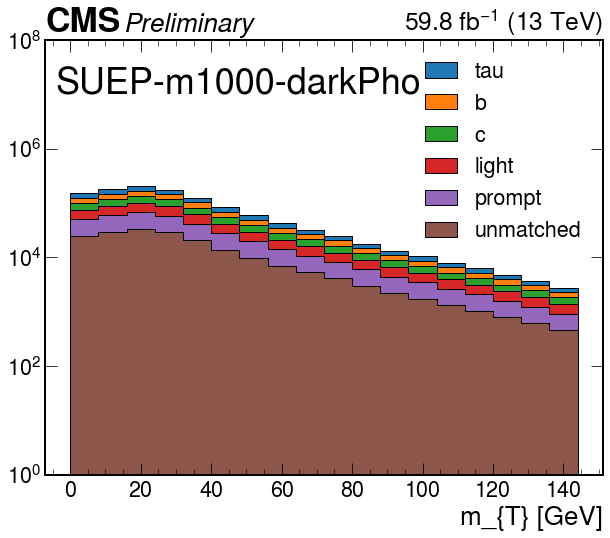

In [45]:
plot_label = 'muon_METmt_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

genPartFlavor_labels = [
    "unmatched",
    "prompt",
    "light",
    "c",
    "b",
    "tau",
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
    hists = []
    for i in range(6):
        hists.append(plots[sample][plot_label][::8j, ::sum, 4j::sum])
    hep.histplot(
        hists,
        yerr=[np.sqrt(h.variances()) for h in hists], 
        label=genPartFlavor_labels,
        stack=True,
        histtype='fill',
        ec="black",
        #lw=2,
    )
    plt.legend()
    plt.yscale('log')
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(47.5, 1e7,sample.strip('_2018'), fontsize=36, ha='center')
    plt.ylim(1e0, 1e8)
    plt.show()

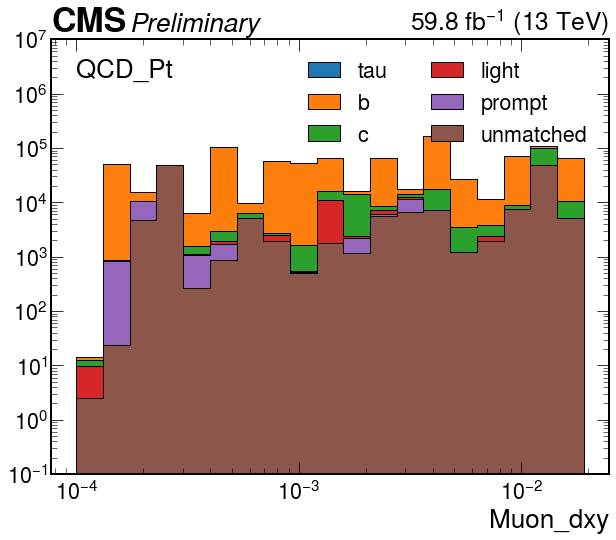

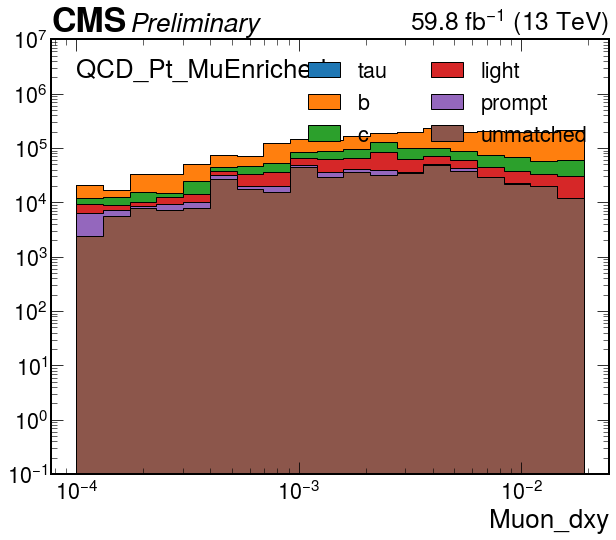

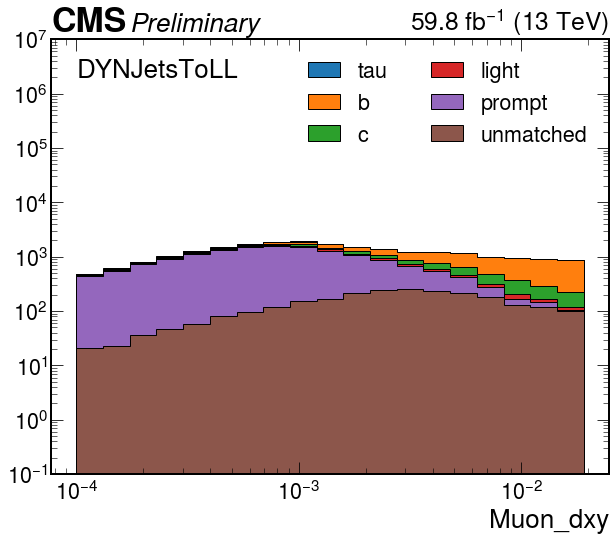

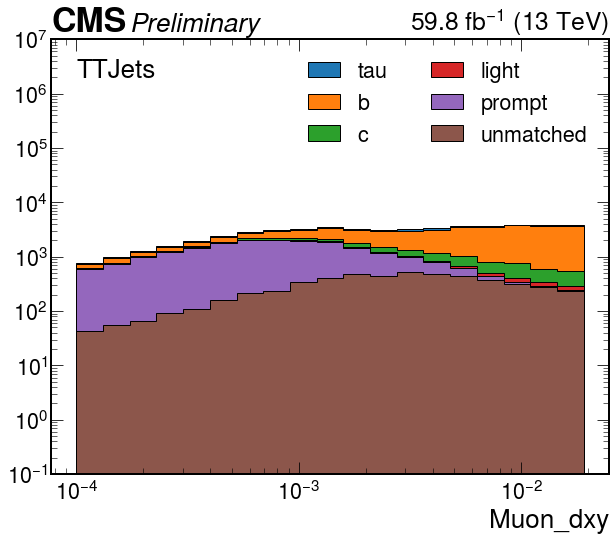

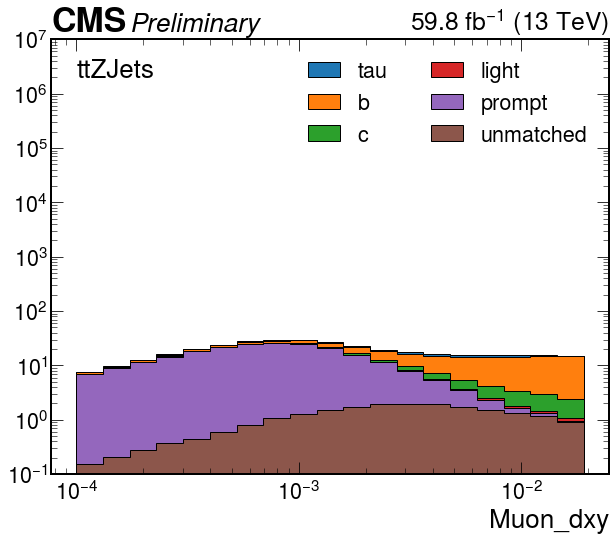

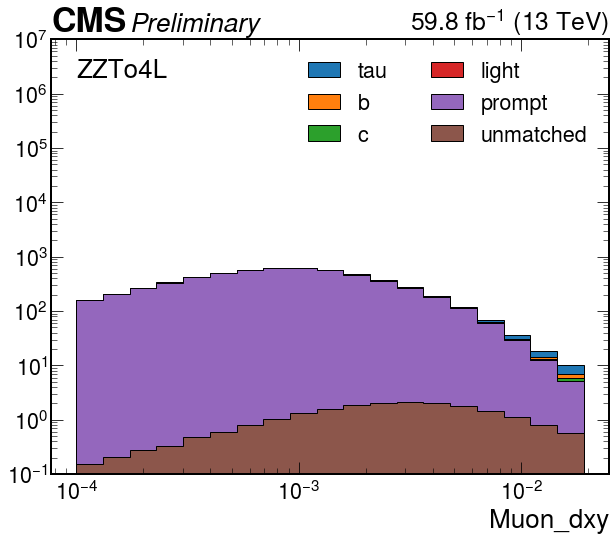

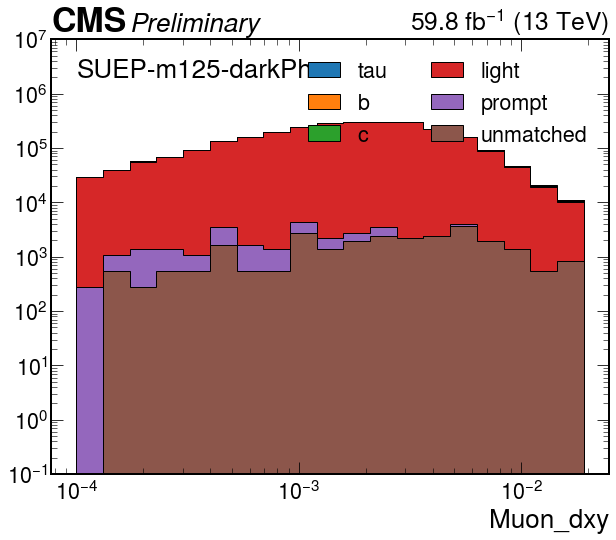

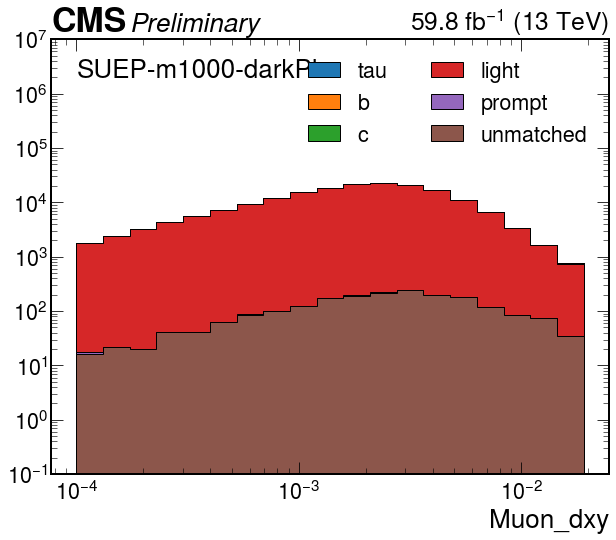

In [129]:
plot_label = 'muon_dxy_vs_miniPFRelIso_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

genPartFlavor_labels = [
    "unmatched",
    "prompt",
    "light",
    "c",
    "b",
    "tau",
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
    hists = []
    for i in range(6):
        hists.append(plots[sample][plot_label][:0.02j, ::sum, i, 4j::sum])
    hep.histplot(
        hists,
        yerr=[np.sqrt(h.variances()) for h in hists], 
        label=genPartFlavor_labels,
        stack=True,
        histtype='fill',
        ec="black",
        #lw=2,
    )
    plt.legend(ncol=2)
    plt.xscale('log')
    plt.yscale('log')
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(1e-4, 2e6,sample.strip('_2018'), fontsize=26, ha='left')
    plt.ylim(1e-1, 1e7)
    plt.show()

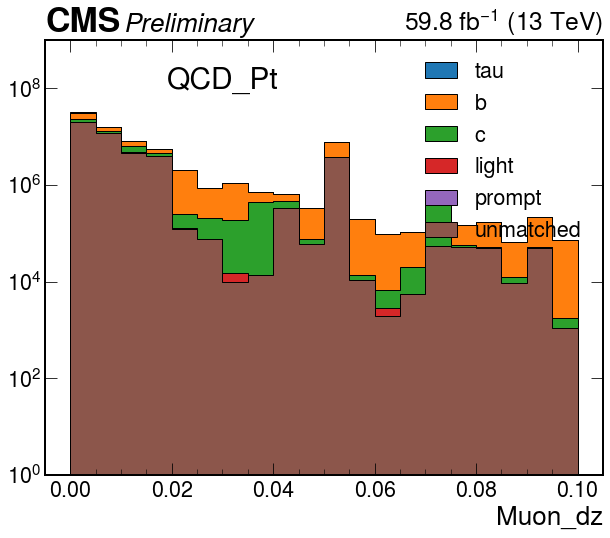

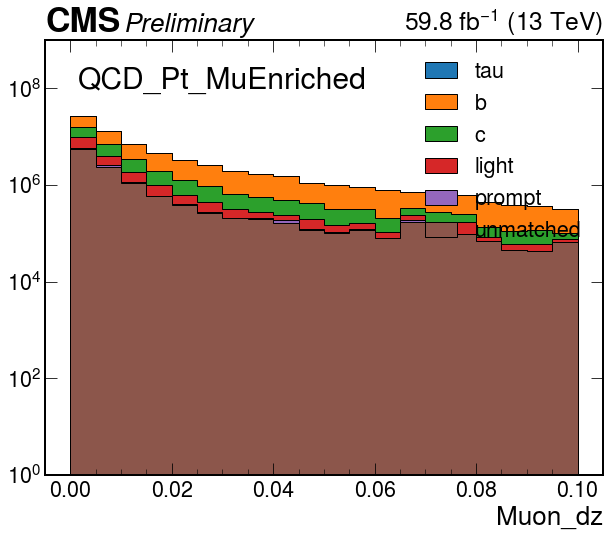

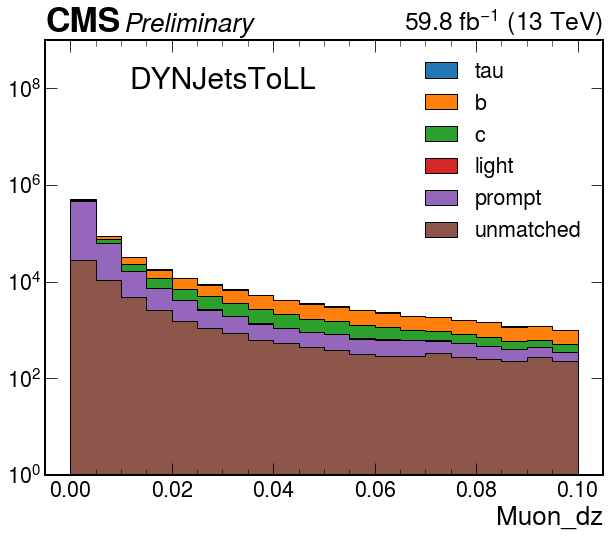

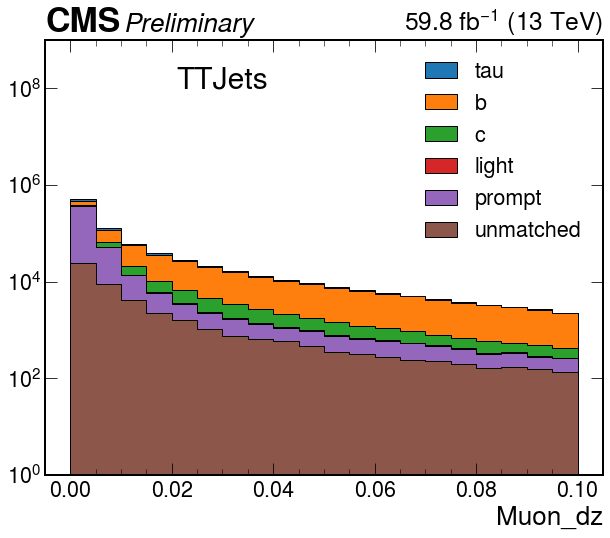

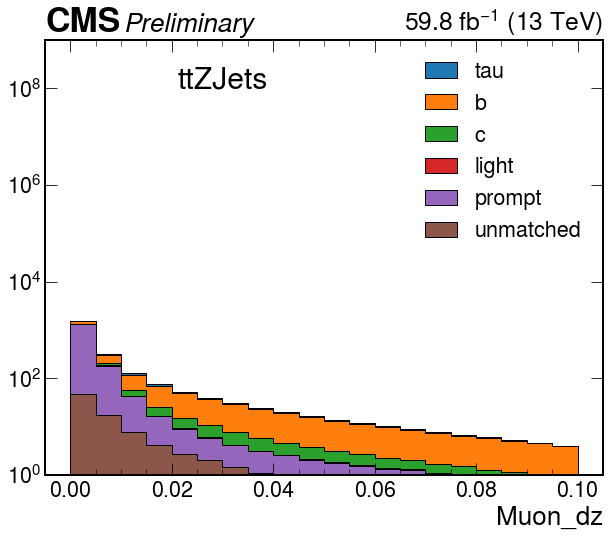

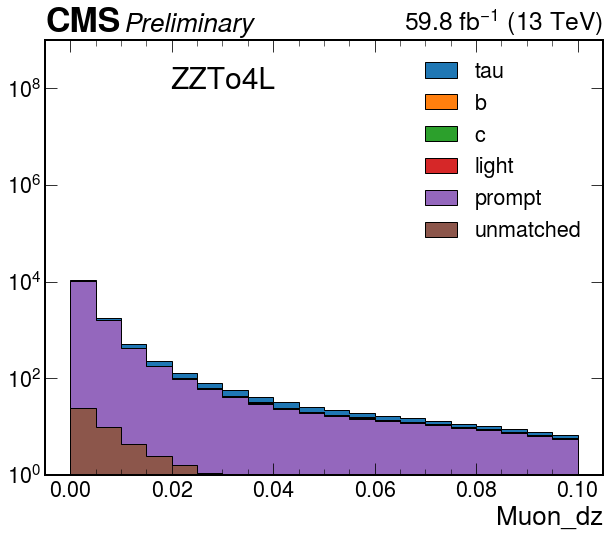

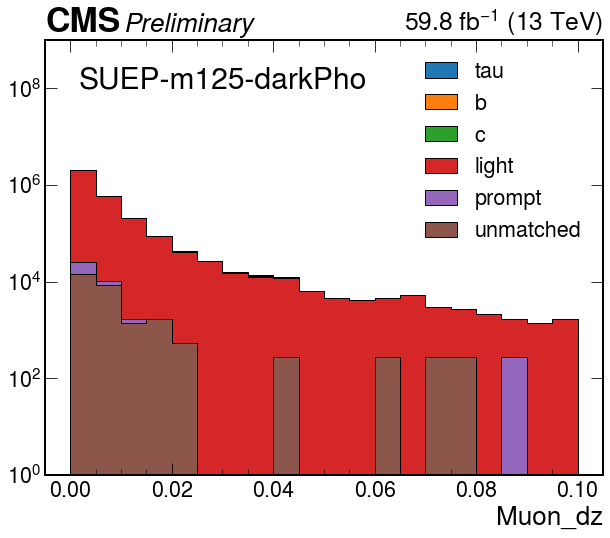

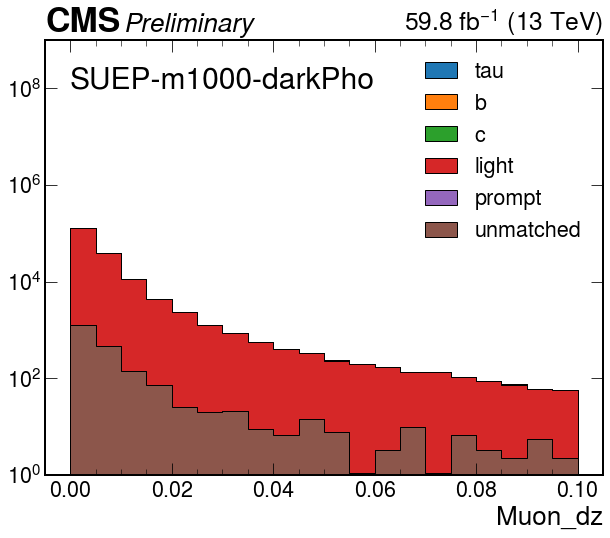

In [45]:
plot_label = 'muon_dz_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

genPartFlavor_labels = [
    "unmatched",
    "prompt",
    "light",
    "c",
    "b",
    "tau",
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
    hists = []
    for i in range(6):
        hists.append(plots[sample][plot_label][::10j, i, ::sum])
    hep.histplot(
        hists,
        yerr=[np.sqrt(h.variances()) for h in hists], 
        label=genPartFlavor_labels,
        stack=True,
        histtype='fill',
        ec="black",
        #lw=2,
    )
    plt.legend()
    plt.yscale('log')
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(3e-2, 1e8,sample.strip('_2018'), fontsize=30, ha='center')
    plt.ylim(1e0, 1e9)
    plt.show()

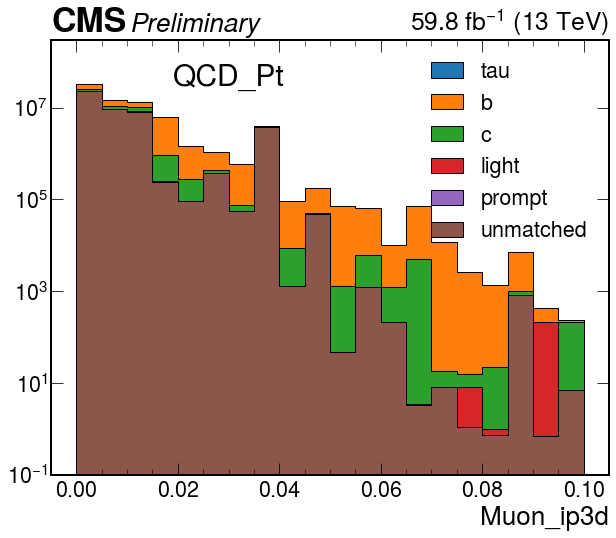

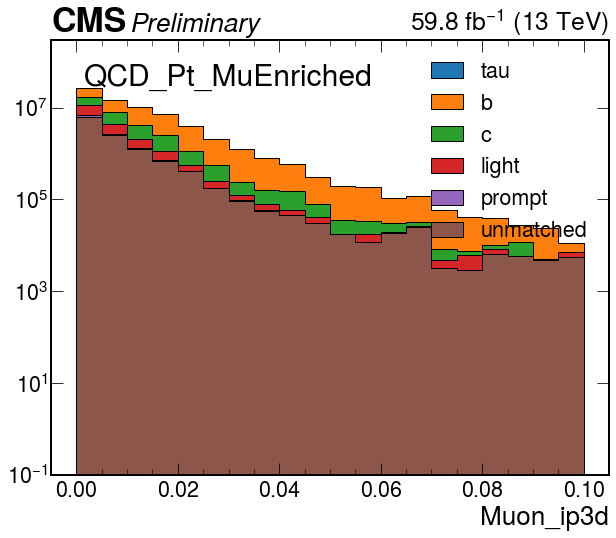

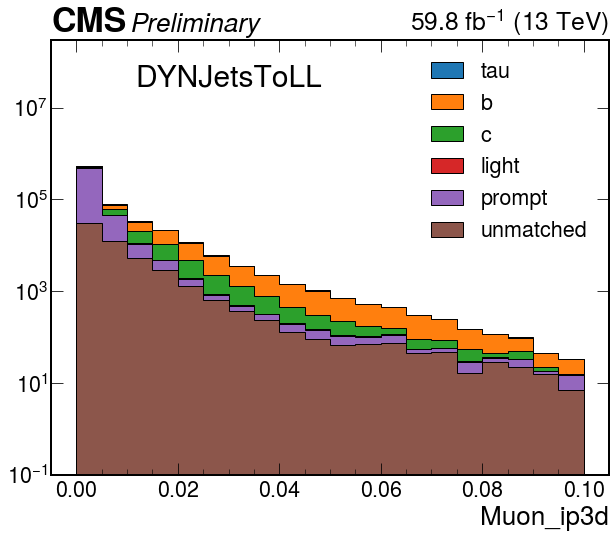

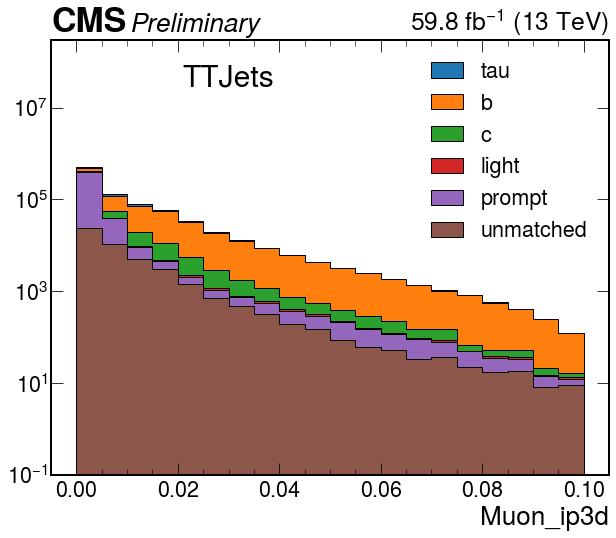

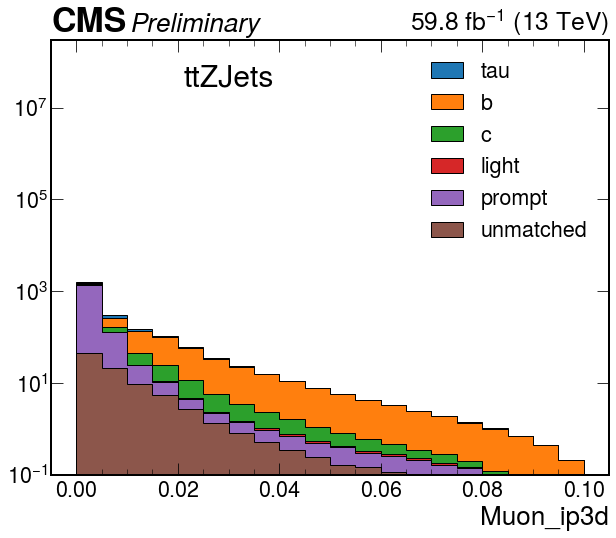

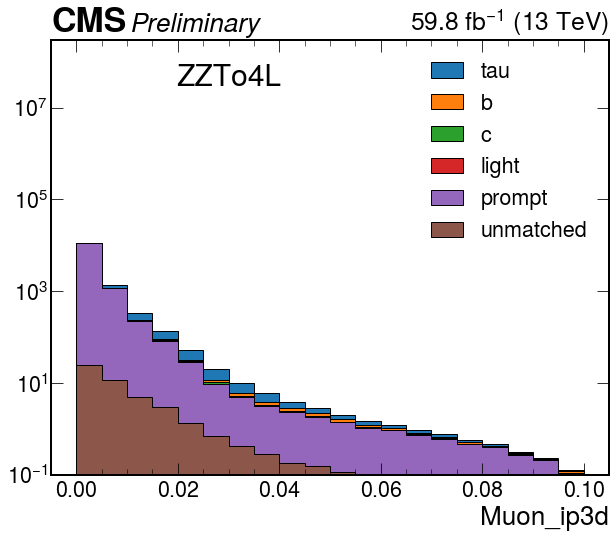

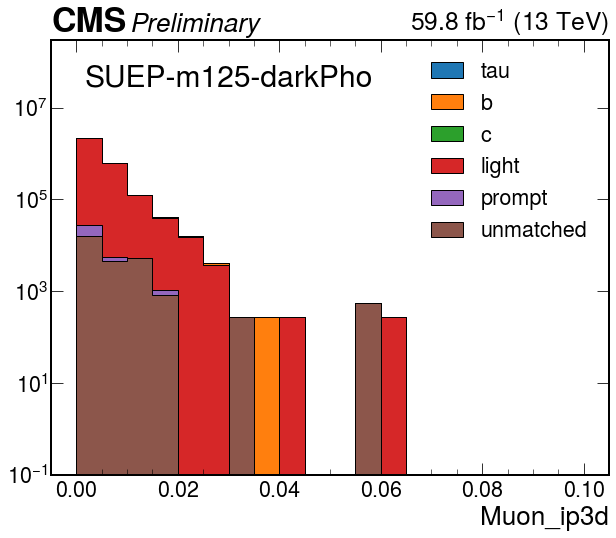

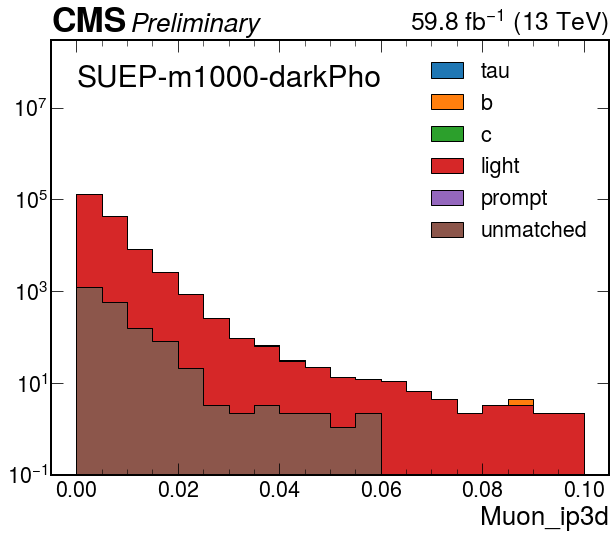

In [46]:
plot_label = 'muon_ip3d_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

genPartFlavor_labels = [
    "unmatched",
    "prompt",
    "light",
    "c",
    "b",
    "tau",
]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
    hists = []
    for i in range(6):
        hists.append(plots[sample][plot_label][::10j, i, ::sum])
    hep.histplot(
        hists,
        yerr=[np.sqrt(h.variances()) for h in hists], 
        label=genPartFlavor_labels,
        stack=True,
        histtype='fill',
        ec="black",
        #lw=2,
    )
    plt.legend()
    plt.yscale('log')
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(3e-2, 3e7,sample.strip('_2018'), fontsize=30, ha='center')
    plt.ylim(1e-1, 3e8)
    plt.show()

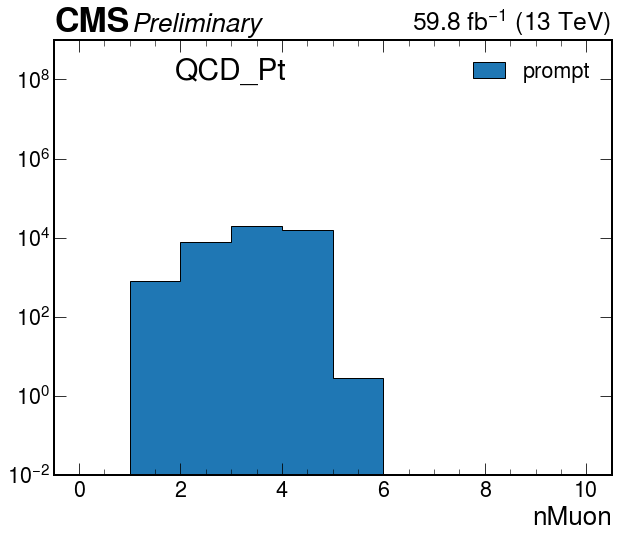

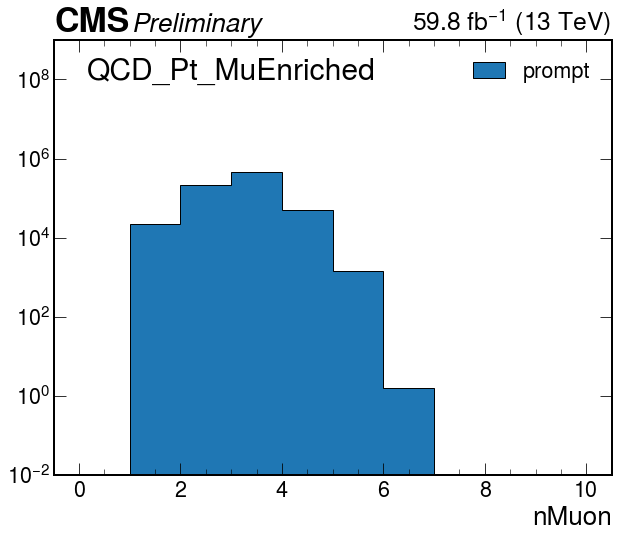

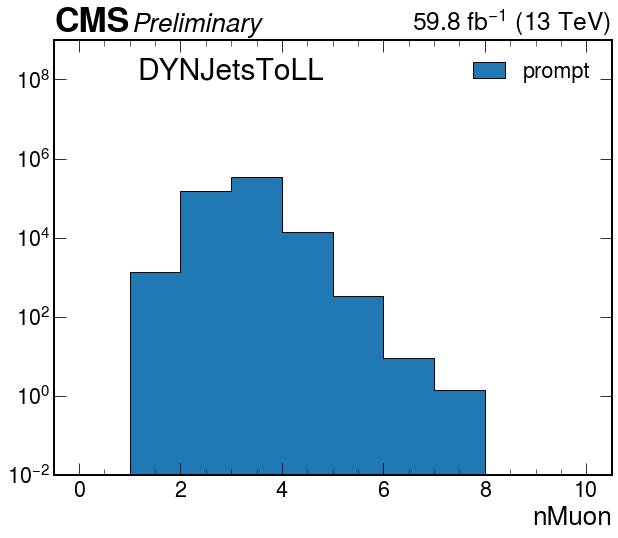

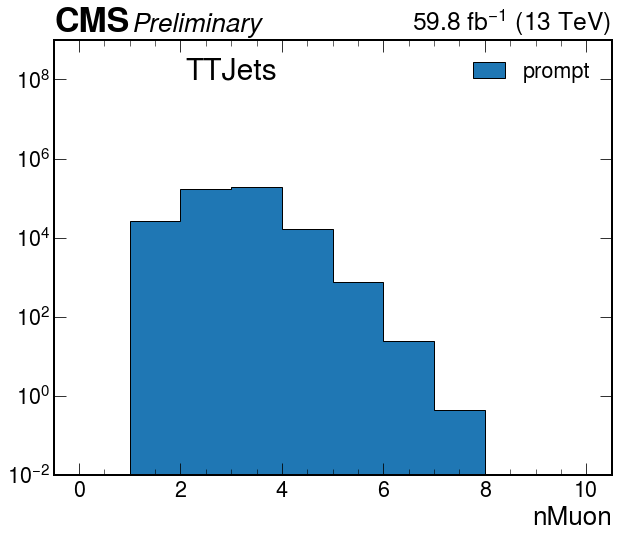

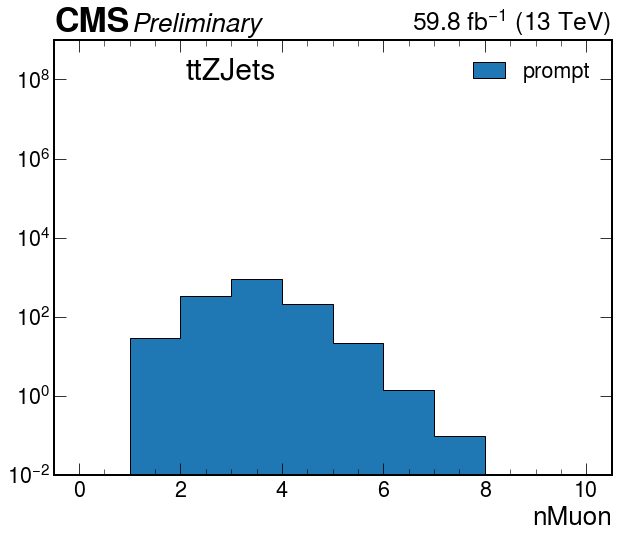

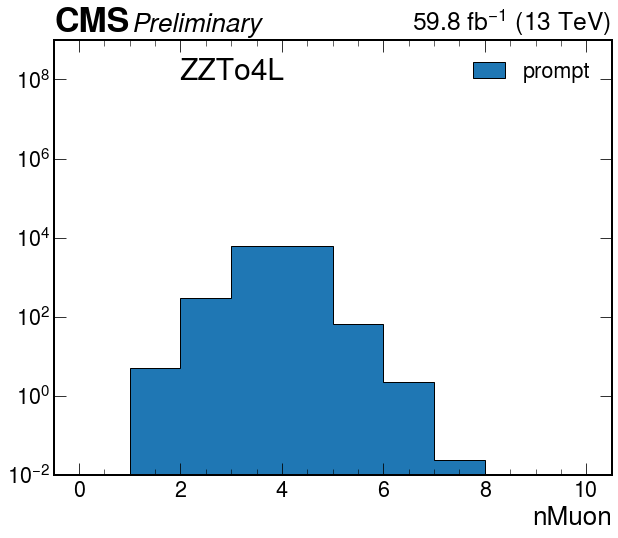

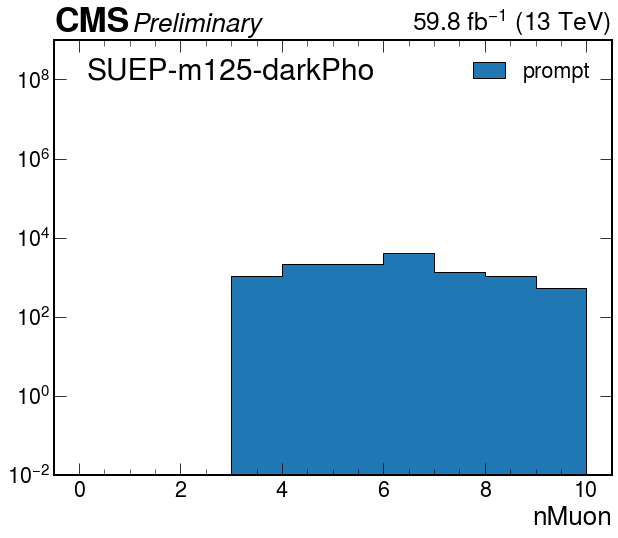

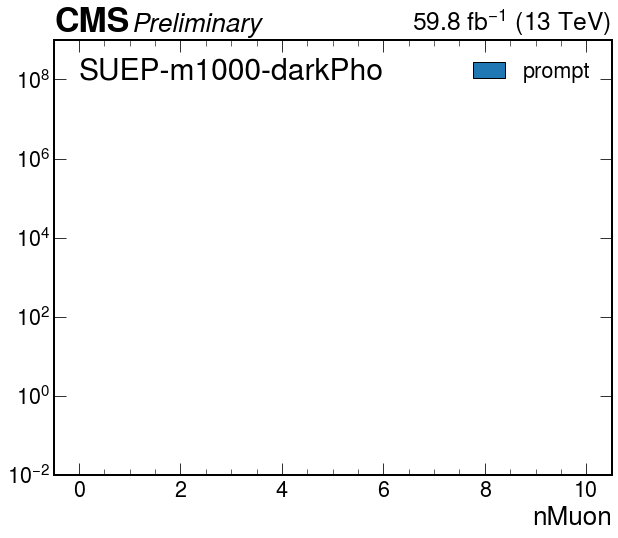

In [62]:
plot_label = 'muon_dz_vs_genflavor_vs_nMuon'
year='2018'
decay='darkPho'

samples = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018',
    'DYNJetsToLL_2018',
    'TTJets_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

genPartFlavor_labels = [
    "unmatched",
    "prompt",
    "light",
    "c",
    "b",
    "tau",
]

flavors_to_show = [1]

for sample in samples:
    fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
    hists = []
    for i in flavors_to_show:
        hists.append(plots[sample][plot_label][::sum, i, :])
    hep.histplot(
        hists,
        yerr=[np.sqrt(h.variances()) for h in hists], 
        label=[genPartFlavor_labels[j] for j in flavors_to_show],
        stack=True,
        histtype='fill',
        ec="black",
        #lw=2,
    )
    plt.legend()
    plt.yscale('log')
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    ax1.text(3, 1e8,sample.strip('_2018'), fontsize=30, ha='center')
    plt.ylim(1e-2, 1e9)
    plt.show()

In [15]:
plots['QCD_Pt_MuEnriched_2018']['mt_vs_genflavor'].project("Muon_genPartFlav")

Hist(IntCategory([0, 1, 3, 4, 5, 15], name='Muon_genPartFlav', label='Muon_genPartFlav'), storage=Weight()) # Sum: WeightedSum(value=3969.98, variance=1.96118e+06)

169666.5480 ± 79478.6629
432588.5882 ± 32700.4432


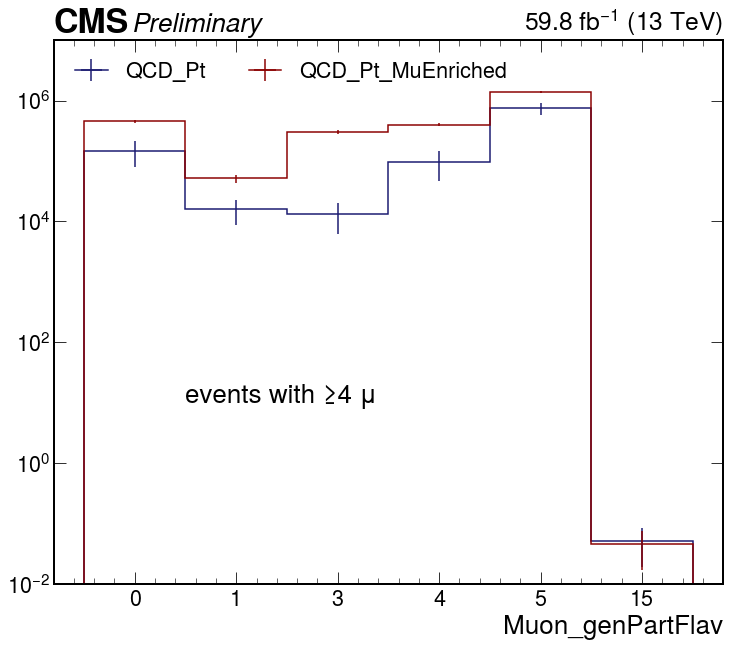

In [49]:
plot_labels = ['Muon_genPartFlav']
year='2018'
decay='darkPho'

samples_bkg = [
    'QCD_Pt_2018',
    'QCD_Pt_MuEnriched_2018'
    #'QCD_HT_2018',
    #'DYNJetsToLL_2018',
    #'TTJets_2018',
    #'ttZJets_2018',
    #'ZZTo4L_2018',
    #'ZZZ_2018',
    #'WWZ_4F_2018',
]
samples_signal = [
    f'SUEP-m125-{decay}_2018',
    #f'SUEP-m400-{decay}_2018',
    #f'SUEP-m750-{decay}_2018',
    f'SUEP-m1000-{decay}_2018',
]

density = False
plot_signal = False

for plot_label in plot_labels:
    fig, ax = plt.subplots(figsize=(12, 10))
    hep.cms.label(llabel='Preliminary',data=False, lumi=plot_utils.lumiLabel(year))
    h_bkg = []
    for sample in samples_bkg: 
        h_temp = plots[sample]["mt_vs_genflavor"][::sum, :, 4j::sum]
        h = h_temp[::]
        if density:
            h = h/h.sum().value
        h_bkg.append(h)
        print(f"{h.sum().value/6:.4f} ± {np.sqrt(h.sum().variance/6):.4f}")
    hep.histplot(
        h_bkg,
        yerr=[np.sqrt(h.variances()) for h in h_bkg], 
        label=[s[:-5] for s in samples_bkg], 
        color=[plot_utils.default_colors[sample] for sample in samples_bkg],
        stack=False,
        histtype='step',
    )

    for sample in samples_signal:
        if not plot_signal:
            continue
        h_temp = plots[sample][plot_label]
        h = h_temp[::5j]
        if density: h = h/h.sum().value
        hep.histplot(
            h,
            yerr=np.sqrt(h.variances()), 
            label=sample, 
            color=plot_utils.default_colors[sample],
        )

    # tweak these by hand, as needed
    plt.ylim(1e-2, 1e7)
    #plt.setp(ax.get_xticklabels(), rotation=350)
    #plt.xlabel('cutflow')
    plt.text(1, 1e1, "events with ≥4 μ")
    plt.legend(ncol=2)
    plt.yscale("log")
    plt.show()